### Formatting / Imports

In [1]:
#import all the relevant libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns

import datetime as dt
from datetime import timedelta
from pandas_datareader import data as pdr
import yfinance as yf
import talib as ta
import plotly.graph_objects as go

from typing import Dict, Any

np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict

### Resampling to 1H

In [2]:
all_data = pd.read_csv("ETHUSD_1m_Combined_Index.csv")
df = pd.DataFrame(all_data)

# Convert Timestamp to datetime
df['Datetime'] = pd.to_datetime(df['Open time'])

# Optional: Set as indexx
df.set_index('Datetime', inplace=True)

# Assuming 'df' is already indexed by datetime
df_1h = df.resample('1h').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

PriceDF = df_1h["2025-03-03 00:00:00":] # df_1h

### Variable Setting

In [3]:
cci_period = 14
TradingCost = 0.0005
cci_upper = 200
cci_lower = -200
cci_mid = 0 
long_action = 1
short_action = -1

### Set base strategy - CCI cross over

In [4]:
# --- CCI Signal function ---
def CCIIndicator(PriceDF: pd.DataFrame = PriceDF, cci_period: int = cci_period) -> pd.DataFrame:
    PriceDF['CCI'] = ta.CCI(PriceDF['High'], PriceDF['Low'], PriceDF['Close'], timeperiod = cci_period 
                            )
    
    # Create SignalDF with relevant columns
    SignalDF = PriceDF[['Open', 'High', 'Low', 'Close', 'CCI']].iloc[cci_period:]
    return SignalDF

# Generate signals 
IndicatorDF = CCIIndicator(PriceDF, cci_period)


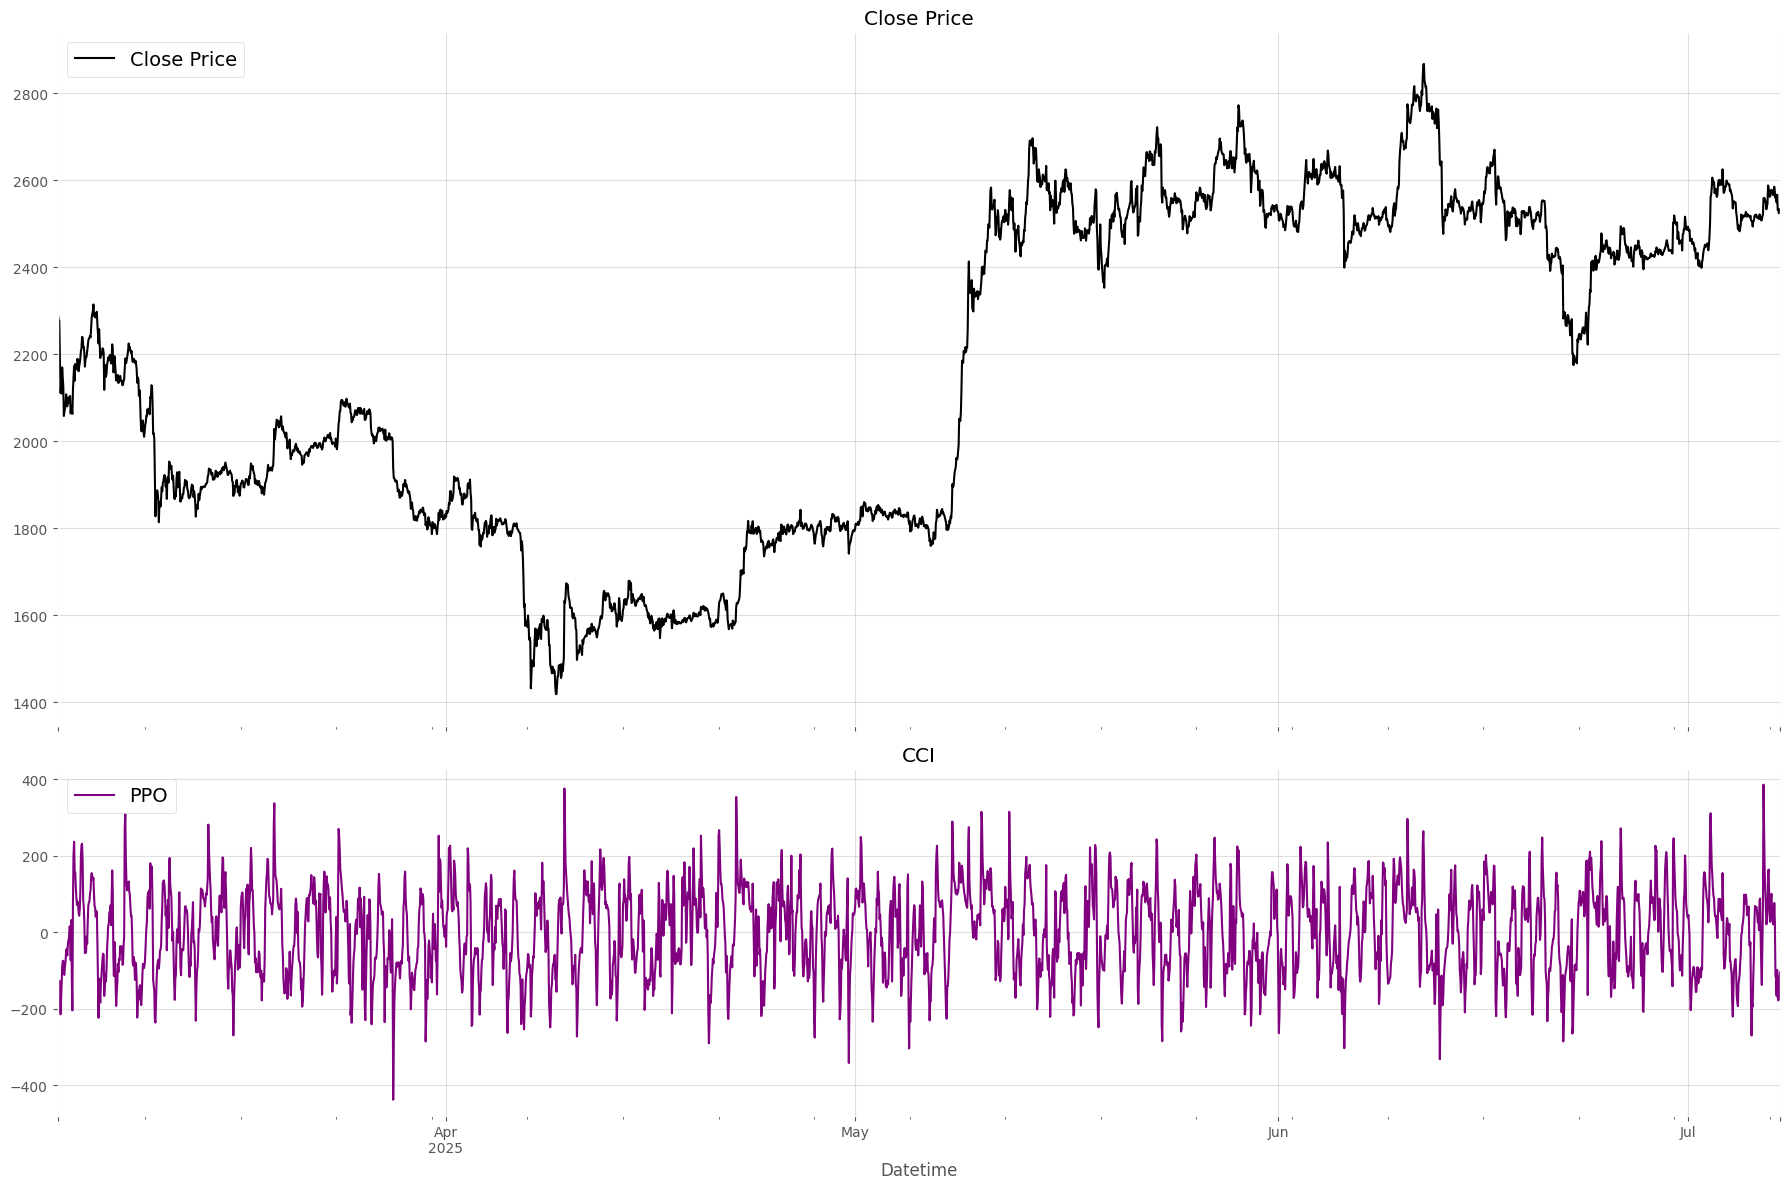

In [5]:
# --- Plot Price and Signal ---
def plot_price_signal(IndicatorDF: pd.DataFrame):
    # --- Create 2 subplots: Close Price, CCI---
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(18, 12), sharex=True,
        gridspec_kw={'height_ratios': [2, 1]}
    )

    # --- Subplot 1: Close Price ---
    IndicatorDF["Close"].plot(ax=ax1, color="black", label="Close Price")
    ax1.set_title("Close Price")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    # --- Subplot 2: CCI ---
    IndicatorDF["CCI"].plot(ax=ax2, color="purple", label="PPO")
    ax2.set_title("CCI")
    ax2.legend(loc="upper left")
    ax2.grid(True)

    # Layout cleanup
    plt.tight_layout()
    plt.show()

plot_price_signal(IndicatorDF)

In [6]:
# import pandas as pd
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# def plot_price_signal_plotly(df: pd.DataFrame, *, use_candles=False, show=False):
#     ts = df.copy()
#     if not isinstance(ts.index, pd.DatetimeIndex):
#         ts.index = pd.to_datetime(ts.index)

#     fig = make_subplots(
#         rows=2, cols=1, shared_xaxes=True,
#         row_heights=[0.65, 0.35], vertical_spacing=0.06,
#         specs=[[{"secondary_y": False}], [{"secondary_y": False}]],
#         subplot_titles=("Close Price", "Relative Strength Index (CCI)")
#     )

#     # --- Row 1: price (only here)
#     if use_candles and all(c in ts.columns for c in ["Open","High","Low","Close"]):
#         fig.add_trace(go.Candlestick(
#             x=ts.index, open=ts["Open"], high=ts["High"],
#             low=ts["Low"], close=ts["Close"],
#             name="OHLC", showlegend=True
#         ), row=1, col=1)
#     else:
#         fig.add_trace(go.Scatter(
#             x=ts.index, y=ts["Close"], mode="lines",
#             name="Close Price",
#             hovertemplate="Time=%{x}<br>Close=%{y:.4f}<extra></extra>",
#             showlegend=True
#         ), row=1, col=1)

#     # --- Row 2: CCI (only here)
#     if "CCI" in ts.columns:
#         fig.add_trace(go.Scatter(
#             x=ts.index, y=ts["CCI"], mode="lines",
#             name="CCI",
#             hovertemplate="CCI=%{y:.2f}<br>%{x}<extra></extra>",
#             showlegend=True
#         ), row=2, col=1)

#         # Guides
#         fig.add_trace(go.Scatter(
#             x=ts.index, y=[70]*len(ts), mode="lines",
#             name="Overbought (70)", line=dict(dash="dash"),
#             showlegend=True
#         ), row=2, col=1)
#         fig.add_trace(go.Scatter(
#             x=ts.index, y=[30]*len(ts), mode="lines",
#             name="Oversold (30)", line=dict(dash="dash"),
#             showlegend=True
#         ), row=2, col=1)

#         fig.update_yaxes(title_text="CCI", range=[0, 100], fixedrange=False, row=2, col=1)

#     # Layout
#     fig.update_yaxes(title_text="Price", row=1, col=1)
#     fig.update_layout(
#         title="Price & CCI",
#         hovermode="x unified",
#         margin=dict(t=90, r=20, b=80, l=60),
#         legend=dict(orientation="h", y=1.10, yanchor="bottom", x=0.0, xanchor="left"),
#         xaxis=dict(
#             rangeslider=dict(visible=True),
#             rangeselector=dict(
#                 buttons=[
#                     dict(count=1, label="1D", step="day",   stepmode="backward"),
#                     dict(count=5, label="5D", step="day",   stepmode="backward"),
#                     dict(count=1, label="1M", step="month", stepmode="backward"),
#                     dict(step="all")
#                 ],
#                 x=0, y=1.20, xanchor="left", yanchor="bottom"
#             )
#         ),
#         xaxis2=dict(title="Datetime")
#     )

#     # if show:
#     #     fig.show()
#     return fig

In [7]:
# fig = plot_price_signal_plotly(IndicatorDF, use_candles=False)
# fig.show()

### Set Signal Generation

In [8]:
def signal_generation(IndicatorDF: pd.DataFrame, mode = "mean_reversion", exit_mode = "breakout", 
                      long_action: int = long_action, short_action: int = short_action):
    ts = IndicatorDF.copy()
    cci = ts["CCI"]

    if mode == "mean_reversion":
        long_signal = ((cci.shift(1) < cci_lower) &
                       (cci >= cci_lower)
                       )
        short_signal = ((cci.shift(1) > cci_upper) &
                        (cci <= cci_upper)
                        )
        
        if exit_mode == "midpoint":
            ts["Positions"] = np.nan
            ts.loc[long_signal, "Positions"] = long_action
            ts.loc[short_signal, "Positions"] = short_action

            exit_long = ((cci.shift(1) < cci_mid) &
                         (cci >= cci_mid)                         
                         )
            exit_short =((cci.shift(1) > cci_mid) &
                         (cci <= cci_mid)
                         )
            ts.loc[exit_long | exit_short, "Positions"] = 0
        elif exit_mode == "breakout":
            ts["Positions"] = np.nan
            ts.loc[long_signal, "Positions"] = long_action
            ts.loc[short_signal, "Positions"] = short_action

        else:
            raise ValueError("mode must be 'midpoint' or 'breakout'")

    elif mode == "momentum":
        short_signal = ((cci.shift(1) > cci_lower) &
                       (cci <= cci_lower)
                       )
        long_signal = ((cci.shift(1) < cci_upper) &
                        (cci >= cci_upper)
                        )
        
        if exit_mode == "midpoint":
            ts["Positions"] = np.nan
            ts.loc[long_signal, "Positions"] = long_action
            ts.loc[short_signal, "Positions"] = short_action

            exit_short = ((cci.shift(1) < cci_mid) &
                         (cci >= cci_mid)                         
                         )
            exit_long =((cci.shift(1) > cci_mid) &
                         (cci <= cci_mid)
                         )
            ts.loc[exit_long | exit_short, "Positions"] = 0
        elif exit_mode == "breakout":
            ts["Positions"] = np.nan
            ts.loc[long_signal, "Positions"] = long_action
            ts.loc[short_signal, "Positions"] = short_action

        else:
            raise ValueError("mode must be 'midpoint' or 'breakout'")
    
    else:
            raise ValueError("mode must be 'mean_reversion' or 'momentum'")
    
    ts["Positions_base"] = ts["Positions"].copy()

    # 🔑 Explicit edge booleans for downstream SL/max-holding
    ts["EdgeLong"]  = long_signal.fillna(False)
    ts["EdgeShort"] = short_signal.fillna(False) 
    
    return ts

### Set Trading Strategy

In [9]:
def TradingStrategy(SignalDF: pd.DataFrame):
    tradingstrategy_df = SignalDF.copy()
    tradingstrategy_df["Action"] = 0

    # ffills
    tradingstrategy_df["Positions"] = tradingstrategy_df["Positions"].ffill()
    tradingstrategy_df["Positions"] = tradingstrategy_df["Positions"].fillna(0)
    tradingstrategy_df["Action"] = tradingstrategy_df["Positions"].diff()
    tradingstrategy_df["Action"][0] = 0
    tradingstrategy_df["Action_base"] = tradingstrategy_df["Positions_base"]

    prev_pos = tradingstrategy_df["Positions"].shift(1)
    pos      = tradingstrategy_df["Positions"]
    delta    = pos - prev_pos  # this is your Action

    # Categorize events (booleans)
    entry_long  = (delta > 0) & (pos > 0) & (prev_pos == 0)          # 0→+1 or -1→+1 (flip tagged separately below)
    exit_short  = (delta > 0) & (pos == 0) & (prev_pos < 0)          # -1→0  (your case)
    entry_short = (delta < 0) & (pos < 0) & (prev_pos == 0)          # 0→-1
    exit_long   = (delta < 0) & (pos == 0) & (prev_pos > 0)          # +1→0

    # Optional: flips (same-bar reversal)
    flip_to_long  = (prev_pos < 0) & (pos > 0)                       # -1→+1
    flip_to_short = (prev_pos > 0) & (pos < 0)                       # +1→-1

    # Store clean Action and event flags
    # ts["Action"]        = delta.fillna(0)
    tradingstrategy_df["EntryLong"]     = entry_long
    tradingstrategy_df["ExitShort"]     = exit_short
    tradingstrategy_df["EntryShort"]    = entry_short
    tradingstrategy_df["ExitLong"]      = exit_long
    tradingstrategy_df["FlipToLong"]    = flip_to_long
    tradingstrategy_df["FlipToShort"]   = flip_to_short

    tradingstrategy_df["Returns"] = np.log(tradingstrategy_df['Close'] / tradingstrategy_df['Close'].shift(1))
    tradingstrategy_df["Strategy"] = tradingstrategy_df["Returns"] * tradingstrategy_df["Positions"].shift(1)
    tradingstrategy_df["Returns"][0] = 0
    tradingstrategy_df["Strategy"][0] = 0
    log_cost = np.log(1 - TradingCost)
    tradingstrategy_df["Strategy_w_cost"] = tradingstrategy_df["Strategy"] + np.where(tradingstrategy_df["Action"] != 0, log_cost*abs(tradingstrategy_df["Action"]), 0)
    return tradingstrategy_df

In [10]:
# Save to Excel
# TradingStrategy.to_excel("equity_table.xlsx", index=True)  # index=True keeps the datetime index

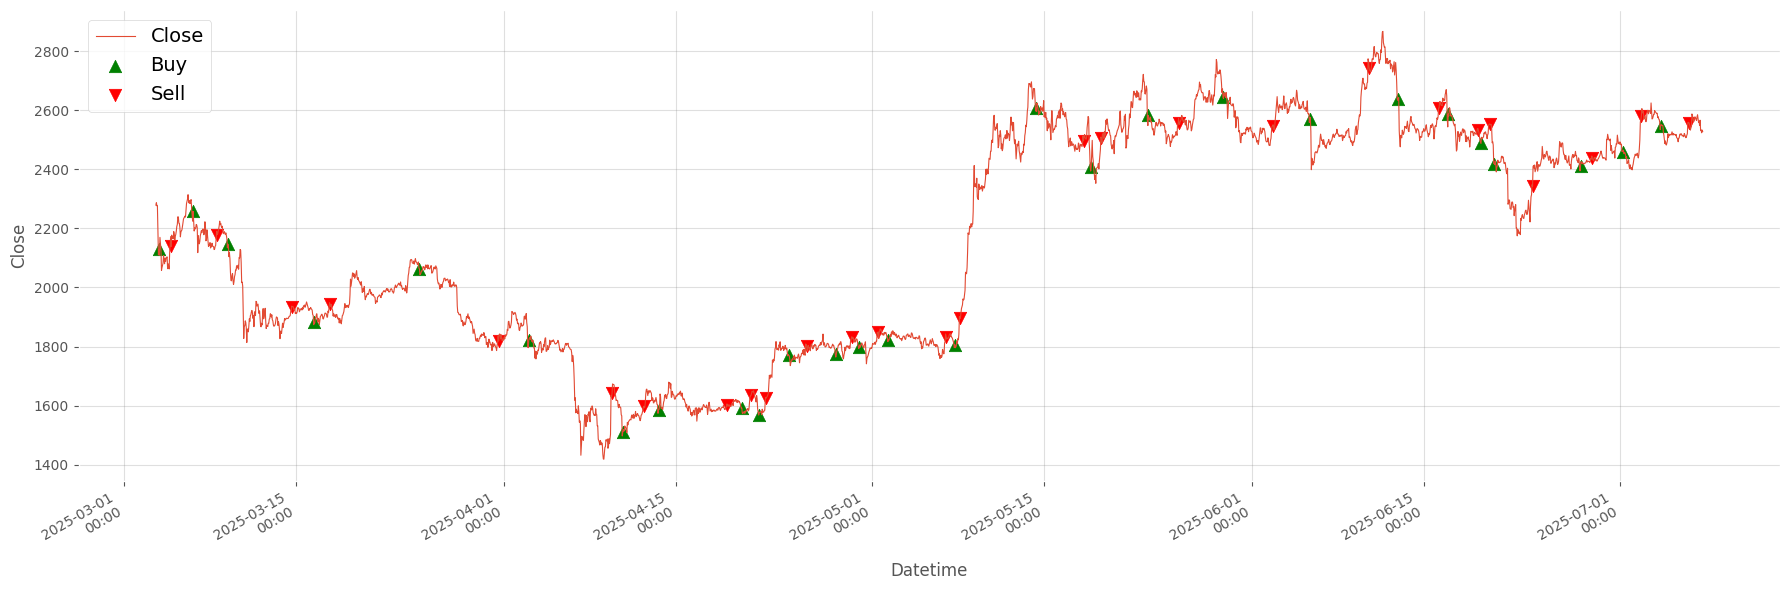

In [11]:
def plot_price_trades(TradingStrategy: pd.DataFrame):
        
        fig, ax = plt.subplots(figsize=(18, 6))

        # Price line
        ax.plot(TradingStrategy.index,
                TradingStrategy['Close'],
                linewidth=0.8,
                label='Close')

        # Buy signals
        buys = TradingStrategy.loc[TradingStrategy.Action >= 1.0]
        ax.scatter(buys.index, buys['Close'],
                marker='^', color='green', s=80, label='Buy')

        # Sell signals
        sells = TradingStrategy.loc[TradingStrategy.Action <= -1.0]
        ax.scatter(sells.index, sells['Close'],
                marker='v', color='red', s=80, label='Sell')

        # Format x-axis
        ax.set_xlabel('Datetime')
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
        fig.autofmt_xdate()

        ax.set_ylabel('Close')
        ax.legend()
        plt.tight_layout()
        plt.show()

plot_price_trades(TradingStrategy(signal_generation(IndicatorDF)))

In [12]:
def plot_price_trades_interactive(TradingStrategy: pd.DataFrame, *, title: str | None = None, show: bool = True):
    """
    Interactive price + trade markers using Plotly.
    Expects:
      - DatetimeIndex
      - columns: ['Close', 'Action'] (Action >= 1 = buy, <= -1 = sell)
    """
    ts = TradingStrategy.copy()
    if not isinstance(ts.index, pd.DatetimeIndex):
        ts.index = pd.to_datetime(ts.index)

    buys  = ts.loc[ts["Action"] >=  1.0]
    sells = ts.loc[ts["Action"] <= -1.0]

    fig = go.Figure()

    # Price line
    fig.add_trace(go.Scatter(
        x=ts.index, y=ts["Close"],
        mode="lines", name="Close",
        hovertemplate="Time=%{x}<br>Close=%{y:.4f}<extra></extra>"
    ))

    # Buy markers
    if not buys.empty:
        fig.add_trace(go.Scatter(
            x=buys.index, y=buys["Close"],
            mode="markers", name="Buy",
            marker_symbol="triangle-up", marker_size=10,
            hovertemplate="Buy @ %{y:.4f}<br>%{x}<extra></extra>"
        ))

    # Sell markers
    if not sells.empty:
        fig.add_trace(go.Scatter(
            x=sells.index, y=sells["Close"],
            mode="markers", name="Sell",
            marker_symbol="triangle-down", marker_size=10,
            hovertemplate="Sell @ %{y:.4f}<br>%{x}<extra></extra>"
        ))

    fig.update_layout(
        title=title or "Price & Trades",
        xaxis_title="Datetime", yaxis_title="Close",
        hovermode="x unified",
        xaxis=dict(
            rangeslider=dict(visible=True),
            rangeselector=dict(buttons=[
                dict(count=1, label="1D", step="day", stepmode="backward"),
                dict(count=5, label="5D", step="day", stepmode="backward"),
                dict(count=1, label="1M", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0)
    )

    fig.update_layout(
    legend=dict(orientation="h", y=1.00, x=0),
    xaxis=dict(rangeselector=dict(x=0, y=1.10))  # higher than legend
)

    # if show:
    #     fig.show()
    return fig

In [13]:
plot_price_trades_interactive(TradingStrategy(signal_generation(IndicatorDF)))
# plot_price_trades_interactive(TradingStrategy)

### Trading turnover calculations

In [14]:
def trade_count(TradingStrategy: pd.DataFrame):
    ts = TradingStrategy.copy()
    pos = pd.to_numeric(ts["Positions"], errors="coerce").fillna(0)
    sign_now  = np.sign(pos)
    sign_prev = np.sign(pos.shift(1).fillna(0))

    # Event flags
    entry_long    = (sign_prev == 0) & (sign_now > 0)
    entry_short   = (sign_prev == 0) & (sign_now < 0)
    flip_to_long  = (sign_prev < 0) & (sign_now > 0)
    flip_to_short = (sign_prev > 0) & (sign_now < 0)
    exit_long     = (sign_prev > 0) & (sign_now == 0)
    exit_short    = (sign_prev < 0) & (sign_now == 0)

    # Start of a trade = any entry or flip
    start_trade = entry_long | entry_short | flip_to_long | flip_to_short
    in_trade    = (sign_now != 0)

    # 1) Trade index bumps on each start
    trade_id = start_trade.cumsum().astype("Float64")  # nullable float so NaN is allowed

    # 2) Fill the id only INSIDE in-trade blocks:
    #    - first mask to keep values only where in_trade
    #    - forward-fill within those True blocks
    #    - mask again so flats AFTER exit don't keep the just-ffilled value
    counter = trade_id.where(in_trade).ffill().where(in_trade)

    # Optional: clear the exit bar itself (if you want the number to disappear on exit row)
    # counter = counter.where(~(exit_long | exit_short))

    # Attach flags if you need them downstream
    ts["EntryLong"]   = entry_long
    ts["EntryShort"]  = entry_short
    ts["ExitLong"]    = exit_long
    ts["ExitShort"]   = exit_short
    ts["FlipToLong"]  = flip_to_long
    ts["FlipToShort"] = flip_to_short
    ts["ActionCount"] = counter

    return counter, ts

def print_trade_statistic(counter_series: pd.Series, TradingStrategy: pd.DataFrame):
    counter_series_df = counter_series.copy()
    tradingstrategy_df = TradingStrategy.copy()
    TradeCount = counter_series_df.max()
    PositiveCount = tradingstrategy_df[tradingstrategy_df["Action"] > 0]["Action"].value_counts().sum()
    NegativeCount = tradingstrategy_df[tradingstrategy_df["Action"] < 0]["Action"].value_counts().sum()
    TotalBars = tradingstrategy_df['ActionCount'].count()

    ValueCount = tradingstrategy_df["Action"].value_counts() # count number each action -2, 0, 1 2
    TotalChurn = (ValueCount.index.to_numpy() * ValueCount.values).astype(float) #calculating turnover for each side
    TotalChurnAbs = abs(TotalChurn).sum() # aggregating the turnover

    TradingCostAssumption = TradingCost
    TotalTradingCost = TotalChurnAbs * TradingCostAssumption

    AnnualizedChurn = TotalChurnAbs / TotalBars * (365 * 24)
    DailyChurn = AnnualizedChurn / 365

    AnnualizedTotalTradingCost = TotalTradingCost / TotalBars * (365 * 24)
    DailyTotalTradingCost = AnnualizedTotalTradingCost / 365

    report = {
        "TradeCount": TradeCount,
        "PositiveCount": PositiveCount,
        "NegativeCount": NegativeCount,
        "TotalBars": TotalBars,
        "TotalChurnAbs": round(TotalChurnAbs, 2),
        "TradingCostPerTrade": f"{TradingCostAssumption * 100:.3f}%",
        "TotalTradingCost": f"{TotalTradingCost * 100:.2f}%",
        "AnnTradingCost": f"{AnnualizedTotalTradingCost * 100:.2f}%",
        "DailyTradingCost": f"{DailyTotalTradingCost * 100:.4f}%",
        "AnnualizedChurn": round(AnnualizedChurn, 2),
        "DailyChurn": round(DailyChurn, 4),
    }

    for k, v in report.items(): 
        print(f"{k:20}: {v}")

# counter_series = trade_count(TradingStrategy(signal_generation(IndicatorDF)))[0]
# ts = trade_count(TradingStrategy(signal_generation(IndicatorDF)))[1]

# print_trade_statistic(counter_series, ts)

### Consolidating trade by trade data

In [15]:
def summary_metrics(TradingStrategy: pd.DataFrame):
    # Drop NaNs in ActionCount and ensure integer type
    df_valid = TradingStrategy.copy()
    df_valid = df_valid.dropna(subset=['ActionCount']).copy()
    df_valid['ActionCount'] = df_valid['ActionCount'].astype(int)

    # Function to compute Sharpe ratio and volatility per group
    def calc_metrics(group):
        returns = group['Strategy_w_cost']
        vol = returns.std()
        mean_ret = returns.mean()
        sharpe = (mean_ret) / vol if vol != 0 else np.nan
        return pd.Series({
            'Start': group.index[0],
            'End': group.index[-1],
            'Cumulative_Return': returns.sum(),
            'Volatility': vol,
            'Sharpe_Ratio': sharpe,
            'Action': group['Action'].iloc[0],
            'Bars': len(group)
        })

    # Group by ActionCount
    summary_metrics = df_valid.groupby('ActionCount').apply(calc_metrics).reset_index()

    return summary_metrics


# ts = trade_count(TradingStrategy(signal_generation(IndicatorDF)))[1]
# summary_metrics(ts)

# View results
# from IPython.display import display
# with pd.option_context('display.max_rows', None):
#     display(summary_metrics)

# summary_metrics


In [16]:
def summary_metrics_annual(TradingStrategy: pd.DataFrame):
    # ---- Config ----
    HOURS_PER_YEAR = 24 * 365  # crypto trades 24/7
    RF_ANNUAL = 0.00           # set your annual risk-free (e.g., 0.03 for 3%)
    RF_HOURLY = (1 + RF_ANNUAL)**(1 / HOURS_PER_YEAR) - 1

    # Ensure datetime index (hourly bars)
    df = TradingStrategy.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Use cost-inclusive simple returns; fallback if needed
    ret_col = "Strategy_w_cost" if "Strategy_w_cost" in df.columns else (
        "Strategy" if "Strategy" in df.columns else "Returns"
    )
    df["r_simple"] = pd.to_numeric(df[ret_col], errors="coerce").replace([np.inf, -np.inf], np.nan)

    # Sanity: keep only rows with ActionCount
    df_valid = df.dropna(subset=["ActionCount"]).copy()
    df_valid["ActionCount"] = df_valid["ActionCount"].astype(int)

    # Precompute log returns (safe for compounding)
    df_valid["r_log"] = np.log1p(df_valid["r_simple"].fillna(0.0))

    def calc_metrics_hourly(group: pd.DataFrame) -> pd.Series:
        # Basic counts
        bars = len(group)  # hourly bars
        if bars == 0:
            return pd.Series(dtype=float)

        # Per-hour stats (sample std, ddof=1)
        r_simple = group["r_simple"].dropna()
        r_log = group["r_log"]  # already filled 0 for NaNs

        # If all NaN simple returns, set safe placeholders
        if r_simple.empty:
            mean_hourly = np.nan
            vol_hourly = np.nan
        else:
            mean_hourly = r_simple.mean()
            vol_hourly  = r_simple.std(ddof=1)

        # Hourly Sharpe (use rf in hourly units)
        # (mean - rf) / std; guard for zero/NaN std
        if vol_hourly and np.isfinite(vol_hourly) and vol_hourly != 0:
            sharpe_hourly = (mean_hourly - RF_HOURLY) / vol_hourly
        else:
            sharpe_hourly = np.nan

        # Annualized metrics (scaling by sqrt(T))
        vol_annual = vol_hourly * np.sqrt(HOURS_PER_YEAR) if pd.notna(vol_hourly) else np.nan
        sharpe_annual = sharpe_hourly * np.sqrt(HOURS_PER_YEAR) if pd.notna(sharpe_hourly) else np.nan

        # Cumulative return over the group (simple) and geometric avg per hour
        cum_simple = np.expm1(r_log.sum())  # = (1+r).prod() - 1
        geo_mean_hourly = np.expm1(r_log.mean())  # geometric mean per hour

        # Optional: duration check (if any irregular timestamps)
        start_ts, end_ts = group.index[0], group.index[-1]
        duration_hours = (end_ts - start_ts) / pd.Timedelta(hours=1) + 1  # inclusive

        return pd.Series({
            "Start": start_ts,
            "End": end_ts,
            "Bars": bars,
            "DurationHours": float(duration_hours),
            "Cumulative_Return": cum_simple,
            "Mean_Hourly_Return": mean_hourly,
            "GeoMean_Hourly_Return": geo_mean_hourly,
            "Volatility_Hourly": vol_hourly,
            "Sharpe_Hourly": sharpe_hourly,
            "Volatility_Annual": vol_annual,
            "Sharpe_Annual": sharpe_annual,
            "Action": group["Action"].iloc[0],
        })

    summary_metrics_annual = (
        df_valid
        .groupby("ActionCount", group_keys=False)
        .apply(calc_metrics_hourly)
        .reset_index()
    )

    return summary_metrics_annual

### Hit rate calculations

In [17]:
def print_hit_rate_metrics(df):
    win_mask = df['Cumulative_Return'] > 0
    loss_mask = df['Cumulative_Return'] < 0

    hit_rate = win_mask.mean()
    win_loss_ratio = win_mask.sum() / loss_mask.sum() if loss_mask.sum() > 0 else float('inf')
    slugging_ratio = df.loc[win_mask, 'Cumulative_Return'].sum() / abs(df.loc[loss_mask, 'Cumulative_Return'].sum())

    report = {
        'Hit Rate': hit_rate,
        'Win/Loss Ratio': win_loss_ratio,
        'Slugging Ratio': slugging_ratio
    }

    metrics = report
    for k, v in metrics.items():
        print(f"{k}: {v:.2%}" if isinstance(v, float) else f"{k}: {v}")

In [18]:
# --- Assumes you already have summary_metrics DataFrame with a 'Cumulative_Return' column ---
def plot_hit_rate(summary_metrics: pd.DataFrame):
    # Step 1: Define rolling metrics calculation
    def rolling_metrics(df, window=20):
        rolling_hit_rate = df['Cumulative_Return'].rolling(window).apply(
            lambda x: np.mean(x > 0), raw=True)

        rolling_win_loss = df['Cumulative_Return'].rolling(window).apply(
            lambda x: np.sum(x > 0) / np.sum(x < 0) if np.sum(x < 0) > 0 else np.nan, raw=True)

        rolling_slugging = df['Cumulative_Return'].rolling(window).apply(
            lambda x: x[x > 0].sum() / -x[x < 0].sum() if np.any(x < 0) else np.nan, raw=True)

        return rolling_hit_rate, rolling_win_loss, rolling_slugging

    # Step 2: Apply to your DataFrame
    summary_metrics = summary_metrics.copy()  # avoid modifying original
    summary_metrics['Hit_Rate'], summary_metrics['Win_Loss_Ratio'], summary_metrics['Slugging_Ratio'] = rolling_metrics(summary_metrics)

    # Step 3: Plot the three charts side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # Hit Rate
    axes[0].plot(summary_metrics['ActionCount'], summary_metrics['Hit_Rate'], label='Hit Rate', color='green')
    axes[0].set_title('20-Period Rolling Hit Rate')
    axes[0].set_xlabel('ActionCount')
    axes[0].set_ylabel('Hit Rate')
    axes[0].grid(True)

    # Win/Loss Ratio
    axes[1].plot(summary_metrics['ActionCount'], summary_metrics['Win_Loss_Ratio'], label='Win/Loss Ratio', color='blue')
    axes[1].set_title('20-Period Rolling Win/Loss Ratio')
    axes[1].set_xlabel('ActionCount')
    axes[1].set_ylabel('Win/Loss Ratio')
    axes[1].grid(True)

    # Slugging Ratio
    axes[2].plot(summary_metrics['ActionCount'], summary_metrics['Slugging_Ratio'], label='Slugging Ratio', color='purple')
    axes[2].set_title('20-Period Rolling Slugging Ratio')
    axes[2].set_xlabel('ActionCount')
    axes[2].set_ylabel('Slugging Ratio')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

### Trade action returns distribution

In [19]:
def plot_return_distribution(summary_metrics: pd.DataFrame): 
    returns = summary_metrics['Cumulative_Return'].dropna()

    plt.figure(figsize=(15, 6))
    sns.histplot(returns, bins=30, kde=True, color='steelblue', stat='density')

    # Add mean and median lines
    plt.axvline(returns.mean(), color='red', linestyle='--', label=f'Mean: {returns.mean():.2%}')
    plt.axvline(returns.median(), color='green', linestyle='-.', label=f'Median: {returns.median():.2%}')

    plt.title('Distribution of Cumulative Returns per ActionCount')
    plt.xlabel('Cumulative Return')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
def plot_return_scatter(summary_metrics_annual: pd.DataFrame):
    # Replace this with your actual DataFrame
    df = summary_metrics_annual.copy()  # or your actual DataFrame

    # Create 1 row × 3 columns of subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False)

    # Define a helper function to get min/max without extreme outliers
    def get_axis_limits(series, lower_pct=1, upper_pct=99):
        # Remove NaN and Inf values
        clean = series.replace([np.inf, -np.inf], np.nan).dropna()
        if clean.empty:  # Avoid returning NaN if all data was invalid
            return (0, 1)
        lower = np.percentile(clean, lower_pct)
        upper = np.percentile(clean, upper_pct)
        return lower, upper

    # Cumulative Return vs Bars
    axes[0].scatter(df['Bars'], df['Cumulative_Return'])
    axes[0].set_title('Cumulative Return vs Bars')
    axes[0].set_xlabel('Bars')
    axes[0].set_ylabel('Cumulative Return')
    axes[0].grid(True)
    axes[0].set_ylim(get_axis_limits(df['Cumulative_Return'], 1, 99))

    # Volatility vs Bars
    axes[1].scatter(df['Bars'], df['Volatility_Annual'])
    axes[1].set_title('Volatility vs Bars')
    axes[1].set_xlabel('Bars')
    axes[1].set_ylabel('Volatility')
    axes[1].grid(True)
    axes[1].set_ylim(get_axis_limits(df['Volatility_Annual'], 1, 99))


    # Sharpe Ratio vs Bars
    axes[2].scatter(df['Bars'], df['Sharpe_Annual'])
    axes[2].set_title('Sharpe Ratio vs Bars')
    axes[2].set_xlabel('Bars')
    axes[2].set_ylabel('Sharpe Ratio')
    axes[2].grid(True)
    axes[2].set_ylim(get_axis_limits(df['Sharpe_Annual'], 1, 99))

    plt.tight_layout()
    plt.show()

In [21]:
def plot_trade_returns(summary_metrics_annual:pd.DataFrame):
    plt.figure(figsize=(12, 5))
    plt.bar(summary_metrics_annual['ActionCount'], summary_metrics_annual['Cumulative_Return'], color='skyblue')
    plt.xlabel("ActionCount")
    plt.ylabel("Cumulative Return")
    plt.title("Cumulative Return per ActionCount")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

In [22]:
def plot_trade_returns_sorted(summary_metrics_annual:pd.DataFrame):
    # Assuming summary_metrics is your DataFrame
    # Step 1: Sort by Cumulative Return
    sorted_df = summary_metrics_annual.sort_values(by='Cumulative_Return', ascending=True).reset_index(drop=True)

    # Step 2: Calculate average and median
    avg_return = sorted_df['Cumulative_Return'].mean()
    med_return = sorted_df['Cumulative_Return'].median()

    # Step 3: Plot cumulative returns
    plt.figure(figsize=(12, 5))
    plt.bar(range(len(sorted_df)), sorted_df['Cumulative_Return'], color='steelblue')
    plt.xlabel("Sorted ActionCount Index")
    plt.ylabel("Cumulative Return")
    plt.title("Sorted Cumulative Returns by ActionCount")
    plt.grid(True, axis='y')

    # Step 4: Add average and median lines
    plt.axhline(y=avg_return, color='red', linestyle='--', linewidth=1.5, label=f'Average: {avg_return:.2%}')
    plt.axhline(y=med_return, color='orange', linestyle='-.', linewidth=1.5, label=f'Median: {med_return:.2%}')

    # Optional legend
    plt.legend()

    plt.tight_layout()
    plt.show()

### Trade by trade look

In [23]:
df = trade_count(TradingStrategy(signal_generation(IndicatorDF)))[1]

In [24]:
for count, group in df.groupby("ActionCount"):
    print(f"\nActionCount = {count}")
    print(group.head())  # or use group.describe(), group.tail(), etc.


ActionCount = 1.0
                        Open     High      Low    Close         CCI  \
Datetime                                                              
2025-03-03 20:00:00  2110.67  2139.63  2097.62  2128.76 -178.940068   
2025-03-03 21:00:00  2128.76  2146.76  2105.08  2109.48 -143.177557   
2025-03-03 22:00:00  2109.48  2173.90  2109.48  2169.71  -92.702226   
2025-03-03 23:00:00  2169.71  2169.71  2142.73  2148.93  -75.490626   
2025-03-04 00:00:00  2148.93  2167.27  2123.71  2125.19  -74.689697   

                     Positions  Positions_base  EdgeLong  EdgeShort  Action  \
Datetime                                                                      
2025-03-03 20:00:00        1.0             1.0      True      False     1.0   
2025-03-03 21:00:00        1.0             NaN     False      False     0.0   
2025-03-03 22:00:00        1.0             NaN     False      False     0.0   
2025-03-03 23:00:00        1.0             NaN     False      False     0.0   
2025-03-0

In [25]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Ensure cumulative returns column exists
# TradingStrategy["Returns_cumsum"] = TradingStrategy.groupby("ActionCount")["Returns"].cumsum()

# # Prepare groups
# groups = [(count, group) for count, group in TradingStrategy.groupby("ActionCount") if not pd.isna(count)]

# # Grid layout parameters
# plots_per_row = 10
# n_plots = len(groups)
# n_rows = int(np.ceil(n_plots / plots_per_row))

# # Create subplots
# fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(plots_per_row * 4, n_rows * 3), sharex=False)
# axes = axes.flatten()  # Flatten in case we only have one row

# # Plot each group
# for idx, (count, group) in enumerate(groups):
#     ax = axes[idx]
#     ax.plot(group.index, group["Returns_cumsum"])
#     ax.set_title(f"ActionCount {int(count)}", fontsize=9)
#     ax.tick_params(axis='x', rotation=45)
#     ax.grid(True)

# # Turn off unused axes
# for j in range(idx + 1, len(axes)):
#     axes[j].axis('off')

# plt.tight_layout()
# plt.show()

### Conversion to daily PnL

In [26]:
def ConvertToDailyReturns(TradingStrategy: pd.DataFrame, initial_capital=1):
    daily_log_returns = TradingStrategy['Returns'].groupby(TradingStrategy.index.date).sum()
    daily_log_returns = pd.Series(daily_log_returns, name='DailyLogReturn')
    daily_log_returns.index = pd.to_datetime(daily_log_returns.index)
    daily_log_strategy = TradingStrategy['Strategy'].groupby(TradingStrategy.index.date).sum()
    daily_log_strategy = pd.Series(daily_log_strategy, name='DailyLogStrategy')
    daily_log_strategy.index = pd.to_datetime(daily_log_strategy.index)
    daily_log_strategy_w_cost = TradingStrategy['Strategy_w_cost'].groupby(TradingStrategy.index.date).sum()
    daily_log_strategy_w_cost = pd.Series(daily_log_strategy_w_cost, name='DailyLogStrategywCost')
    daily_log_strategy_w_cost.index = pd.to_datetime(daily_log_strategy_w_cost.index)
    DailyStrategy = pd.DataFrame(daily_log_strategy)
    DailyStrategy['DailyLogReturn'] = daily_log_returns
    DailyStrategy['DailyLogStrategywCost'] = daily_log_strategy_w_cost
    initial_capital = 1
    DailyStrategy["EquityStrategy"] = np.exp(DailyStrategy["DailyLogStrategy"]) - 1
    DailyStrategy["EquityStrategyCap"] = (1 + DailyStrategy["EquityStrategy"]).cumprod() * initial_capital 
    DailyStrategy["EquityStrategyCapSimple"] = (1 + ( DailyStrategy["EquityStrategy"]).cumsum()) * initial_capital
    DailyStrategy["EquityStrategy_w_cost"] = np.exp(DailyStrategy["DailyLogStrategywCost"]) - 1
    DailyStrategy["EquityStrategyCap_w_cost"] = (1 + DailyStrategy["EquityStrategy_w_cost"]).cumprod() * initial_capital
    DailyStrategy["EquityStrategyCap_w_costSimple"] = (1 + ( DailyStrategy["EquityStrategy_w_cost"]).cumsum()) * initial_capital
    DailyStrategy["EquityBuyHold"] = np.exp(DailyStrategy["DailyLogReturn"]) -1
    DailyStrategy["EquityBuyHoldCap"] = (1 + DailyStrategy["EquityBuyHold"]).cumprod() * initial_capital
    DailyStrategy["DailySimpleStrategy"] = np.exp(DailyStrategy["DailyLogStrategy"]) - 1
    return DailyStrategy

In [27]:
# ConvertToDailyReturns(TradingStrategy, initial_capital=1)

In [28]:
def plot_equity_curve(DailyStrategy):   
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(DailyStrategy.index, DailyStrategy["EquityStrategyCap"], label="Strategy")
    plt.plot(DailyStrategy.index, DailyStrategy["EquityStrategyCap_w_cost"], label="Strategy (w/ cost)")
    plt.plot(DailyStrategy.index, DailyStrategy["EquityStrategyCapSimple"], label="StrategySimple")
    plt.plot(DailyStrategy.index, DailyStrategy["EquityStrategyCap_w_costSimple"], label="Strategy (w/ cost)Simple")
    plt.plot(DailyStrategy.index, DailyStrategy["EquityBuyHoldCap"], label="Buy & Hold")
    plt.title("Equity Curve")
    plt.xlabel("Date")
    plt.ylabel("Equity (Growth of $1)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [29]:
# Save to Excel
# DailyStrategy.to_excel("dailystrat.xlsx", index=True)  # index=True keeps the datetime index

In [30]:
# DailyStrategy = ConvertToDailyReturns(TradingStrategy)
# plot_equity_curve(DailyStrategy)

In [31]:
# def rolling_performance(DailyStrategy, window_size=365, step_size=21):
#     results = []

#     for start in range(0, len(DailyStrategy) - window_size, step_size):
#         end = start + window_size
#         window = DailyStrategy.iloc[start:end].copy()
#         window_start = window.index[0]
#         window_end = window.index[-1]

#         # Compute cumulative return and Sharpe ratio for this window
#         cumulative_return = (np.exp(window["DailyLogStrategywCost"].cumsum()) - 1).iloc[-1]
#         sharpe_ratio = (window["DailyLogStrategywCost"].mean() / window["DailyLogStrategywCost"].std()) * np.sqrt(365)  # Adjust if intraday

#         results.append({
#             "Start": window_start,
#             "End": window_end,
#             "CumulativeReturn": cumulative_return,
#             "SharpeRatio": sharpe_ratio
#         })

#     return pd.DataFrame(results)

In [32]:
# rolling_stats = rolling_performance(DailyStrategy, window_size=360, step_size=5)

In [33]:
# rolling_stats

### Drawdown calculations

In [34]:
def top_drawdowns_code1_strict(df, simple_return_col="Strategy_w_cost", top_n=5, eps=1e-15):
    # 1) Use simple returns; keep NaNs (no drop, no fill) to match Code 1 indexing
    r = df[simple_return_col].astype(float)  # <- change if you want Strategy/Returns

    # 2) Equity = cumprod(1+r)  (equiv to exp(cumsum(log1p)))
    equity = (1.0 + r).cumprod()

    # 3) Drawdown
    peak = equity.cummax()
    drawdown = (equity - peak) / peak

    # 4) Snap tiny float noise around 0 to exactly 0 (optional but helps boundary equality)
    ddz = drawdown.copy()
    ddz[np.abs(ddz) < eps] = 0.0

    # 5) Identify periods: strictly < 0; first non-negative bar closes the period
    in_dd = ddz < 0
    periods = []
    start = None
    for dt, flag in in_dd.items():
        if flag:
            if start is None:
                start = dt
        elif start is not None:
            end = dt  # recovery is first non-drawdown bar
            window = ddz.loc[start:end]  # label slice
            trough = window.idxmin()
            mdd = window.min()
            periods.append((mdd, start, trough, end))
            start = None

    if start is not None:  # still in drawdown at the end
        window = ddz.loc[start:]
        trough = window.idxmin()
        mdd = window.min()
        end = ddz.index[-1]
        periods.append((mdd, start, trough, end))

    top = sorted(periods, key=lambda x: x[0])[:top_n]
    out = pd.DataFrame(top, columns=["Drawdown", "Start", "Trough", "Recovery"])
    return out, equity, ddz

# # ---- Run it and plot (same layout style you had) ----
# dd_tbl, equity_curve, dd_series = top_drawdowns_code1_strict(TradingStrategy, "Strategy_w_cost", top_n=5)

# Ensure readable full dates in the table:
def print_plot_drawdown(dd_tbl, equity_curve, dd_series):
    dd_print = dd_tbl.copy()
    for c in ["Start", "Trough", "Recovery"]:
        dd_print[c] = pd.to_datetime(dd_print[c]).dt.strftime("%Y-%m-%d")

    with pd.option_context("display.max_colwidth", None, "display.width", 200):
        print(dd_print.to_string(index=False))

    # Quick visual check
    n = len(dd_tbl); cols = 3; rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    axes = np.atleast_1d(axes).flatten()
    for i, row in dd_tbl.reset_index(drop=True).iterrows():
        ax = axes[i]
        start, trough, recovery = row["Start"], row["Trough"], row["Recovery"]
        eq_slice = equity_curve.loc[start:recovery]

        title = (f"Drawdown {i+1}: {row['Drawdown']:.2%}\n"
                f"{pd.to_datetime(start).date()} → {pd.to_datetime(recovery).date()} "
                f"(Trough: {pd.to_datetime(trough).date()})")
        ax.plot(eq_slice.index, eq_slice.values)
        ax.axvline(pd.to_datetime(start), linestyle="--", linewidth=1)
        ax.axvline(pd.to_datetime(trough), linestyle="--", linewidth=1)
        ax.axvline(pd.to_datetime(recovery), linestyle="--", linewidth=1)
        ax.set_title(title, fontsize=10); ax.set_ylabel("Equity"); ax.grid(True)

    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(); plt.show()

### Sharpe ratio calculation

In [35]:
# def StrategySharpe(DailyStrategy):
#     DailyReturnMean = (np.exp(DailyStrategy['DailyLogStrategy'])-1).mean()
#     DailyStdDev = (np.exp(DailyStrategy['DailyLogStrategy'])-1).std()
#     Sharpe_Strat = DailyReturnMean / DailyStdDev * np.sqrt(365)
#     DailyReturnMean_bh = (np.exp(DailyStrategy['DailyLogReturn'])-1).mean()
#     DailyStdDev_bh = (np.exp(DailyStrategy['DailyLogReturn'])-1).std()
#     Sharpe_BH = DailyReturnMean_bh / DailyStdDev_bh * np.sqrt(365)
#     DailyReturnMean_wc = (np.exp(DailyStrategy['DailyLogStrategywCost'])-1).mean()
#     DailyStdDev_wc = (np.exp(DailyStrategy['DailyLogStrategywCost'])-1).std()
#     Sharpe_WC = DailyReturnMean_wc / DailyStdDev_wc * np.sqrt(365)
#     return Sharpe_Strat, Sharpe_BH, Sharpe_WC

In [36]:
# StrategySharpe(DailyStrategy)

In [37]:
# DailyStrategy["DailySimpleStrategy"] = np.exp(DailyStrategy["DailyLogStrategy"]) - 1
# DailyStrategy

### Backtest Report Summary

In [38]:
class BacktestReport:
    def __init__(self, strategy_df: pd.DataFrame, strategy_col: str = "DailySimpleStrategy"):
        self.df = strategy_df.copy()
        self.strategy_returns = self.df[strategy_col].fillna(0)

        self.start_date = self.df.index.min()
        self.end_date = self.df.index.max()
        self.duration = self.end_date - self.start_date

        self.equity_curve = np.exp(self.strategy_returns.cumsum())
        self.final_equity = self.equity_curve.iloc[-1]
        self.equity_peak = self.equity_curve.cummax().max()
        self.return_pct = (self.final_equity - 1) * 100

    def compute_metrics(self) -> Dict[str, Any]:
        return {
            "Start": self.start_date,
            "End": self.end_date,
            "Duration": self.duration,
            "Equity Final [$]": self.final_equity,
            "Equity Peak [$]": self.equity_peak,
            "Return [%]": self.return_pct,
            "Return (Ann.) [%]": self._annualized_return() * 100,
            "Volatility (Ann.) [%]": self._annualized_volatility() * 100,
            "Sharpe Ratio": self._sharpe_ratio(),
            "Sortino Ratio": self._sortino_ratio(),
            "Calmar Ratio": self._calmar_ratio(),
            "Max. Drawdown [%]": self._max_drawdown()[0] * 100,
            "Avg. Drawdown [%]": self._average_drawdown()[0] * 100,
            "Max. Drawdown Duration": self._max_drawdown()[1],
            "Avg. Drawdown Duration": self._average_drawdown()[1],
        }

    def _annualized_return(self) -> float:
        return np.exp(self.strategy_returns.mean() * 365) - 1

    def _annualized_volatility(self) -> float:
        return self.strategy_returns.std(ddof=0) * np.sqrt(365)

    def _sharpe_ratio(self, risk_free_rate: float = 0.0) -> float:
        excess = self.strategy_returns - (risk_free_rate / 365)
        std = excess.std(ddof=0)
        return excess.mean() / std * np.sqrt(365) if std > 0 else np.nan

    def _sortino_ratio(self) -> float:
        downside = self.strategy_returns[self.strategy_returns < 0]
        dd_std = downside.std(ddof=0)
        return self._annualized_return() / (dd_std * np.sqrt(365)) if dd_std > 0 else np.nan

    def _calmar_ratio(self) -> float:
        max_dd, _ = self._max_drawdown()
        return self._annualized_return() / abs(max_dd) if max_dd != 0 else np.nan

    def _max_drawdown(self) -> (float, timedelta):
        peak = self.equity_curve.cummax()
        drawdown = (self.equity_curve - peak) / peak
        max_dd = drawdown.min()
        end = drawdown.idxmin()
        start = peak[:end][peak[:end] == peak[:end].max()].last_valid_index()
        duration = end - start if start and end else timedelta(0)
        return max_dd, duration

    def _average_drawdown(self) -> (float, timedelta):
        peak = self.equity_curve.cummax()
        drawdowns = (self.equity_curve - peak) / peak
        in_drawdown = drawdowns < 0

        dd_periods = []
        current = []

        for t, flag in zip(drawdowns.index, in_drawdown):
            if flag:
                current.append(t)
            elif current:
                dd_periods.append(current)
                current = []

        if not dd_periods:
            return 0.0, timedelta(0)

        dd_vals = [drawdowns.loc[p].min() for p in dd_periods]
        dd_durations = [p[-1] - p[0] for p in dd_periods]

        return np.mean(dd_vals), np.mean(dd_durations)

In [39]:
# report = BacktestReport(DailyStrategy[["DailySimpleStrategy"]])
# metrics = report.compute_metrics()
# print(pd.Series(metrics))

In [40]:
import pandas as pd
import plotly.graph_objects as go

def make_metrics_table_figure(metrics) -> go.Figure:
    """
    Accepts a dict or pandas Series of metrics and returns a Plotly Table figure.
    """
    if isinstance(metrics, dict):
        s = pd.Series(metrics)
    else:
        s = pd.Series(metrics)

    df = s.rename("Value").to_frame().reset_index().rename(columns={"index": "Metric"})

    # Pretty format values (numbers → 4 d.p., else str)
    vals = []
    for v in df["Value"]:
        if isinstance(v, (int, float)) and pd.notna(v):
            vals.append(f"{v:.4f}")
        else:
            vals.append("" if pd.isna(v) else str(v))

    fig = go.Figure(data=[go.Table(
        header=dict(
            values=["Metric", "Value"],
            fill_color="#1b2340",
            font=dict(color="white", size=12),
            align="left"
        ),
        cells=dict(
            values=[df["Metric"], vals],
            fill_color="#0d1328",
            font=dict(color="#eaeefb", size=12),
            align="left",
            height=24
        )
    )])

    fig.update_layout(
        title="Backtest Metrics",
        margin=dict(t=60, r=10, b=10, l=10),
    )
    return fig

### Risk and Volatility

In [41]:
# returns_series = TradingStrategy['Strategy_w_cost'].dropna()

# # Risk metrics function
# def calculate_risk_metrics(returns, freq='daily'):
#     # Annualization factors based on frequency
#     ann_factors = {
#         'daily': 365,
#         'weekly': 52,
#         'monthly': 12,
#         'hourly': 365 * 6.5,
#         'minute': 365 * 6.5 * 60
#     }
#     ann_factor = ann_factors.get(freq, 365)

#     # Core metrics
#     cumulative_return = (1 + returns).prod() - 1
#     annualized_volatility = returns.std() * np.sqrt(ann_factor)

#     # Drawdown
#     cumulative = (1 + returns).cumprod()
#     peak = cumulative.cummax()
#     drawdown = (cumulative - peak) / peak
#     max_drawdown = drawdown.min()

#     # Value at Risk (VaR) and Conditional VaR (CVaR) at 95%
#     var_95 = np.percentile(returns, 5)
#     cvar_95 = returns[returns <= var_95].mean()

#     # Skew and kurtosis
#     skewness = returns.skew()
#     kurtosis = returns.kurtosis()

#     # Pack results
#     metrics = {
#         'Cumulative Return': cumulative_return,
#         'Annualized Volatility': annualized_volatility,
#         'Max Drawdown': max_drawdown,
#         'VaR 95%': var_95,
#         'CVaR 95%': cvar_95,
#         'Skewness': skewness,
#         'Kurtosis': kurtosis
#     }

#     return pd.DataFrame([metrics])

# # Calculate risk metrics
# risk_metrics_df = calculate_risk_metrics(returns_series, freq='daily')

# # Display result
# print(risk_metrics_df.T)

### Outputs

In [42]:
cci_period = 14
TradingCost = 0.0005
cci_upper = 50
cci_lower = -50
cci_mid = 0 
long_action = 1
short_action = -1

In [43]:
## DF reset 
IndicatorDF = CCIIndicator(PriceDF, cci_period)
SignalDF = signal_generation(IndicatorDF, mode = "mean_reversion", exit_mode = "breakout",
                             long_action = long_action, short_action = short_action) # mode = "mean_reversion" or "momentum", exit_mode = "midpoint" or "breakout"
TradingStrategy = TradingStrategy(SignalDF)
counter_series, ts = trade_count(TradingStrategy)
summarydf = summary_metrics(ts)
summarydf_annual = summary_metrics_annual(ts)
dailyreturns = ConvertToDailyReturns(ts, initial_capital=1)

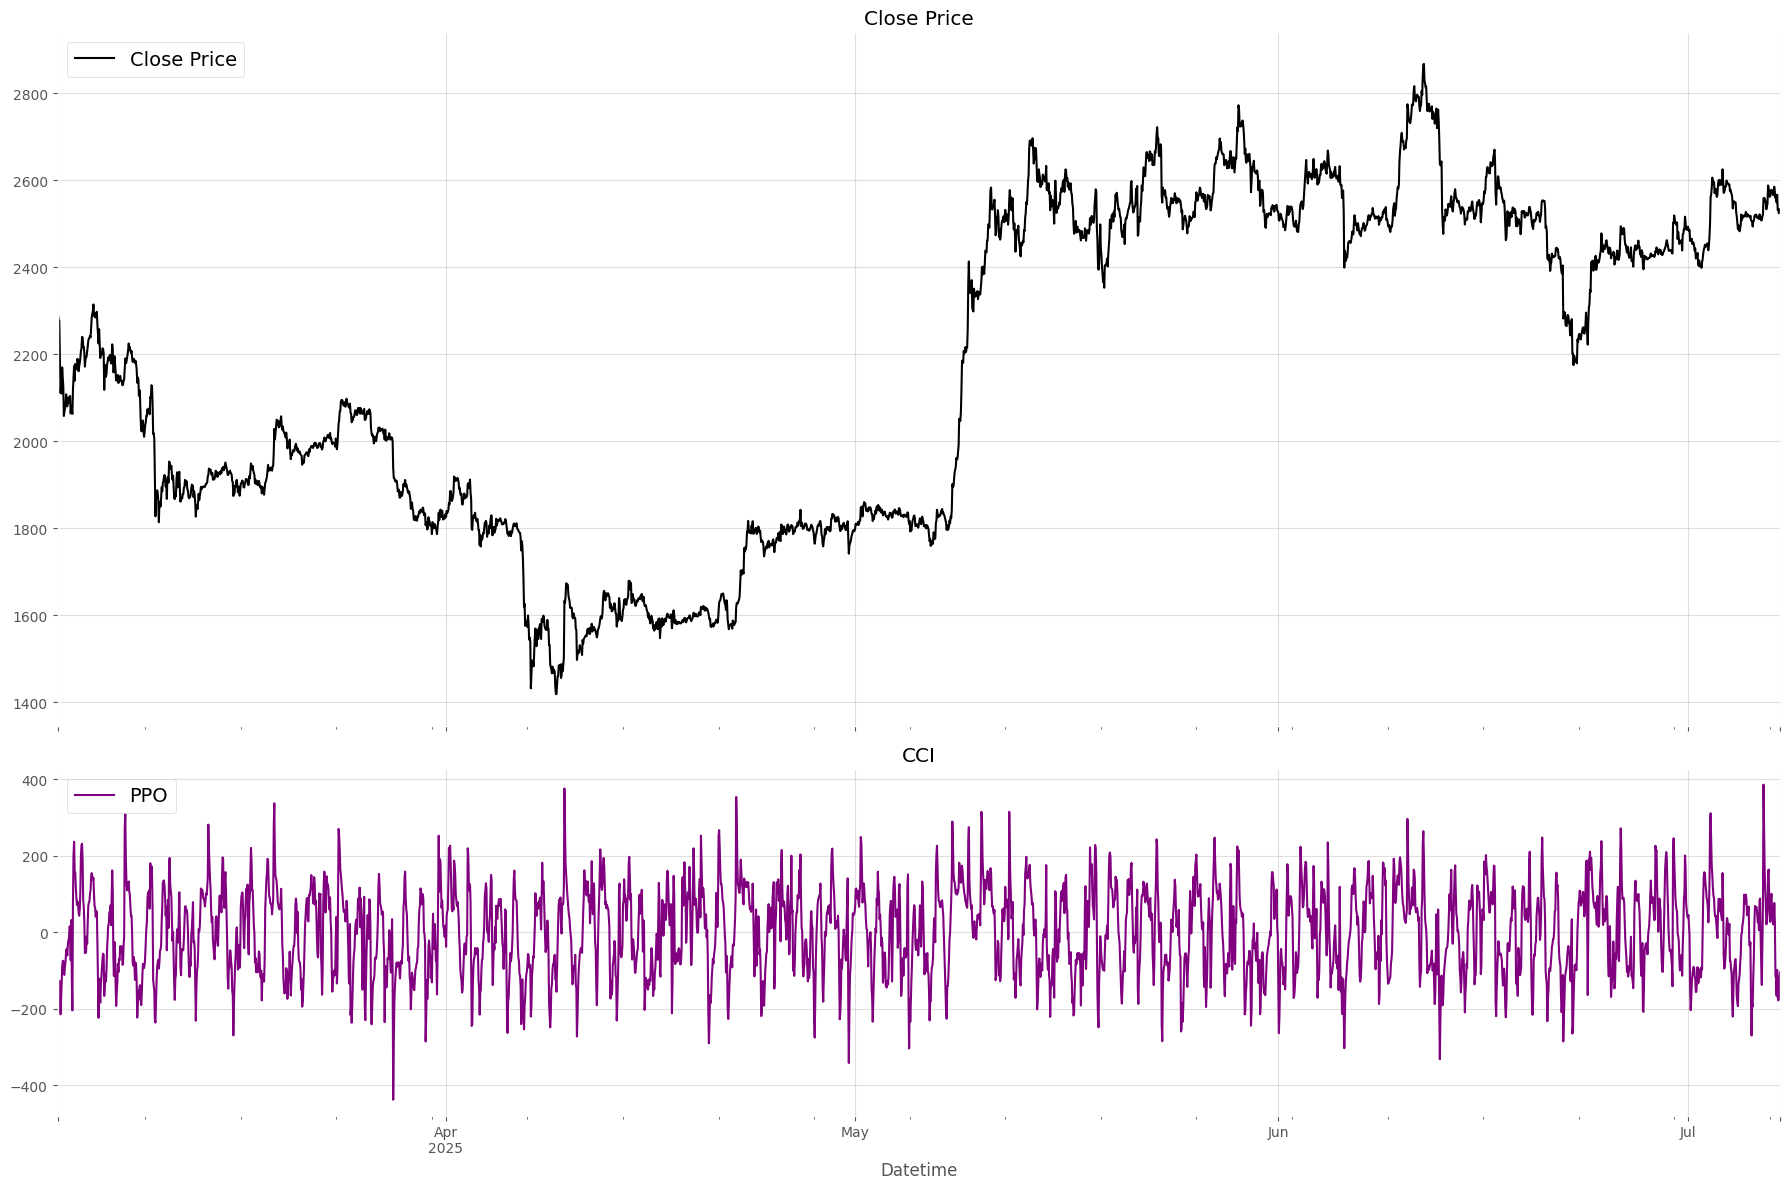

In [44]:
plot_price_signal(IndicatorDF)

In [45]:
# plot_price_trades(TradingStrategy(signal_generation(IndicatorDF)))
plot_price_trades_interactive(TradingStrategy)

In [46]:
print_trade_statistic(counter_series, ts)

TradeCount          : 230.0
PositiveCount       : 115
NegativeCount       : 115
TotalBars           : 3014
TotalChurnAbs       : 459.0
TradingCostPerTrade : 0.050%
TotalTradingCost    : 22.95%
AnnTradingCost      : 66.70%
DailyTradingCost    : 0.1827%
AnnualizedChurn     : 1334.05
DailyChurn          : 3.6549


In [47]:
summarydf.head()

ActionCount               Start                 End  Cumulative_Return  \
0            1 2025-03-04 05:00:00 2025-03-05 03:00:00           0.024353   
1            2 2025-03-05 04:00:00 2025-03-05 14:00:00           0.005459   
2            3 2025-03-05 15:00:00 2025-03-06 08:00:00           0.038927   
3            4 2025-03-06 09:00:00 2025-03-07 04:00:00           0.052777   
4            5 2025-03-07 05:00:00 2025-03-07 11:00:00          -0.000095   

   Volatility  Sharpe_Ratio  Action  Bars  
0    0.010735      0.098635     1.0    23  
1    0.007711      0.064351    -2.0    11  
2    0.005281      0.409482     2.0    18  
3    0.013265      0.198939    -2.0    20  
4    0.005170     -0.002635     2.0     7

In [48]:
print_hit_rate_metrics(summarydf)

Hit Rate: 45.22%
Win/Loss Ratio: 82.54%
Slugging Ratio: 130.68%


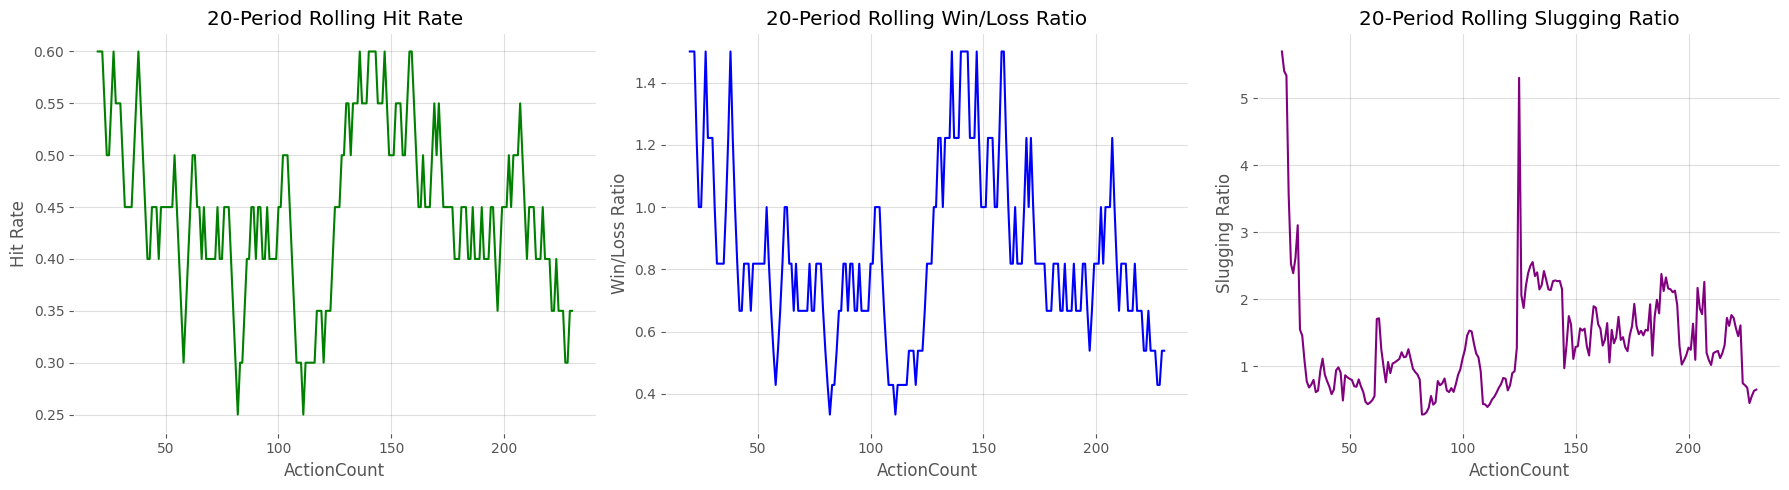

In [49]:
plot_hit_rate(summarydf)

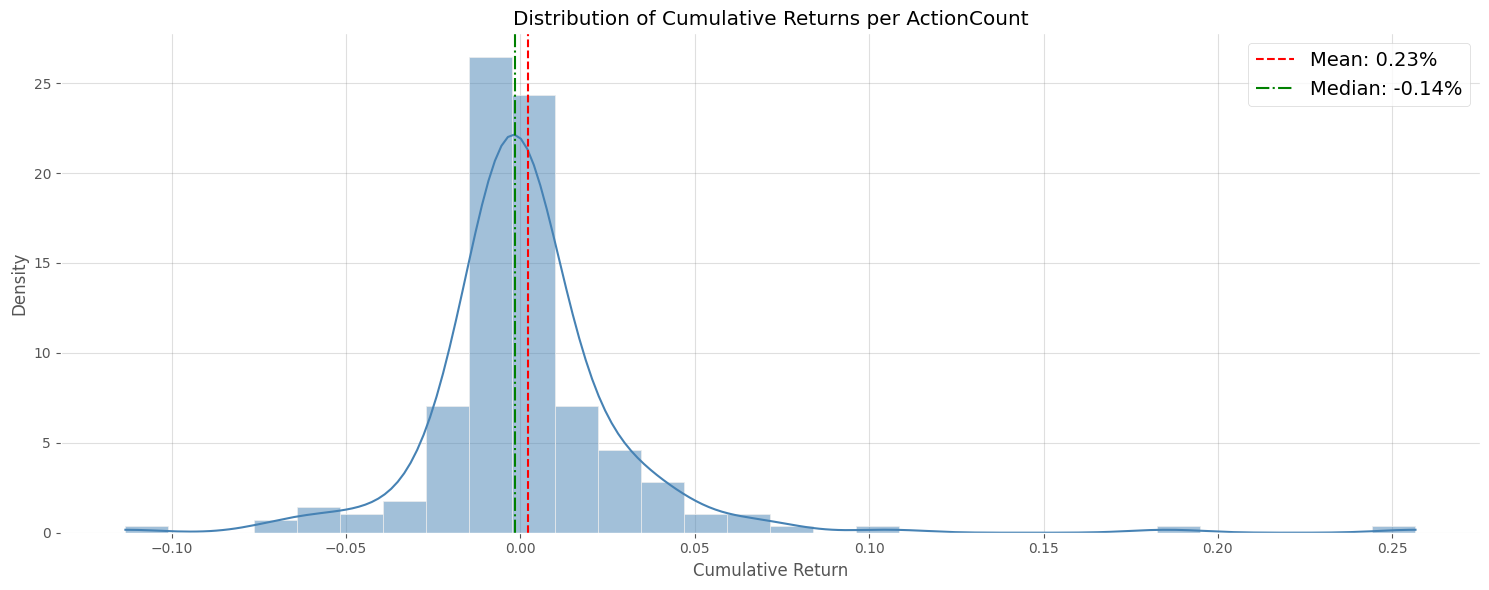

In [50]:
plot_return_distribution(summarydf)

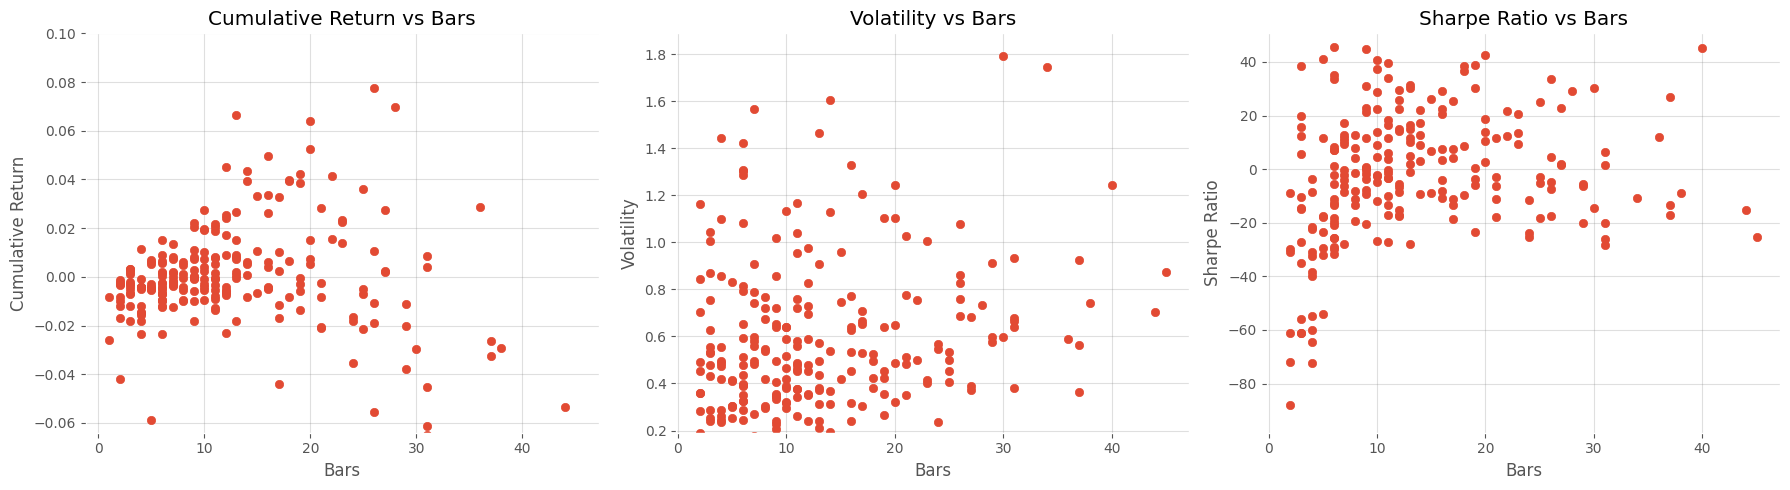

In [51]:
plot_return_scatter(summarydf_annual)

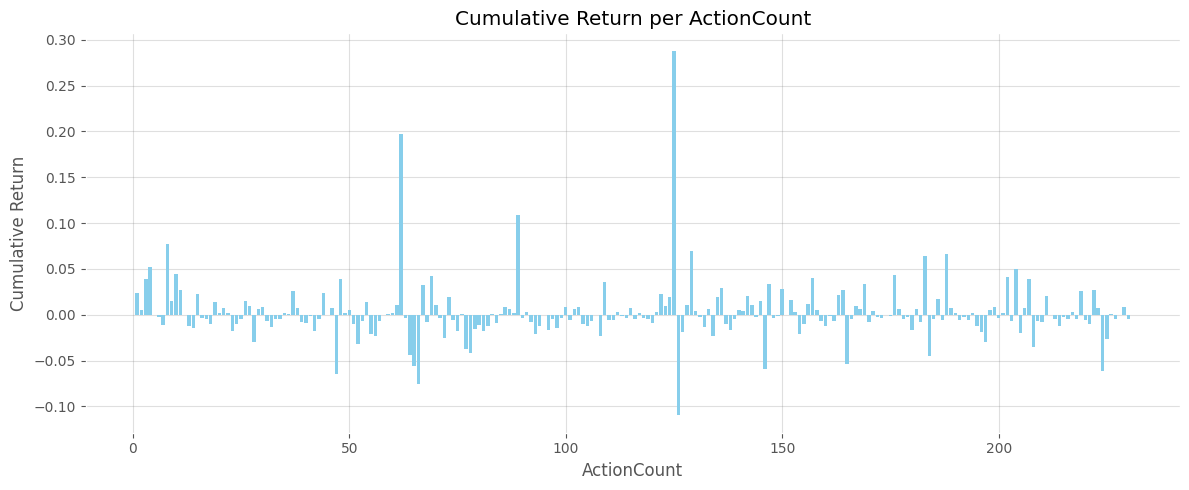

In [52]:
plot_trade_returns(summarydf_annual)

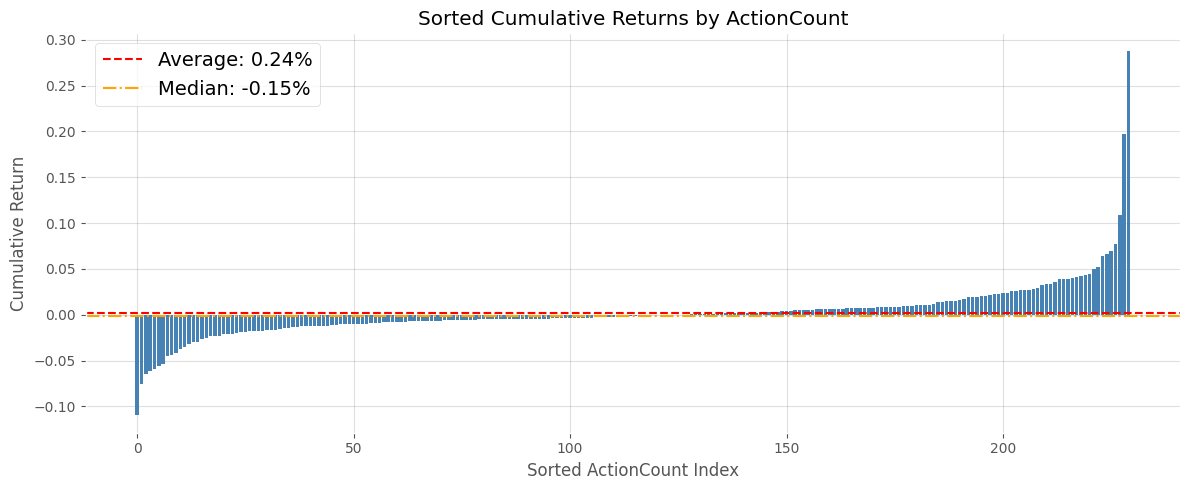

In [53]:
plot_trade_returns_sorted(summarydf_annual)

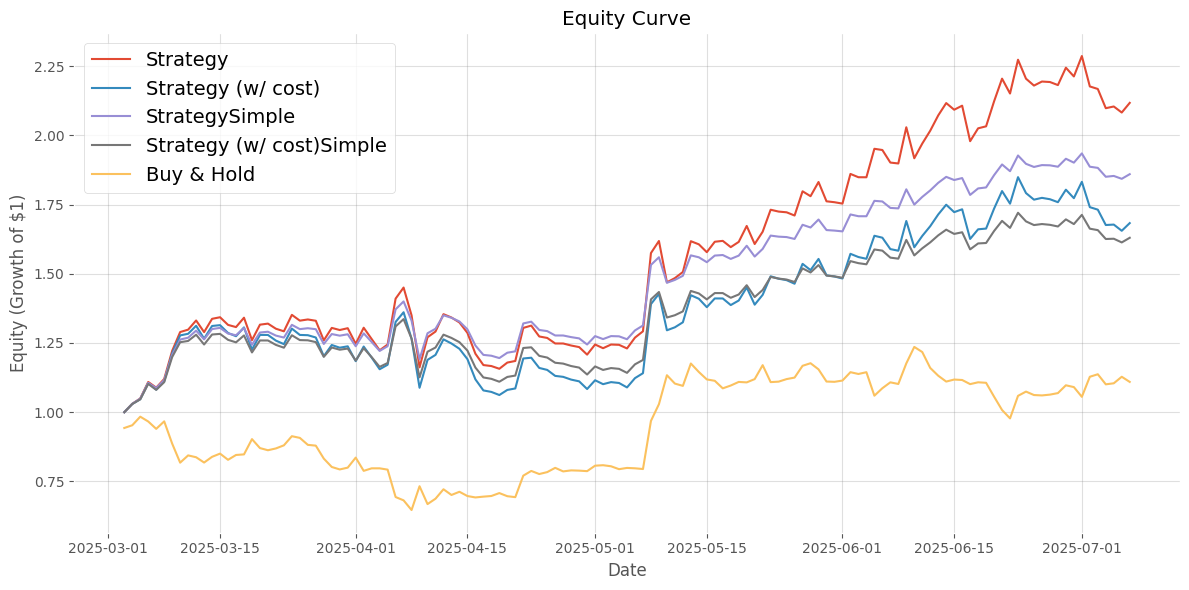

In [54]:
plot_equity_curve(dailyreturns)

 Drawdown      Start     Trough   Recovery
-0.301478 2025-04-07 2025-04-21 2025-05-09
-0.164161 2025-05-09 2025-05-12 2025-05-27
-0.147614 2025-03-11 2025-04-04 2025-04-07
-0.119116 2025-06-24 2025-07-06 2025-07-07
-0.108073 2025-06-13 2025-06-17 2025-06-21


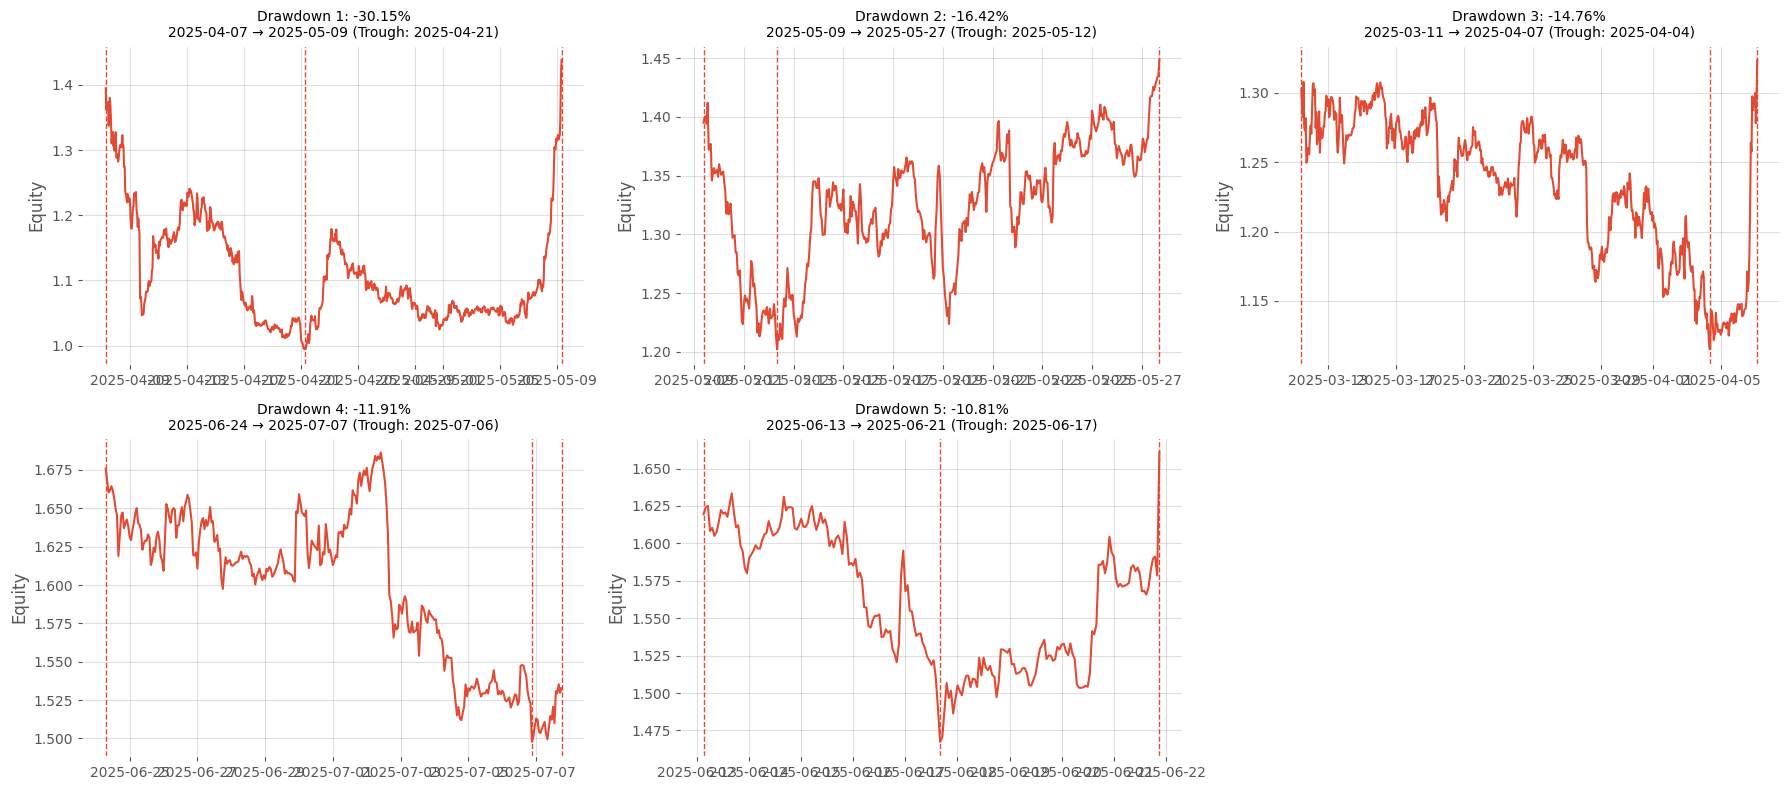

In [55]:
dd_tbl, equity_curve, dd_series = top_drawdowns_code1_strict(TradingStrategy, "Strategy_w_cost", top_n=5)
print_plot_drawdown(dd_tbl, equity_curve, dd_series)

In [56]:
report = BacktestReport(dailyreturns[["DailySimpleStrategy"]])
metrics = report.compute_metrics()
print(pd.Series(metrics))

Start                     2025-03-03 00:00:00
End                       2025-07-07 00:00:00
Duration                    126 days 00:00:00
Equity Final [$]                     2.362647
Equity Peak [$]                      2.546525
Return [%]                         136.264747
Return (Ann.) [%]                 1083.462196
Volatility (Ann.) [%]               79.604595
Sharpe Ratio                         3.104129
Sortino Ratio                       22.800342
Calmar Ratio                        57.578768
Max. Drawdown [%]                  -18.817044
Avg. Drawdown [%]                   -4.611895
Max. Drawdown Duration        0 days 00:00:00
Avg. Drawdown Duration        4 days 00:00:00
dtype: object


### HTML

In [57]:
# import plotly.io as pio
# from pathlib import Path
# from html import escape

# def export_plotly_dashboard(
#     figures: dict,
#     outfile: str = "trading_dashboard.html",
#     title: str = "Trading Dashboard",
#     *,
#     js_mode: str = "inline_once"  # "inline_once" | "cdn_once" | "external"
# ):
#     """
#     figures: dict[str, plotly.graph_objects.Figure]
#     js_mode:
#       - "inline_once": Embed the correct Plotly JS (exact veccion) inline in the FIRST figure only. (recommended)
#       - "cdn_once":    Load a specific CDN URL once (pass via include_plotlyjs='<url>'); safer than 'latest'.
#       - "external":    Do NOT include Plotly JS in fragments; you must add a <script src=...> yourself.
#     """
#     fragments = {}
#     first = True
#     for name, fig in figures.items():
#         if js_mode == "inline_once":
#             include_js = True if first else False
#         elif js_mode == "cdn_once":
#             # Pin to the exact URL you prefer, e.g. 'https://cdn.plot.ly/plotly-2.35.2.min.js'
#             # If you don't know the exact veccion, use inline_once instead.
#             include_js = "https://cdn.plot.ly/plotly-2.35.2.min.js" if first else False
#         else:  # "external" (not recommended unless you control the shell tag)
#             include_js = False

#         html = pio.to_html(
#             fig,
#             include_plotlyjs=include_js,
#             full_html=False,
#             config={"displaylogo": False}
#         )
#         fragments[name] = html
#         first = False

#     # Build tabs + panels (NO external 'plotly-latest' script tag!)
#     tabs_html = []
#     panels_html = []
#     for i, (name, html) in enumerate(fragments.items()):
#         tab_id = f"tab{i}"
#         checked = "checked" if i == 0 else ""
#         tabs_html.append(
#             f'<input type="radio" name="tabs" id="{tab_id}" {checked}>'
#             f'<label for="{tab_id}">{escape(str(name))}</label>'
#         )
#         panels_html.append(f"<section>{html}</section>")

#     css_rules = "".join(
#         [
#             f'.tabs > input#tab{i}:checked ~ .panels > section:nth-of-type({i+1})'+'{ display:block; }'
#             for i in range(len(panels_html))
#         ]
#     )

#     html_doc = f"""<!doctype html>
# <html lang="en">
# <head>
# <meta charset="utf-8">
# <title>{escape(title)}</title>
# <meta name="viewport" content="width=device-width, initial-scale=1">
# <style>
#   :root {{
#     --bg: #0b1020; --fg: #eaeefb; --muted: #9aa3b2; --tab: #1b2340; --tab-active: #2a3560;
#   }}
#   html, body {{ margin:0; padding:0; background:var(--bg); color:var(--fg); font-family: system-ui, -apple-system, Segoe UI, Roboto, sans-serif; }}
#   header {{ padding:16px 20px; font-size:20px; font-weight:600; border-bottom:1px solid #223; position:sticky; top:0; background:var(--bg); z-index:10; }}
#   .tabs {{ display:flex; flex-wrap:wrap; gap:8px; padding:12px 16px; border-bottom:1px solid #223; position:sticky; top:56px; background:var(--bg); z-index:9; }}
#   .tabs > input[type="radio"] {{ display:none; }}
#   .tabs > label {{ padding:8px 12px; background:var(--tab); border-radius:10px; cursor:pointer; color:var(--muted); }}
#   .tabs > input[type="radio"]:checked + label {{ background:var(--tab-active); color:var(--fg); box-shadow:0 0 0 1px #334; }}
#   .panels {{ padding:12px 16px; }}
#   .panels > section {{ display:none; }}
#   {css_rules}
#   /* size the plot containers; Plotly will autosize within */
#   .panels .js-plotly-plot {{ width:100% !important; height:72vh !important; }}
#   @media (max-width: 900px) {{
#     .panels .js-plotly-plot {{ height:70vh !important; }}
#   }}
# </style>
# </head>
# <body>
# <header>{escape(title)}</header>
# <div class="tabs">
#   {''.join(tabs_html)}
#   <div class="panels">
#     {''.join(panels_html)}
#   </div>
# </div>
# </body>
# </html>"""

#     Path(outfile).write_text(html_doc, encoding="utf-8")
#     return str(Path(outfile).resolve())

In [58]:
# # build your figures (examples)
# fig_price = plot_price_trades_interactive(TradingStrategy)  # or your own price figure
# metrics = report.compute_metrics()
# # fig_signal = plot_price_signaly(IndicatorDF, use_candles=False, show=False)

# fig_metrics = make_metrics_table_figure(metrics)

# path = export_plotly_dashboard(
#     {
#         "Price & Trades": fig_price,
#         "Backtest Metrics": fig_metrics,
#         # "Price + CCI": fig_signal,
#         # add more: "ATR": fig_atr, "P&L": fig_pnl, ...
#     },
#     outfile="alpha_dashboard.html",
#     title="AlphaDogsResearch – Backtest Dashboard"
# )
# print("Saved to:", path)
# # On macOS you can open it:
# import webbrowser; webbrowser.open(f"file://{path}")

In [59]:
# import plotly.io as pio
# import plotly.graph_objects as go
# from pathlib import Path
# from html import escape
# import pandas as pd

# def export_plotly_report(
#     sections: dict,
#     outfile: str = "trading_report.html",
#     title: str = "Trading Report",
#     *,
#     js_mode: str = "inline_once"  # "inline_once" | "cdn_once" | "external"
# ):
#     """
#     sections: dict[str, go.Figure | str]
#       Keys = section headers
#       Values = Plotly figures OR raw HTML strings (e.g. DataFrame.to_html())
#     """
#     fragments = []
#     first = True
#     for name, content in sections.items():
#         # Section title
#         fragments.append(f"<h2>{escape(name)}</h2>")
#         if isinstance(content, go.Figure):
#             if js_mode == "inline_once":
#                 include_js = True if first else False
#             elif js_mode == "cdn_once":
#                 include_js = "https://cdn.plot.ly/plotly-2.35.2.min.js" if first else False
#             else:
#                 include_js = False

#             html = pio.to_html(
#                 content,
#                 include_plotlyjs=include_js,
#                 full_html=False,
#                 config={"displaylogo": False}
#             )
#             fragments.append(html)
#             first = False
#         else:
#             # Assume string is raw HTML fragment
#             fragments.append(str(content))

#     html_doc = f"""<!doctype html>
# <html lang="en">
# <head>
# <meta charset="utf-8">
# <title>{escape(title)}</title>
# <meta name="viewport" content="width=device-width, initial-scale=1">
# <style>
#   body {{
#     margin:0; padding:20px;
#     background:#0b1020; color:#eaeefb;
#     font-family: system-ui, -apple-system, Segoe UI, Roboto, sans-serif;
#   }}
#   h1 {{ font-size:28px; margin-bottom:10px; }}
#   h2 {{ margin-top:40px; margin-bottom:20px; border-bottom:1px solid #223; padding-bottom:4px; }}
#   .js-plotly-plot {{ width:100% !important; height:70vh !important; margin-bottom:40px; }}
#   table.dataframe {{
#     width:100%; border-collapse:collapse; margin-bottom:40px;
#     background:#0d1328; border-radius:12px; overflow:hidden;
#   }}
#   table.dataframe th, table.dataframe td {{
#     padding:8px 10px; border-bottom:1px solid #223; color:#d9e1f2; text-align:left;
#   }}
#   table.dataframe thead th {{
#     background:#1b2340; color:#eaeefb; position:sticky; top:0;
#   }}
# </style>
# </head>
# <body>
# <h1>{escape(title)}</h1>
# {''.join(fragments)}
# </body>
# </html>"""

#     Path(outfile).write_text(html_doc, encoding="utf-8")
#     return str(Path(outfile).resolve())


# # --- Helper to convert metrics dict/Series to HTML ---
# def metrics_to_html(metrics, title="Backtest Metrics"):
#     s = pd.Series(metrics) if not isinstance(metrics, pd.Series) else metrics
#     df = s.rename("Value").to_frame()
#     df_fmt = df.copy()
#     df_fmt["Value"] = df_fmt["Value"].apply(
#         lambda v: f"{v:.4f}" if isinstance(v, (int, float)) and pd.notna(v)
#         else ("" if pd.isna(v) else str(v))
#     )
#     return "<h3>{}</h3>{}".format(escape(title), df_fmt.to_html(classes="dataframe", border=0))

In [60]:
# report = BacktestReport(dailyreturns[["DailySimpleStrategy"]])
# metrics = report.compute_metrics()

# # Convert metrics to HTML
# metrics_html = metrics_to_html(metrics)

# # Suppose you already have fig_price and fig_cci (Plotly figures)
# path = export_plotly_report(
#     {
#         "Price & Trades": fig_price,
#         "Backtest Metrics": metrics_html
#     },
#     outfile="trading_report.html",
#     title="Trading Dashboard"
# )

# print("Saved to:", path)
# # On macOS you can open it:
# import webbrowser; webbrowser.open(f"file://{path}")

### Optimization Function

In [61]:
import numpy as np
import pandas as pd
from typing import Tuple

# ──────────────────────────────────────────────────────────────────────────────
# 1) MAX-HOLDING: iteratively zero boundary bars in the *base* signal
#    (capped by sign; recompute runs until no run exceeds cap)
# ──────────────────────────────────────────────────────────────────────────────
def cap_runs_iterative_update_base(
    base_signal: pd.Series,
    max_holding_val: int,
    max_iters: int = 10000
) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """
    Edit the *base* signal by zeroing ONLY boundary bars where run-length by sign
    would exceed `max_holding_val`. Rebuild positions via ffill()->0 each loop
    until no more breaches.

    Returns:
        edited_base: pd.Series  - the modified base signal (with boundary bars zeroed)
        positions:   pd.Series  - positions reconstructed from edited_base (ffill -> 0)
        action:      pd.Series  - +1 buy / -1 sell on capped boundary bars, 0 elsewhere
                                  (sell when capping a long, buy when capping a short)
    """
    sig = pd.to_numeric(base_signal, errors="coerce").copy()
    # action = pd.Series(np.nan, index=sig.index, dtype=int)
    action = sig.copy()

    # flags that ONLY mark capped bars (do not mirror full action series)
    exit_max_holding_long  = pd.Series(False, index=sig.index)
    exit_max_holding_short = pd.Series(False, index=sig.index)
    
    for _ in range(max_iters):
        # positions from current edited base
        pos = sig.ffill().fillna(0)
        sgn = np.sign(pos).astype(int)

        # segment IDs whenever sign changes (incl. between 0/non-zero)
        seg_id = (sgn != sgn.shift()).cumsum()

        # run-length within non-zero segments
        run = sgn.ne(0).groupby(seg_id).cumsum()

        # bars that would exceed the cap
        over = run > max_holding_val
        if not over.any():
            return sig, pos, action, exit_max_holding_long, exit_max_holding_short

        # zero exactly the first bar that exceeds the cap for each run
        boundary = over & (run.shift(1).fillna(0) == max_holding_val)

        if not boundary.any():
            # safety: if something odd happens, stop
            return sig, pos, action, exit_max_holding_long, exit_max_holding_short

        # record actions at boundary:
        # if currently long (+1), we must SELL (-1); if short (-1), we must BUY (+1)
        action.loc[boundary] = (-sgn.loc[boundary]).astype(int)

        # Update flags ONLY at those boundary bars, by direction being capped
        exit_max_holding_long  |= (boundary & (sgn == 1))   # capping a long
        exit_max_holding_short |= (boundary & (sgn == -1))  # capping a short
        
        # enforce the cap by forcing the base signal flat at boundary
        sig.loc[boundary] = 0

    # if we somehow didn’t converge
    raise RuntimeError("max_iters reached before capping stabilized")

# ──────────────────────────────────────────────────────────────────────────────
# 2) STOP-LOSS: update the *base* signal using explicit entry edges
#    (sparse base convention; re-entry only on fresh edges)
# ──────────────────────────────────────────────────────────────────────────────
def stop_loss_update_base(
    base_sig: pd.Series,
    close: pd.Series,
    stop_loss_val: float = 0.10,
    cooldown_bars: int = 0,
    allow_flip: bool = True,
    # edge_source: pd.Series | None = None,
    entry_long_edge: pd.Series | None = None,
    entry_short_edge: pd.Series | None = None,
    exit_max_holding_long: pd.Series | None = None,
    exit_max_holding_short: pd.Series | None = None
) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """
    Sparse-base convention:
      • write +1/-1 ONLY on entry bars (fresh edges)
      • write 0 ONLY on SL bars (and cooldown bars, if any)
      • write NaN on all other bars
    Final executed Positions = out_sig.ffill().fillna(0).
    Prefers explicit `entry_long_edge` / `entry_short_edge`. If not provided,
    falls back to edges inferred from a frozen `edge_source`.
    """
    base_sig = pd.to_numeric(base_sig, errors="coerce")
    close    = pd.to_numeric(close,    errors="coerce")

    entry_long_edge  = entry_long_edge.fillna(False)
    entry_short_edge = entry_short_edge.fillna(False)
    exit_max_holding_long = exit_max_holding_long.fillna(False)
    exit_max_holding_short = exit_max_holding_short.fillna(False)

    out_sig = base_sig.copy()                  # sparse base we will write to
    sl_hit  = pd.Series(False, index=base_sig.index)  # flags where SL triggers

    curr_pos = 0
    entry_px = None
    cooldown_left = 0

    for i in range(len(base_sig)):
        px = close.iloc[i]
        e_long  = bool(entry_long_edge.iloc[i])
        e_short = bool(entry_short_edge.iloc[i])
        exit_max_hold_long = bool(exit_max_holding_long.iloc[i])
        exit_max_hold_short = bool(exit_max_holding_short.iloc[i])

        # Cooldown → explicit 0 each bar of cooldown
        if cooldown_left > 0:
            out_sig.iloc[i] = 0
            cooldown_left -= 1
            curr_pos = 0; entry_px = None
            continue

        if exit_max_hold_long:
            out_sig.iloc[i] = 0; curr_pos = 0
            continue

        if exit_max_hold_short:
            out_sig.iloc[i] = 0; curr_pos = 0
            continue

        if curr_pos == 0:
            # ONLY enter on fresh edges; otherwise keep sparse NaN
            if e_long:
                out_sig.iloc[i] =  1; curr_pos =  1; entry_px = px
            elif e_short:
                out_sig.iloc[i] = -1; curr_pos = -1; entry_px = px
            else:
                out_sig.iloc[i] = np.nan
            continue

        # In a position: stop checks
        if curr_pos > 0 and px <= entry_px * (1 - stop_loss_val):
            out_sig.iloc[i] = 0; sl_hit.iloc[i] = True
            curr_pos = 0; entry_px = None; cooldown_left = cooldown_bars
            continue

        if curr_pos < 0 and px >= entry_px * (1 + stop_loss_val):
            out_sig.iloc[i] = 0; sl_hit.iloc[i] = True
            curr_pos = 0; entry_px = None; cooldown_left = cooldown_bars
            continue

        # Not stopped: flip only on flip-edge; otherwise keep sparse NaN
        if curr_pos > 0:
            if allow_flip and e_short:
            # if allow_flip and f_short:
                out_sig.iloc[i] = -1; curr_pos = -1; entry_px = px
                continue
            # else:
            #     out_sig.iloc[i] = np.nan
        
        if curr_pos < 0:
            if allow_flip and e_long:
                out_sig.iloc[i] = 1; curr_pos = 1; entry_px = px
                continue
        else:
            out_sig.iloc[i] = np.nan

    pos_out = out_sig.ffill().fillna(0)
    return out_sig, pos_out, sl_hit


# ──────────────────────────────────────────────────────────────────────────────
# 3) PIPELINE: TradingStrategy_optimised
#    - expects SignalDF from your signal_generation() (has Positions_base, EdgeLong, EdgeShort)
#    - applies max-holding (edit base) → stop-loss (edit base) → builds executed Positions
# ──────────────────────────────────────────────────────────────────────────────
def TradingStrategy_optimised(
    SignalDF: pd.DataFrame,
    max_holding: bool = False,
    max_holding_val: int = 300,
    stop_loss: bool = False,
    stop_loss_val: float = 0.10,
    cooldown_bars: int = 0,
    allow_flip: bool = True
) -> pd.DataFrame:

    ts = SignalDF.copy()

    # Canonical base (sparse) & edges from signal_generation
    if "Positions_base" not in ts.columns:
        # fallback: treat Positions as base if needed
        ts["Positions_base"] = pd.to_numeric(ts.get("Positions", pd.Series(index=ts.index, dtype=float)),
                                             errors="coerce")

    base_sig_raw = pd.to_numeric(ts["Positions_base"], errors="coerce")
    close_series = pd.to_numeric(ts["Close"], errors="coerce")

    # Explicit edges preferred (ensure boolean dtype)
    edge_long  = ts.get("EdgeLong")
    edge_short = ts.get("EdgeShort")
    if edge_long is None or edge_short is None:
        # Fallback: derive from raw base if edges missing
        raw_pos   = base_sig_raw.ffill().fillna(0)
        raw_sign  = np.sign(raw_pos); prev_sign = raw_sign.shift(1).fillna(0)
        edge_long  = (raw_sign > 0) & (prev_sign == 0)
        edge_short = (raw_sign < 0) & (prev_sign == 0)
    edge_long  = edge_long.fillna(False)
    edge_short = edge_short.fillna(False)

    # 1) Max-holding (edit the base, not the executed positions)
    if max_holding:
        base_sig_capped, pos_after_cap, max_action, exit_max_holding_long, exit_max_holding_short \
            = cap_runs_iterative_update_base(base_sig_raw, max_holding_val)
    else:
        base_sig_capped = base_sig_raw.copy()
        pos_after_cap   = base_sig_capped.ffill().fillna(0)

    # 2) Stop-loss (edit the capped base; re-entry only on fresh edges)
    if stop_loss:
        base_sig_sl, final_positions, sl_hit = stop_loss_update_base(
            base_sig=max_action,
            close=close_series,
            stop_loss_val=stop_loss_val,
            cooldown_bars=cooldown_bars,
            allow_flip=allow_flip,
            entry_long_edge=edge_long,
            entry_short_edge=edge_short,
            exit_max_holding_long = exit_max_holding_long,
            exit_max_holding_short = exit_max_holding_short
        )
    else:
        base_sig_sl     = base_sig_capped.copy()
        final_positions = pos_after_cap
        sl_hit          = pd.Series(False, index=ts.index)

    # Persist sparse base & executed positions
    # final_positions = pos_after_cap
    ts["Max_hold_long_exit"] = exit_max_holding_long
    ts["Max_hold_short_exit"] = exit_max_holding_short
    ts["Action_capped"] = max_action
    ts["Positions_capped"] = base_sig_capped
    ts["Positions_base_sl"] = base_sig_sl                # sparse: ±1 only on entries, 0 only on exits/SL, NaN elsewhere
    ts["Positions_base_sl"] = ts["Positions_base_sl"].fillna(ts["Positions_base"])
    ts["Positions"]      = final_positions            # executed: ffill().fillna(0)
    ts["SL_Hit"]         = sl_hit

    # Actions & event flags (AFTER exits)
    prev_pos = ts["Positions"].shift(1).fillna(0)
    delta    = ts["Positions"] - prev_pos
    ts["Action"] = delta.fillna(0)
    if len(ts) > 0:
        ts["Action"].iat[0] = 0

    pos = ts["Positions"]
    ts["EntryLong"]   = (delta > 0) & (pos > 0) & (prev_pos == 0)
    ts["ExitShort"]   = (delta > 0) & (pos == 0) & (prev_pos < 0)
    ts["EntryShort"]  = (delta < 0) & (pos < 0) & (prev_pos == 0)
    ts["ExitLong"]    = (delta < 0) & (pos == 0) & (prev_pos > 0)
    ts["FlipToLong"]  = (prev_pos < 0) & (pos > 0)
    ts["FlipToShort"] = (prev_pos > 0) & (pos < 0)

    # PnL
    ts["Returns"]  = np.log(close_series / close_series.shift(1)).fillna(0)
    ts["Strategy"] = ts["Returns"] * prev_pos

    TradingCost_local = globals().get("TradingCost", 0.0)
    if TradingCost_local:
        log_cost = np.log(1 - TradingCost_local)
        ts["Strategy_w_cost"] = ts["Strategy"] + np.where(ts["Action"] != 0,
                                                          log_cost * np.abs(ts["Action"]), 0)
    else:
        ts["Strategy_w_cost"] = ts["Strategy"]

    return ts

In [62]:
# ts_test = TradingStrategy_optimised(
#     SignalDF=SignalDF,
#     max_holding = True,
#     max_holding_val = 2,
#     stop_loss = True, stop_loss_val = 0.05,
#     cooldown_bars = 0, allow_flip = True)

In [63]:
# pd.set_option('display.max_columns', None)

In [64]:
# ts_test.iloc[180:280]

In [65]:
cci_period = 13
TradingCost = 0.0005
cci_upper = 50
cci_lower = -50 #-113
cci_mid = 12 
long_action = 1
short_action = -1
max_holding = True
max_holding_val = 100
stop_loss = True
stop_loss_val = 0.01
mode = 'momentum'
exit_mode = 'breakout'

### Optimization outputs

In [66]:
PriceDF = df_1h["2021-01-01 00:00:00":] # df_1h

In [67]:
# cluster_bests

In [68]:
i = 0

try:
    cci_period = (cluster_bests['cci_period'][i]).astype(int)
    cci_upper = (cluster_bests['cci_upper'][i]).astype(int)
    cci_lower = (cluster_bests['cci_lower'][i]).astype(int)
    cci_mid = (cluster_bests['cci_mid'][i]).astype(int)
    long_action = 1
    short_action = -1
    max_holding = bool(cluster_bests['max_holding'][i])
    max_holding_val = (cluster_bests['max_holding_val'][i]).astype(int)
    stop_loss = bool(cluster_bests['stop_loss'][i])
    stop_loss_val = (cluster_bests['stop_loss_val'][i]).astype(float)
    exit_mode = str(cluster_bests['exit_mode'][i])
    mode = str(cluster_bests['mode'][i])

except NameError:
    cci_period = 14
    TradingCost = 0.0005
    cci_upper = 5
    cci_lower = -5
    cci_mid = 0 
    long_action = 1
    short_action = -1
    max_holding = False
    max_holding_val = 488
    stop_loss = False
    stop_loss_val = 0.201718299409196
    mode = 'mean_reversion'
    exit_mode = 'midpoint'



In [69]:
cci_period = 14
TradingCost = 0.0005
cci_upper = 205
cci_lower = -101
cci_mid = 12 
long_action = 1
short_action = -1
max_holding = True
max_holding_val = 25
stop_loss = True
stop_loss_val = 0.074
mode = 'momentum'
exit_mode = 'midpoint'

In [70]:
## DF reset 
IndicatorDF = CCIIndicator(PriceDF, cci_period)
SignalDF = signal_generation(IndicatorDF, mode = mode, exit_mode = exit_mode,
                             long_action = long_action, short_action = short_action) # mode = "mean_reversion" or "momentum", exit_mode = "midpoint" or "breakout"
TradingStrategy = TradingStrategy_optimised(SignalDF, max_holding = max_holding, max_holding_val = max_holding_val, stop_loss = stop_loss, stop_loss_val = stop_loss_val, cooldown_bars = 0, allow_flip = True)

In [71]:
short_action

-1

In [72]:
stop_loss_val

0.074

In [73]:
TradingStrategy.iloc[:200]

Open     High      Low    Close         CCI  \
Datetime                                                              
2021-01-01 14:00:00   743.12   745.03   738.51   739.61    2.363588   
2021-01-01 15:00:00   739.61   741.47   735.01   737.75  -49.081953   
2021-01-01 16:00:00   737.75   739.35   734.82   737.79  -55.547266   
2021-01-01 17:00:00   737.79   738.30   729.16   729.69 -148.153756   
2021-01-01 18:00:00   729.69   733.79   716.04   725.85 -229.651061   
...                      ...      ...      ...      ...         ...   
2021-01-09 17:00:00  1205.00  1229.31  1204.11  1224.09   26.785256   
2021-01-09 18:00:00  1224.09  1238.88  1222.98  1228.50   84.636515   
2021-01-09 19:00:00  1228.50  1241.23  1225.13  1233.71   93.450445   
2021-01-09 20:00:00  1233.71  1284.56  1223.42  1278.85  240.578443   
2021-01-09 21:00:00  1278.85  1305.36  1270.10  1292.57  288.303340   

                     Positions  Positions_base  EdgeLong  EdgeShort  \
Datetime                                                              
2021-01-01 14:00:00        0.0             NaN     False      False   
2021-01-01 15:00:00        0.0             NaN     False      False   
2021-01-01 16:00:00        0.0             NaN     False      False   
2021-01-01 17:00:00       -1.0            -1.0     False       True   
2021-01-01 18:00:00       -1.0             NaN     False      False   
...                        ...             ...       ...        ...   
2021-01-09 17:00:00        0.0             0.0     False      False   
2021-01-09 18:00:00        0.0             NaN     False      False   
2021-01-09 19:00:00        0.0             NaN     False      False   
2021-01-09 20:00:00        0.0             1.0      True      False   
2021-01-09 21:00:00        0.0             NaN     False      False   

                     Max_hold_long_exit  ...  Action  EntryLong  ExitShort  \
Datetime                                 ...                                 
2021-01-01 14:00:00               False  ...     0.0      False      False   
2021-01-01 15:00:00               False  ...     0.0      False      False   
2021-01-01 16:00:00               False  ...     0.0      False      False   
2021-01-01 17:00:00               False  ...    -1.0      False      False   
2021-01-01 18:00:00               False  ...     0.0      False      False   
...                                 ...  ...     ...        ...        ...   
2021-01-09 17:00:00               False  ...     0.0      False      False   
2021-01-09 18:00:00               False  ...     0.0      False      False   
2021-01-09 19:00:00               False  ...     0.0      False      False   
2021-01-09 20:00:00               False  ...     0.0      False      False   
2021-01-09 21:00:00               False  ...     0.0      False      False   

                     EntryShort  ExitLong  FlipToLong  FlipToShort   Returns  \
Datetime                                                                       
2021-01-01 14:00:00       False     False       False        False  0.000000   
2021-01-01 15:00:00       False     False       False        False -0.002518   
2021-01-01 16:00:00       False     False       False        False  0.000054   
2021-01-01 17:00:00        True     False       False        False -0.011039   
2021-01-01 18:00:00       False     False       False        False -0.005276   
...                         ...       ...         ...          ...       ...   
2021-01-09 17:00:00       False     False       False        False  0.015718   
2021-01-09 18:00:00       False     False       False        False  0.003596   
2021-01-09 19:00:00       False     False       False        False  0.004232   
2021-01-09 20:00:00       False     False       False        False  0.035935   
2021-01-09 21:00:00       False     False       False        False  0.010671   

                     Strategy  Strategy_w_cost  
Datetime                                        
2021-01-01 14:00:00  0

In [74]:
counter_series, ts = trade_count(TradingStrategy)

In [75]:
# counter_series.iloc[:200]
counter_series.tail(100)

Datetime
2025-07-03 15:00:00    1773.0
2025-07-03 16:00:00    1773.0
2025-07-03 17:00:00    1773.0
2025-07-03 18:00:00    1773.0
2025-07-03 19:00:00    1773.0
                        ...  
2025-07-07 14:00:00    1778.0
2025-07-07 15:00:00    1778.0
2025-07-07 16:00:00    1778.0
2025-07-07 17:00:00    1778.0
2025-07-07 18:00:00    1778.0
Name: Positions, Length: 100, dtype: Float64

In [76]:

summarydf = summary_metrics(ts)
summarydf_annual = summary_metrics_annual(ts)
dailyreturns = ConvertToDailyReturns(ts, initial_capital=1)

In [77]:
## DF reset 
IndicatorDF = CCIIndicator(PriceDF, cci_period)
SignalDF = signal_generation(IndicatorDF, mode = mode, exit_mode = exit_mode,
                             long_action = long_action, short_action = short_action) # mode = "mean_reversion" or "momentum", exit_mode = "midpoint" or "breakout"
TradingStrategy = TradingStrategy_optimised(SignalDF, max_holding = max_holding, max_holding_val = max_holding_val, stop_loss = stop_loss, stop_loss_val = stop_loss_val)
counter_series, ts = trade_count(TradingStrategy)
summarydf = summary_metrics(ts)
summarydf_annual = summary_metrics_annual(ts)
dailyreturns = ConvertToDailyReturns(ts, initial_capital=1)

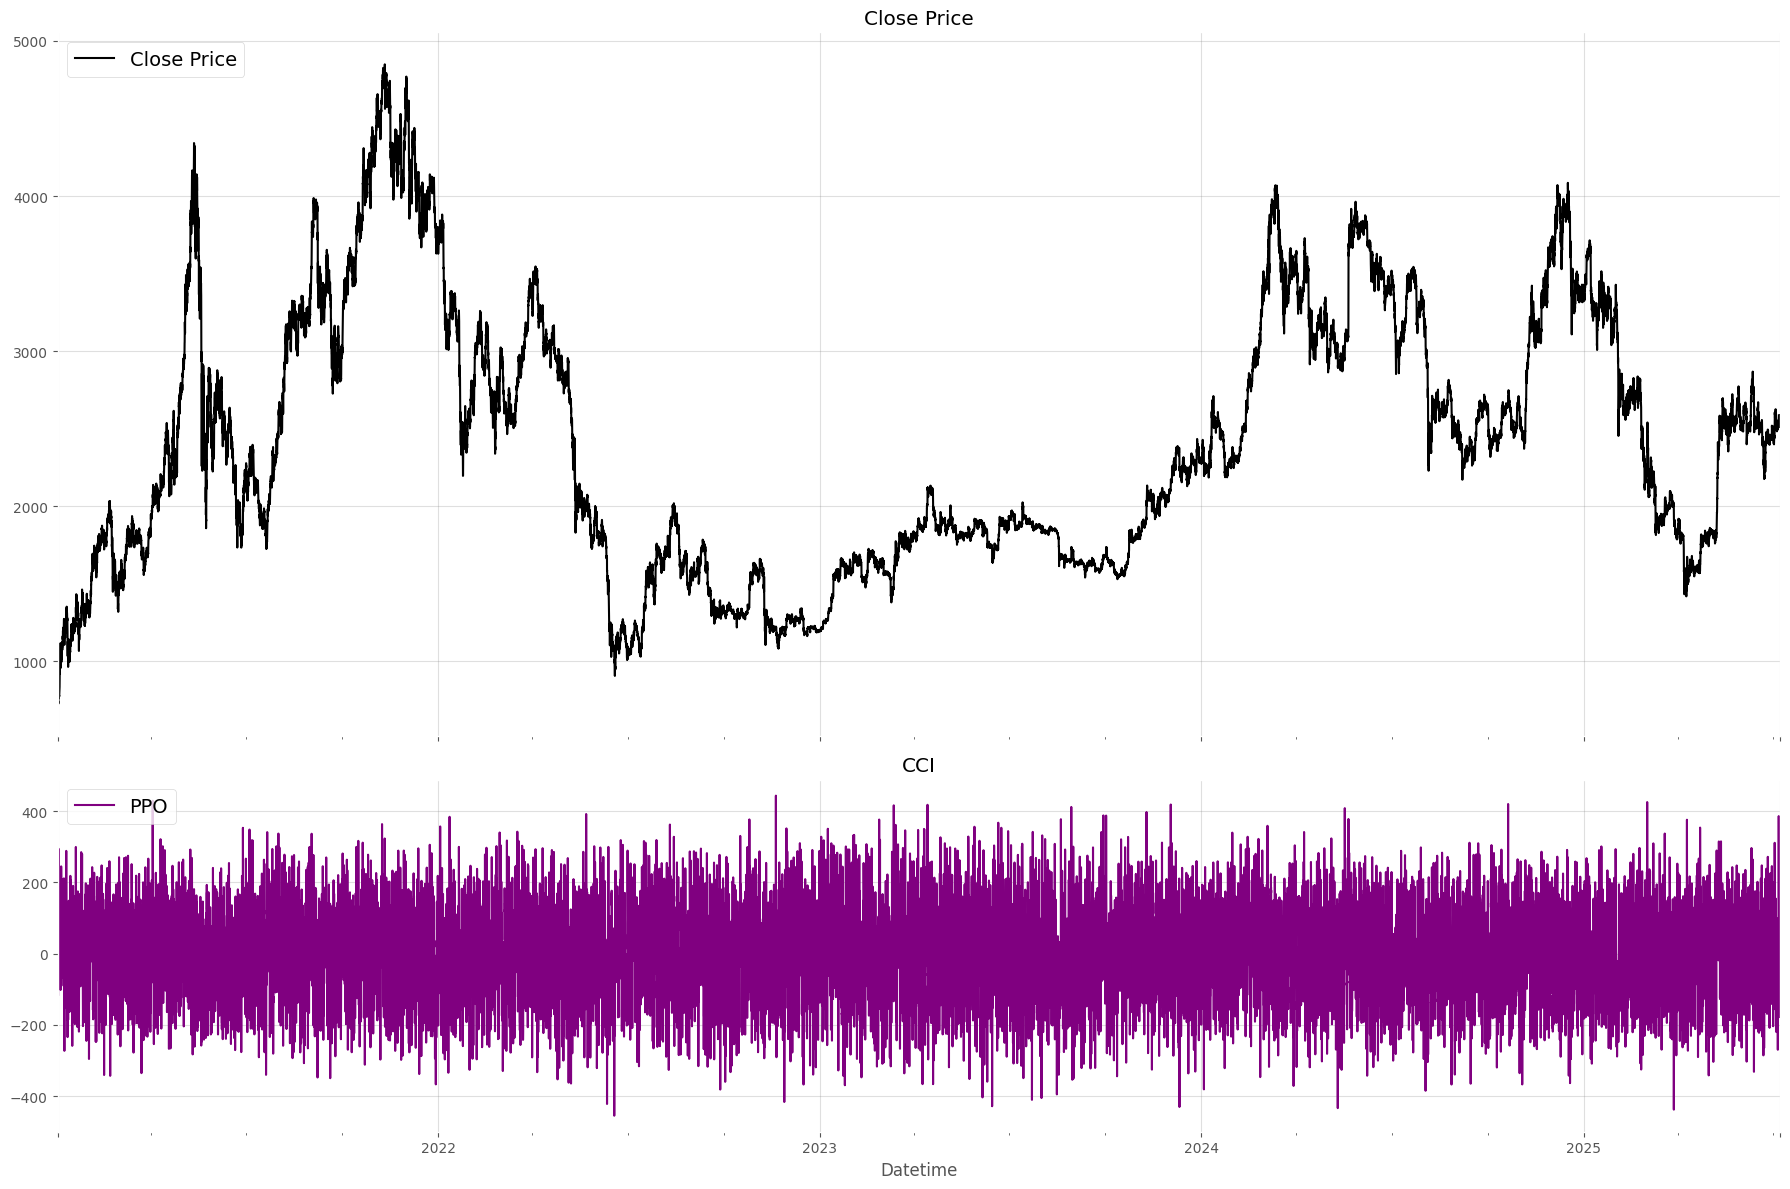

In [78]:
plot_price_signal(IndicatorDF)

In [79]:
plot_price_trades_interactive(TradingStrategy)

In [80]:
print_trade_statistic(counter_series, ts)

TradeCount          : 1778.0
PositiveCount       : 1749
NegativeCount       : 1308
TotalBars           : 24166
TotalChurnAbs       : 3555.0
TradingCostPerTrade : 0.050%
TotalTradingCost    : 177.75%
AnnTradingCost      : 64.43%
DailyTradingCost    : 0.1765%
AnnualizedChurn     : 1288.66
DailyChurn          : 3.5306


In [81]:
summarydf

ActionCount               Start                 End  Cumulative_Return  \
0               1 2021-01-01 17:00:00 2021-01-02 01:00:00          -0.004125   
1               2 2021-01-02 12:00:00 2021-01-04 09:00:00           0.253182   
2               3 2021-01-04 10:00:00 2021-01-04 13:00:00          -0.077469   
3               4 2021-01-05 00:00:00 2021-01-05 02:00:00          -0.010880   
4               5 2021-01-06 11:00:00 2021-01-07 23:00:00           0.055159   
...           ...                 ...                 ...                ...   
1773         1774 2025-07-04 05:00:00 2025-07-04 23:00:00           0.022491   
1774         1775 2025-07-05 15:00:00 2025-07-05 20:00:00           0.000122   
1775         1776 2025-07-06 10:00:00 2025-07-06 11:00:00          -0.003613   
1776         1777 2025-07-06 13:00:00 2025-07-07 09:00:00           0.004902   
1777         1778 2025-07-07 10:00:00 2025-07-07 18:00:00           0.005859   

      Volatility  Sharpe_Ratio  Action  Bars  
0       0.007628     -0.060087    -1.0     9  
1       0.022659      0.242903     1.0    46  
2       0.021907     -0.884073    -2.0     4  
3       0.020083     -0.180575     1.0     3  
4       0.014845      0.100425     1.0    37  
...          ...           ...     ...   ...  
1773    0.004934      0.239928    -2.0    19  
1774    0.002897      0.007021    -1.0     6  
1775    0.001847     -0.977833    -1.0     2  
1776    0.004753      0.049114     1.0    21  
1777    0.006497      0.100189    -2.0     9  

[1778 rows x 8 columns]

In [82]:
print_hit_rate_metrics(summarydf)

Hit Rate: 42.46%
Win/Loss Ratio: 73.80%
Slugging Ratio: 194.88%


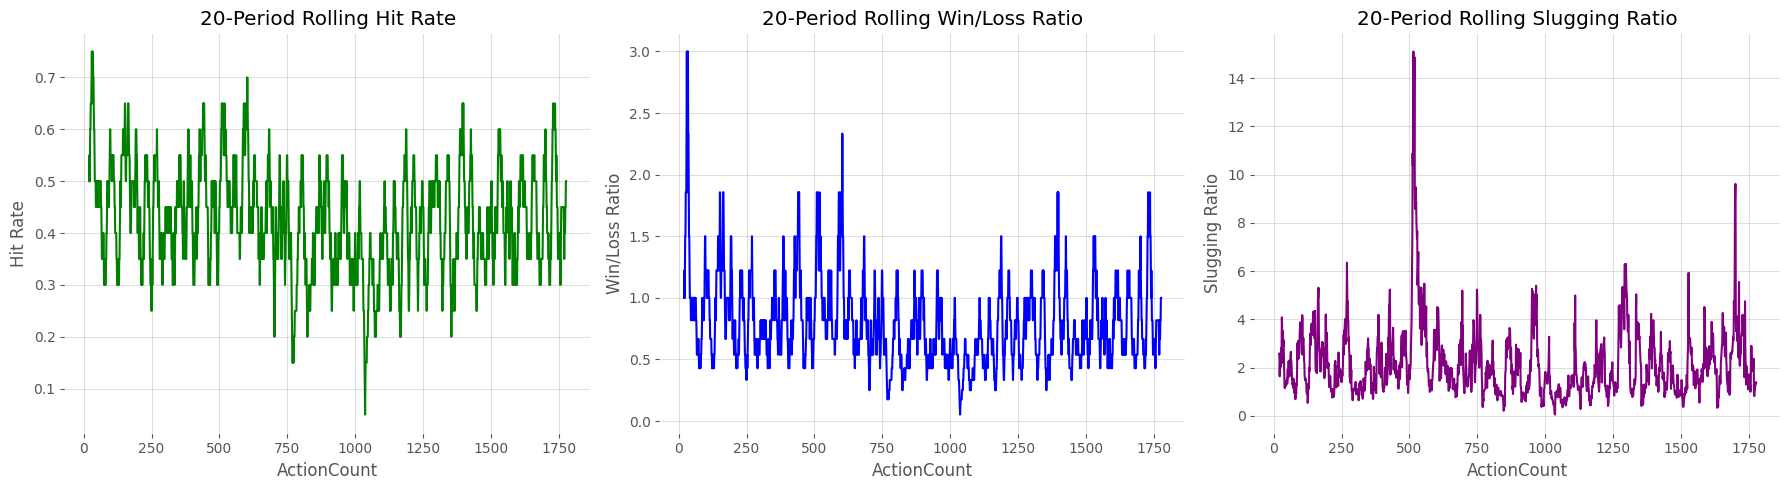

In [83]:
plot_hit_rate(summarydf)

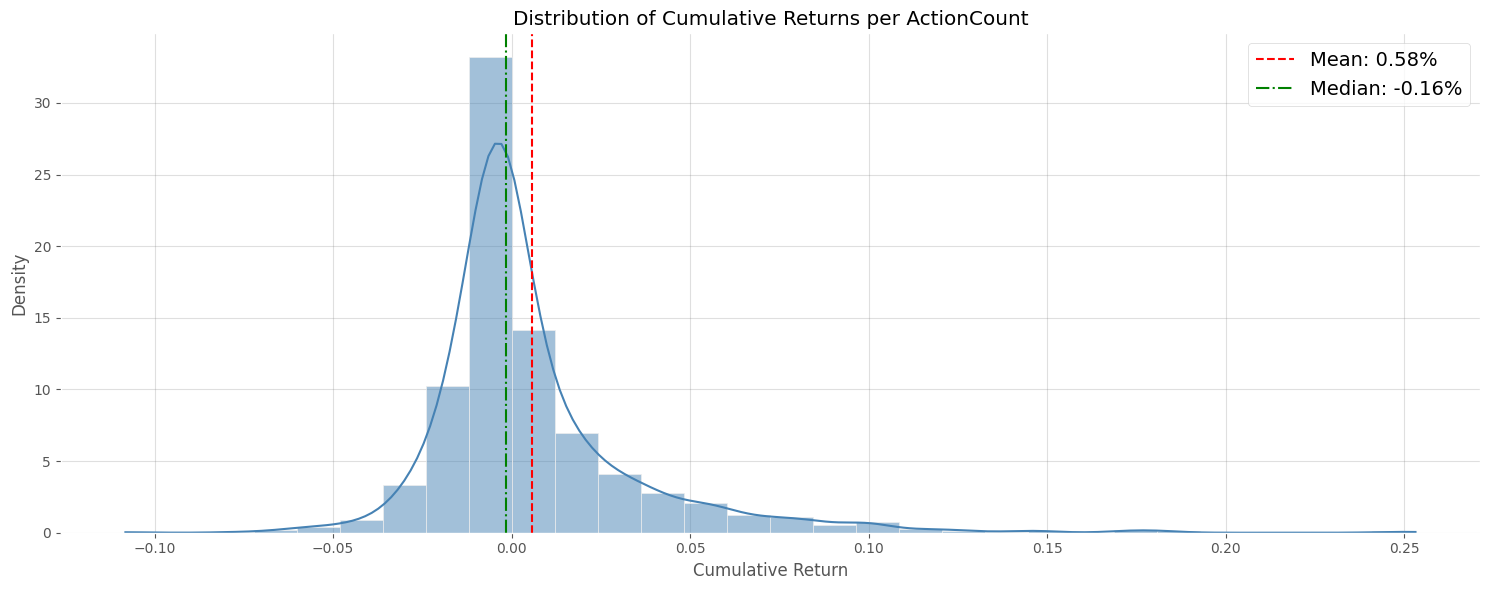

In [84]:
plot_return_distribution(summarydf)

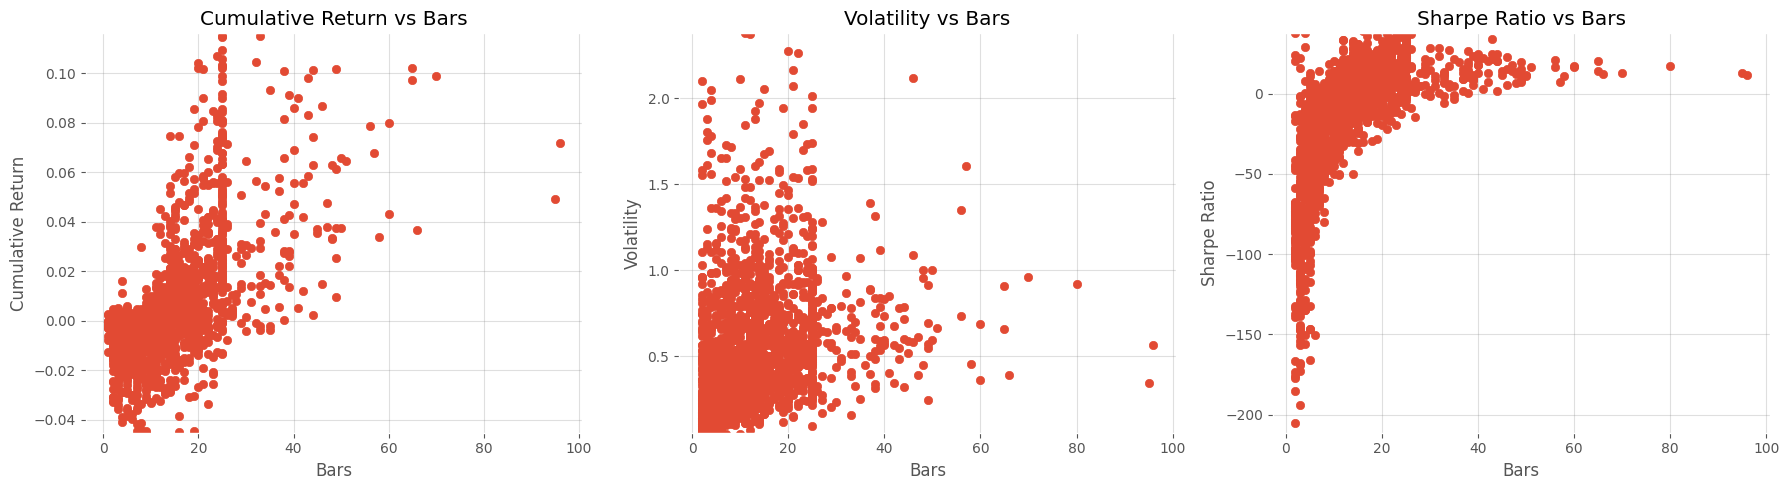

In [85]:
plot_return_scatter(summarydf_annual)

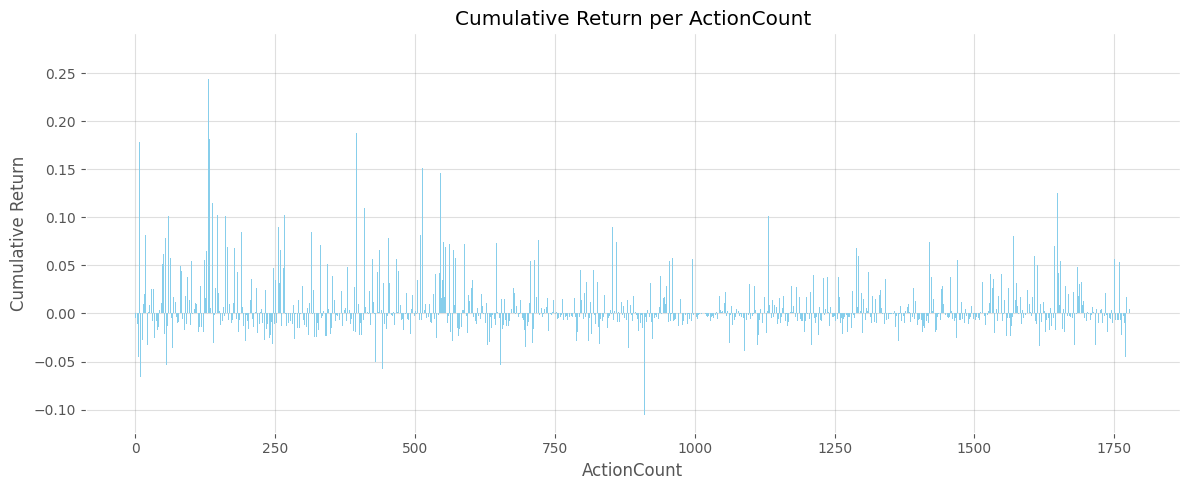

In [86]:
plot_trade_returns(summarydf_annual)

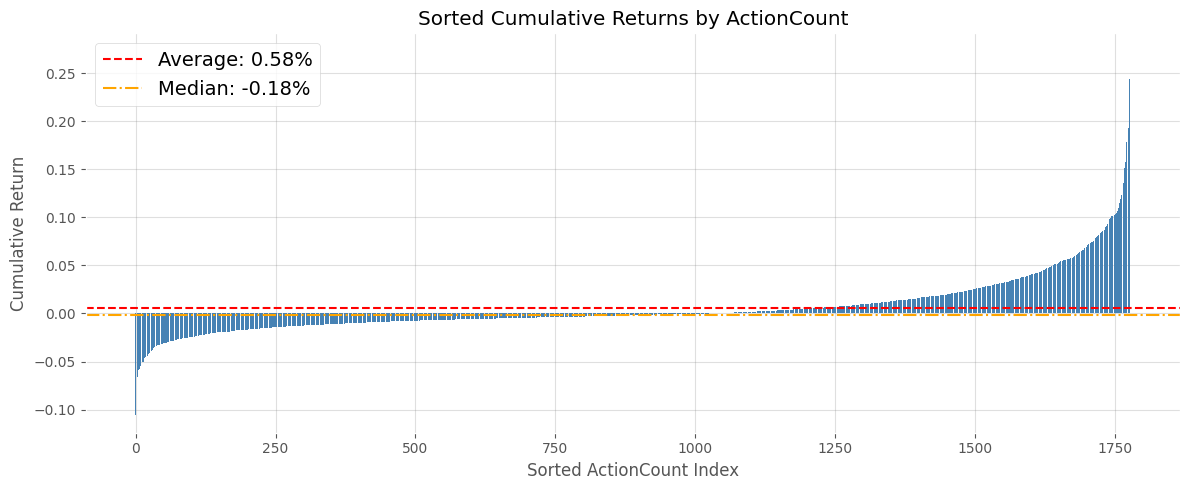

In [87]:
plot_trade_returns_sorted(summarydf_annual)

In [88]:
def plot_equity_curve(DailyStrategy):   
    # Plot
    plt.figure(figsize=(12, 6))
    # plt.plot(DailyStrategy.index, DailyStrategy["EquityStrategyCap"], label="Strategy")
    # plt.plot(DailyStrategy.index, DailyStrategy["EquityStrategyCap_w_cost"], label="Strategy (w/ cost)")
    plt.plot(DailyStrategy.index, DailyStrategy["EquityStrategyCapSimple"], label="StrategySimple")
    plt.plot(DailyStrategy.index, DailyStrategy["EquityStrategyCap_w_costSimple"], label="Strategy (w/ cost)Simple")
    # plt.plot(DailyStrategy.index, DailyStrategy["EquityBuyHoldCap"], label="Buy & Hold")
    plt.title("Equity Curve")
    plt.xlabel("Date")
    plt.ylabel("Equity (Growth of $1)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

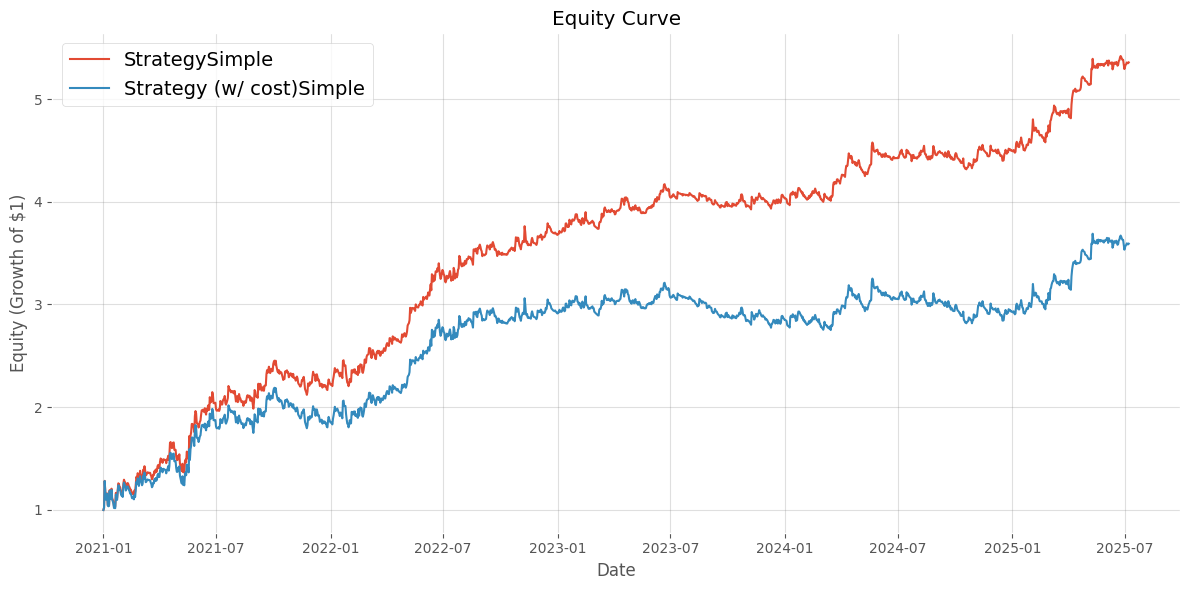

In [89]:
plot_equity_curve(dailyreturns)

 Drawdown      Start     Trough   Recovery
-0.514039 2023-06-22 2024-12-17 2025-07-07
-0.412675 2021-10-03 2022-01-31 2022-05-09
-0.392168 2021-01-04 2021-01-20 2021-05-19
-0.295936 2021-05-19 2021-05-21 2021-06-21
-0.277240 2021-06-22 2021-08-31 2021-09-24


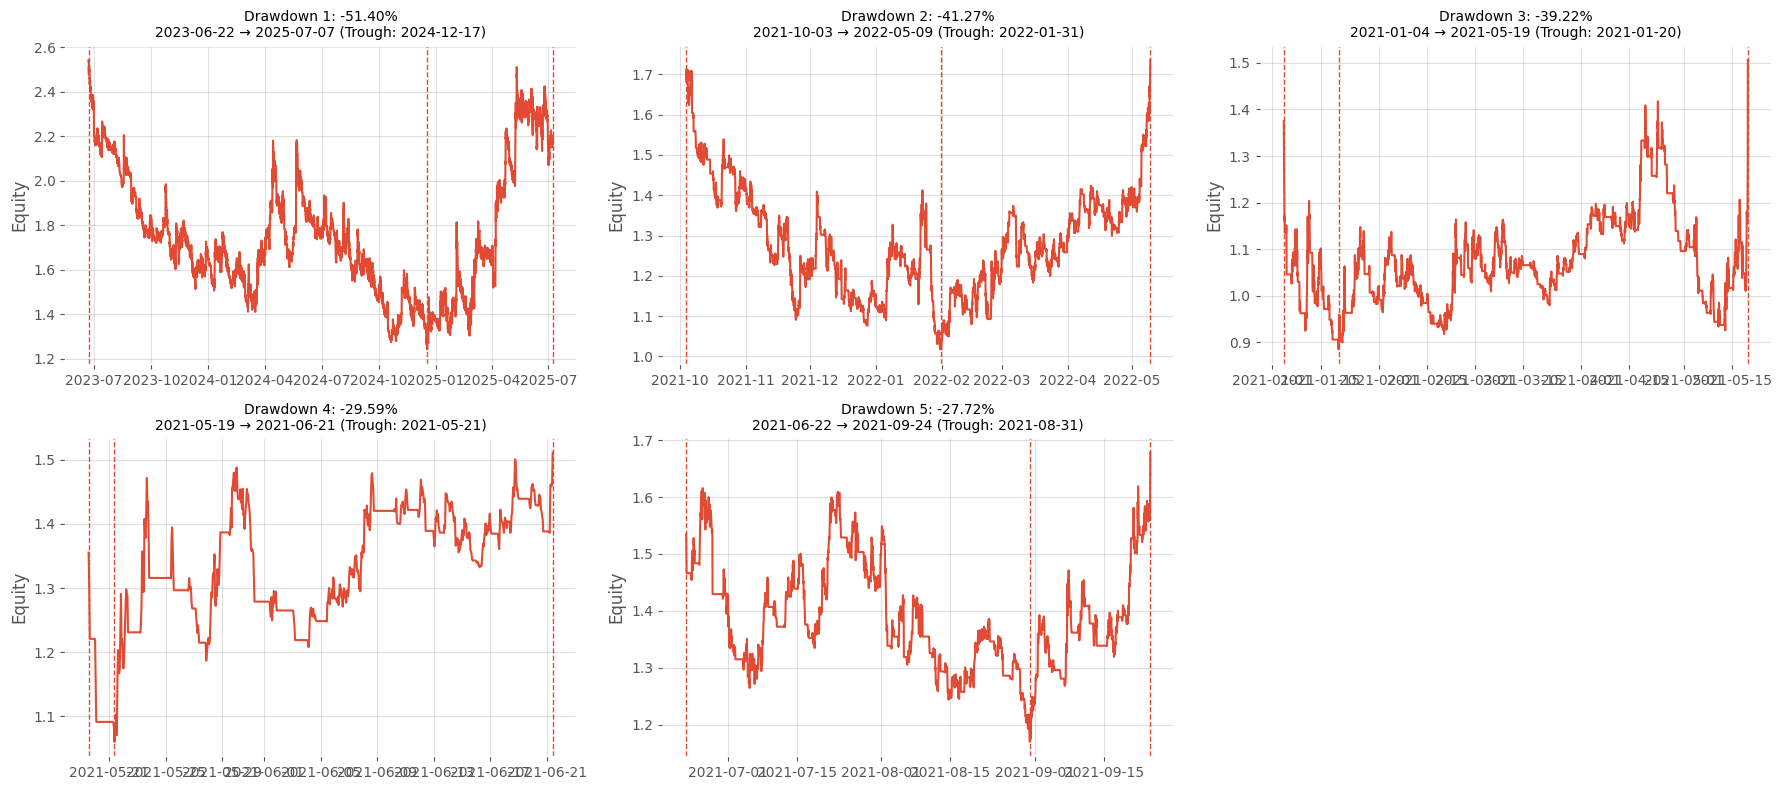

In [90]:
dd_tbl, equity_curve, dd_series = top_drawdowns_code1_strict(TradingStrategy, "Strategy_w_cost", top_n=5)
print_plot_drawdown(dd_tbl, equity_curve, dd_series)

In [91]:
report = BacktestReport(dailyreturns[["DailySimpleStrategy"]])
metrics = report.compute_metrics()
print(pd.Series(metrics))

Start                            2021-01-01 00:00:00
End                              2025-07-07 00:00:00
Duration                          1648 days 00:00:00
Equity Final [$]                           77.989818
Equity Peak [$]                            82.966368
Return [%]                               7698.981794
Return (Ann.) [%]                         162.298335
Volatility (Ann.) [%]                      62.821532
Sharpe Ratio                                1.535003
Sortino Ratio                               4.953728
Calmar Ratio                                5.733801
Max. Drawdown [%]                         -28.305538
Avg. Drawdown [%]                          -7.971752
Max. Drawdown Duration               0 days 00:00:00
Avg. Drawdown Duration    17 days 22:10:37.974683544
dtype: object


### Optuna

In [92]:
# --- Define CCI Crossover ---
def CCIIndicator_optuna(PriceDF: pd.DataFrame = PriceDF, cci_period: int = cci_period) -> pd.DataFrame:
    PriceDF['CCI'] = ta.CCI(PriceDF['High'], PriceDF['Low'], PriceDF['Close'], timeperiod=cci_period)
    
    # Create SignalDF with relevant columns
    SignalDF = PriceDF[['Open', 'High', 'Low', 'Close', 'CCI']].iloc[cci_period:]
    return SignalDF

def signal_generation_optuna(IndicatorDF: pd.DataFrame, mode = "mean_reversion", exit_mode = "breakout",
                             cci_upper: float = cci_upper, cci_lower: float = cci_lower, cci_mid: float = cci_mid,
                             long_action: int = long_action, short_action: int = short_action):
    ts = IndicatorDF.copy()
    cci = ts["CCI"]

    if mode == "mean_reversion":
        long_signal = ((cci.shift(1) < cci_lower) &
                       (cci >= cci_lower)
                       )
        short_signal = ((cci.shift(1) > cci_upper) &
                        (cci <= cci_upper)
                        )
        
        if exit_mode == "midpoint":
            ts["Positions"] = np.nan
            ts.loc[long_signal, "Positions"] = long_action
            ts.loc[short_signal, "Positions"] = short_action

            exit_long = ((cci.shift(1) < cci_mid) &
                         (cci >= cci_mid)                         
                         )
            exit_short =((cci.shift(1) > cci_mid) &
                         (cci <= cci_mid)
                         )
            ts.loc[exit_long | exit_short, "Positions"] = 0
        elif exit_mode == "breakout":
            ts["Positions"] = np.nan
            ts.loc[long_signal, "Positions"] = long_action
            ts.loc[short_signal, "Positions"] = short_action

        else:
            raise ValueError("mode must be 'midpoint' or 'breakout'")

    elif mode == "momentum":
        short_signal = ((cci.shift(1) > cci_lower) &
                       (cci <= cci_lower)
                       )
        long_signal = ((cci.shift(1) < cci_upper) &
                        (cci >= cci_upper)
                        )
        
        if exit_mode == "midpoint":
            ts["Positions"] = np.nan
            ts.loc[long_signal, "Positions"] = long_action
            ts.loc[short_signal, "Positions"] = short_action

            exit_short = ((cci.shift(1) < cci_mid) &
                         (cci >= cci_mid)                         
                         )
            exit_long =((cci.shift(1) > cci_mid) &
                         (cci <= cci_mid)
                         )
            ts.loc[exit_long | exit_short, "Positions"] = 0
        elif exit_mode == "breakout":
            ts["Positions"] = np.nan
            ts.loc[long_signal, "Positions"] = long_action
            ts.loc[short_signal, "Positions"] = short_action

        else:
            raise ValueError("mode must be 'midpoint' or 'breakout'")
    
    else:
            raise ValueError("mode must be 'mean_reversion' or 'momentum'")

    ts["Positions_base"] = ts["Positions"].copy()

    # 🔑 Explicit edge booleans for downstream SL/max-holding
    ts["EdgeLong"]  = long_signal.fillna(False)
    ts["EdgeShort"] = short_signal.fillna(False) 
    
    return ts



# ──────────────────────────────────────────────────────────────────────────────
# 1) MAX-HOLDING: iteratively zero boundary bars in the *base* signal
#    (capped by sign; recompute runs until no run exceeds cap)
# ──────────────────────────────────────────────────────────────────────────────
def cap_runs_iterative_update_base(
    base_signal: pd.Series,
    max_holding_val: int,
    max_iters: int = 10000
) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """
    Edit the *base* signal by zeroing ONLY boundary bars where run-length by sign
    would exceed `max_holding_val`. Rebuild positions via ffill()->0 each loop
    until no more breaches.

    Returns:
        edited_base: pd.Series  - the modified base signal (with boundary bars zeroed)
        positions:   pd.Series  - positions reconstructed from edited_base (ffill -> 0)
        action:      pd.Series  - +1 buy / -1 sell on capped boundary bars, 0 elsewhere
                                  (sell when capping a long, buy when capping a short)
    """
    sig = pd.to_numeric(base_signal, errors="coerce").copy()
    # action = pd.Series(np.nan, index=sig.index, dtype=int)
    action = sig.copy()

    # flags that ONLY mark capped bars (do not mirror full action series)
    exit_max_holding_long  = pd.Series(False, index=sig.index)
    exit_max_holding_short = pd.Series(False, index=sig.index)
    
    for _ in range(max_iters):
        # positions from current edited base
        pos = sig.ffill().fillna(0)
        sgn = np.sign(pos).astype(int)

        # segment IDs whenever sign changes (incl. between 0/non-zero)
        seg_id = (sgn != sgn.shift()).cumsum()

        # run-length within non-zero segments
        run = sgn.ne(0).groupby(seg_id).cumsum()

        # bars that would exceed the cap
        over = run > max_holding_val
        if not over.any():
            return sig, pos, action, exit_max_holding_long, exit_max_holding_short

        # zero exactly the first bar that exceeds the cap for each run
        boundary = over & (run.shift(1).fillna(0) == max_holding_val)

        if not boundary.any():
            # safety: if something odd happens, stop
            return sig, pos, action, exit_max_holding_long, exit_max_holding_short

        # record actions at boundary:
        # if currently long (+1), we must SELL (-1); if short (-1), we must BUY (+1)
        action.loc[boundary] = (-sgn.loc[boundary]).astype(int)

        # Update flags ONLY at those boundary bars, by direction being capped
        exit_max_holding_long  |= (boundary & (sgn == 1))   # capping a long
        exit_max_holding_short |= (boundary & (sgn == -1))  # capping a short
        
        # enforce the cap by forcing the base signal flat at boundary
        sig.loc[boundary] = 0

    # if we somehow didn’t converge
    raise RuntimeError("max_iters reached before capping stabilized")

# ──────────────────────────────────────────────────────────────────────────────
# 2) STOP-LOSS: update the *base* signal using explicit entry edges
#    (sparse base convention; re-entry only on fresh edges)
# ──────────────────────────────────────────────────────────────────────────────
def stop_loss_update_base(
    base_sig: pd.Series,
    close: pd.Series,
    stop_loss_val: float = 0.10,
    cooldown_bars: int = 0,
    allow_flip: bool = True,
    # edge_source: pd.Series | None = None,
    entry_long_edge: pd.Series | None = None,
    entry_short_edge: pd.Series | None = None,
    exit_max_holding_long: pd.Series | None = None,
    exit_max_holding_short: pd.Series | None = None
) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """
    Sparse-base convention:
      • write +1/-1 ONLY on entry bars (fresh edges)
      • write 0 ONLY on SL bars (and cooldown bars, if any)
      • write NaN on all other bars
    Final executed Positions = out_sig.ffill().fillna(0).
    Prefers explicit `entry_long_edge` / `entry_short_edge`. If not provided,
    falls back to edges inferred from a frozen `edge_source`.
    """
    base_sig = pd.to_numeric(base_sig, errors="coerce")
    close    = pd.to_numeric(close,    errors="coerce")

    entry_long_edge  = entry_long_edge.fillna(False)
    entry_short_edge = entry_short_edge.fillna(False)
    exit_max_holding_long = exit_max_holding_long.fillna(False)
    exit_max_holding_short = exit_max_holding_short.fillna(False)

    out_sig = base_sig.copy()                  # sparse base we will write to
    sl_hit  = pd.Series(False, index=base_sig.index)  # flags where SL triggers

    curr_pos = 0
    entry_px = None
    cooldown_left = 0

    for i in range(len(base_sig)):
        px = close.iloc[i]
        e_long  = bool(entry_long_edge.iloc[i])
        e_short = bool(entry_short_edge.iloc[i])
        exit_max_hold_long = bool(exit_max_holding_long.iloc[i])
        exit_max_hold_short = bool(exit_max_holding_short.iloc[i])

        # Cooldown → explicit 0 each bar of cooldown
        if cooldown_left > 0:
            out_sig.iloc[i] = 0
            cooldown_left -= 1
            curr_pos = 0; entry_px = None
            continue

        if exit_max_hold_long:
            out_sig.iloc[i] = 0; curr_pos = 0
            continue

        if exit_max_hold_short:
            out_sig.iloc[i] = 0; curr_pos = 0
            continue

        if curr_pos == 0:
            # ONLY enter on fresh edges; otherwise keep sparse NaN
            if e_long:
                out_sig.iloc[i] =  1; curr_pos =  1; entry_px = px
            elif e_short:
                out_sig.iloc[i] = -1; curr_pos = -1; entry_px = px
            else:
                out_sig.iloc[i] = np.nan
            continue

        # In a position: stop checks
        if curr_pos > 0 and px <= entry_px * (1 - stop_loss_val):
            out_sig.iloc[i] = 0; sl_hit.iloc[i] = True
            curr_pos = 0; entry_px = None; cooldown_left = cooldown_bars
            continue

        if curr_pos < 0 and px >= entry_px * (1 + stop_loss_val):
            out_sig.iloc[i] = 0; sl_hit.iloc[i] = True
            curr_pos = 0; entry_px = None; cooldown_left = cooldown_bars
            continue

        # Not stopped: flip only on flip-edge; otherwise keep sparse NaN
        if curr_pos > 0:
            if allow_flip and e_short:
            # if allow_flip and f_short:
                out_sig.iloc[i] = -1; curr_pos = -1; entry_px = px
                continue
            # else:
            #     out_sig.iloc[i] = np.nan
        
        if curr_pos < 0:
            if allow_flip and e_long:
                out_sig.iloc[i] = 1; curr_pos = 1; entry_px = px
                continue
        else:
            out_sig.iloc[i] = np.nan

    pos_out = out_sig.ffill().fillna(0)
    return out_sig, pos_out, sl_hit


# ──────────────────────────────────────────────────────────────────────────────
# 3) PIPELINE: TradingStrategy_optimised
#    - expects SignalDF from your signal_generation() (has Positions_base, EdgeLong, EdgeShort)
#    - applies max-holding (edit base) → stop-loss (edit base) → builds executed Positions
# ──────────────────────────────────────────────────────────────────────────────
def TradingStrategy_optimised_optuna(
    SignalDF: pd.DataFrame,
    max_holding: bool = False,
    max_holding_val: int = 300,
    stop_loss: bool = False,
    stop_loss_val: float = 0.10,
    cooldown_bars: int = 0,
    allow_flip: bool = True
) -> pd.DataFrame:

    ts = SignalDF.copy()

    # Canonical base (sparse) & edges from signal_generation
    if "Positions_base" not in ts.columns:
        # fallback: treat Positions as base if needed
        ts["Positions_base"] = pd.to_numeric(ts.get("Positions", pd.Series(index=ts.index, dtype=float)),
                                             errors="coerce")

    base_sig_raw = pd.to_numeric(ts["Positions_base"], errors="coerce")
    close_series = pd.to_numeric(ts["Close"], errors="coerce")

    # Explicit edges preferred (ensure boolean dtype)
    edge_long  = ts.get("EdgeLong")
    edge_short = ts.get("EdgeShort")
    if edge_long is None or edge_short is None:
        # Fallback: derive from raw base if edges missing
        raw_pos   = base_sig_raw.ffill().fillna(0)
        raw_sign  = np.sign(raw_pos); prev_sign = raw_sign.shift(1).fillna(0)
        edge_long  = (raw_sign > 0) & (prev_sign == 0)
        edge_short = (raw_sign < 0) & (prev_sign == 0)
    edge_long  = edge_long.fillna(False)
    edge_short = edge_short.fillna(False)

    # 1) Max-holding (edit the base, not the executed positions)
    if max_holding:
        base_sig_capped, pos_after_cap, max_action, exit_max_holding_long, exit_max_holding_short \
            = cap_runs_iterative_update_base(base_sig_raw, max_holding_val)
    else:
        base_sig_capped = base_sig_raw.copy()
        pos_after_cap   = base_sig_capped.ffill().fillna(0)

    # 2) Stop-loss (edit the capped base; re-entry only on fresh edges)
    if stop_loss:
        base_sig_sl, final_positions, sl_hit = stop_loss_update_base(
            base_sig=max_action,
            close=close_series,
            stop_loss_val=stop_loss_val,
            cooldown_bars=cooldown_bars,
            allow_flip=allow_flip,
            entry_long_edge=edge_long,
            entry_short_edge=edge_short,
            exit_max_holding_long = exit_max_holding_long,
            exit_max_holding_short = exit_max_holding_short
        )
    else:
        base_sig_sl     = base_sig_capped.copy()
        final_positions = pos_after_cap
        sl_hit          = pd.Series(False, index=ts.index)

    # Persist sparse base & executed positions
    # final_positions = pos_after_cap
    ts["Max_hold_long_exit"] = exit_max_holding_long
    ts["Max_hold_short_exit"] = exit_max_holding_short
    ts["Action_capped"] = max_action
    ts["Positions_capped"] = base_sig_capped
    ts["Positions_base_sl"] = base_sig_sl                # sparse: ±1 only on entries, 0 only on exits/SL, NaN elsewhere
    ts["Positions_base_sl"] = ts["Positions_base_sl"].fillna(ts["Positions_base"])
    ts["Positions"]      = final_positions            # executed: ffill().fillna(0)
    ts["SL_Hit"]         = sl_hit

    # Actions & event flags (AFTER exits)
    prev_pos = ts["Positions"].shift(1).fillna(0)
    delta    = ts["Positions"] - prev_pos
    ts["Action"] = delta.fillna(0)
    if len(ts) > 0:
        ts["Action"].iat[0] = 0

    pos = ts["Positions"]
    ts["EntryLong"]   = (delta > 0) & (pos > 0) & (prev_pos == 0)
    ts["ExitShort"]   = (delta > 0) & (pos == 0) & (prev_pos < 0)
    ts["EntryShort"]  = (delta < 0) & (pos < 0) & (prev_pos == 0)
    ts["ExitLong"]    = (delta < 0) & (pos == 0) & (prev_pos > 0)
    ts["FlipToLong"]  = (prev_pos < 0) & (pos > 0)
    ts["FlipToShort"] = (prev_pos > 0) & (pos < 0)

    # PnL
    ts["Returns"]  = np.log(close_series / close_series.shift(1)).fillna(0)
    ts["Strategy"] = ts["Returns"] * prev_pos

    TradingCost_local = globals().get("TradingCost", 0.0)
    if TradingCost_local:
        log_cost = np.log(1 - TradingCost_local)
        ts["Strategy_w_cost"] = ts["Strategy"] + np.where(ts["Action"] != 0,
                                                          log_cost * np.abs(ts["Action"]), 0)
    else:
        ts["Strategy_w_cost"] = ts["Strategy"]

    return ts


In [93]:
# # Delete the existing study (drops all its trials)
# import optuna
# STUDY_NAME = "cci_strategy_base_eth_tpe"          # choose your friendly name
# STORAGE_URL = "sqlite:///optuna_results.db"
# optuna.delete_study(study_name=STUDY_NAME, storage=STORAGE_URL)

In [94]:
# ----------------------------
# Optuna optimization harness
# ----------------------------
import numpy as np
import pandas as pd
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.samplers import RandomSampler
import re

STUDY_NAME = "cci_strategy_base_eth_tpe"          # choose your friendly name
STORAGE_URL = "sqlite:///optuna_results.db"  # or "sqlite:////full/path/optuna_results.db"
SEED = 42

sampler = TPESampler(seed=SEED, multivariate=True, group=True)  # good defaults for finance

PriceDF = df_1h["2022-01-01 00:00:00":] # df_1h

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=STORAGE_URL,
    load_if_exists=True,
    direction="maximize",           # or "minimize" for loss
    # sampler=RandomSampler(seed=42),
    sampler=sampler
)

# ---- Objective that builds your full pipeline
MIN_TRADES = 200

def make_objective(PriceDF: pd.DataFrame):
    """
    Capture your raw price data once. Inside the trial, we recompute
    indicators, signals, strategy & metrics for each parameter set.
    """
    def objective(trial: optuna.Trial) -> float:
        # ----- Sample hyperparameters
        # CCI lookback
        cci_period = trial.suggest_int("cci_period", 6, 40)

        # CCI bands (ensure upper > lower + margin)
        cci_lower = trial.suggest_int("cci_lower", -200, -100)
        cci_mid   = trial.suggest_int("cci_mid", -50, 50)  # if used by your logic
        cci_upper = trial.suggest_int("cci_upper", 100, 200)
    

        # Strategy modes
        mode      = trial.suggest_categorical("mode", ["mean_reversion", "momentum"])
        exit_mode = trial.suggest_categorical("exit_mode", ["midpoint", "breakout"])

        # Position sizing flags (you can leave these fixed at ±1 if you don’t scale)
        long_action  = 1
        # short_action = trial.suggest_int("short_action", -1, 0)
        short_action = -1

        # Max holding
        # use_max_holding = trial.suggest_categorical("max_holding", [False, True])
        use_max_holding = True
        max_holding_val = trial.suggest_int("max_holding_val", 50, 500) if use_max_holding else 300

        # Stop-loss
        # use_stop_loss   = trial.suggest_categorical("stop_loss", [False, True])
        use_stop_loss = True
        stop_loss_val   = trial.suggest_float("stop_loss_val", 0.02, 0.30) if use_stop_loss else 0.10

        cooldown_bars = 0
        use_allow_flip = True

        # Trading cost
        trading_cost = 0.0005

        # ----- Build pipeline for this trial
        # 1) Indicators
        cci_period = cci_period
        IndicatorDF = CCIIndicator_optuna(PriceDF, cci_period)

        # 2) Signals
        cci_lower = cci_lower
        cci_upper = cci_upper
        cci_mid = cci_mid
        long_action = long_action
        short_action = short_action
        SignalDF = signal_generation_optuna(IndicatorDF, mode=mode, exit_mode=exit_mode, 
                                            cci_upper = cci_upper, cci_lower = cci_lower, cci_mid = cci_mid,
                                            long_action = long_action, short_action = short_action)

        # 3) Strategy with exits & PnL
        strat_df = TradingStrategy_optimised(
            SignalDF,
            max_holding=use_max_holding,
            max_holding_val=max_holding_val,
            stop_loss=use_stop_loss,
            stop_loss_val=stop_loss_val,
            cooldown_bars = cooldown_bars, 
            allow_flip = use_allow_flip
        )

        counter_series, ts1 = trade_count(strat_df)
        summarydf = summary_metrics(ts1)
        summarydf_annual = summary_metrics_annual(ts1)

        # --- count total trades (adjust if your function differs) ---
        try:
            # If counter_series is a counter per trade id:
            trade_count_val = int(counter_series.max())
        except Exception:
            # Fallback: count entries from strat_df if you store them
            trade_count_val = int((strat_df["Action"].diff().fillna(0) != 0).sum() // 2)

        # --- enforce minimum trades ---
        if trade_count_val < MIN_TRADES:
            # Either prune:
            raise optuna.TrialPruned(f"Too few trades: {trade_count_val} < {MIN_TRADES}")
            # Or: return a terrible score
            # return -1e9

        # 4) Daily returns & metrics
        dailyreturns = ConvertToDailyReturns(ts1, initial_capital=1)
        # Choose which series to optimize; adjust the column if yours differs
        daily_col = "DailySimpleStrategy"
        if daily_col not in dailyreturns.columns:
            # fallback: try first column
            daily_col = dailyreturns.columns[0]
        report = BacktestReport(dailyreturns[[daily_col]])
        metrics = report.compute_metrics()

        # ----- Score (maximize)

        # normalize metrics into a dict
        md = metrics.to_dict() if isinstance(metrics, pd.Series) else dict(metrics)
        score = md['Sharpe Ratio']
        # report & prune
        trial.report(score, step=0)
        if trial.should_prune():
            raise optuna.TrialPruned()

        return score

    return objective

# ----------------------------
# Run the study
# ----------------------------

objective = make_objective(PriceDF)
# study.optimize(objective, n_trials=500, show_progress_bar=True, gc_after_trial = True)

print("Best score:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-11-17 16:52:13,062] Using an existing study with name 'cci_strategy_base_eth_tpe' instead of creating a new one.


Best score: 1.5391170029146217
Best params:
  cci_period: 16
  cci_lower: -101
  cci_mid: 12
  cci_upper: 190
  mode: momentum
  exit_mode: midpoint
  max_holding_val: 217
  stop_loss_val: 0.0744856100608042


In [95]:
# study.optimize(objective, n_trials=50, show_progress_bar=True, gc_after_trial = True)

In [96]:
print("Best value:", study.best_value)
print("Best trial params:", study.best_trial.params)

topN = sorted(
    [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE],
    key=lambda t: t.value, reverse=True
)[:200]

for i, t in enumerate(topN, 1):
    print(f"#{i:02d} value={t.value:.4f} params={t.params}")

Best value: 1.5391170029146217
Best trial params: {'cci_period': 16, 'cci_lower': -101, 'cci_mid': 12, 'cci_upper': 190, 'mode': 'momentum', 'exit_mode': 'midpoint', 'max_holding_val': 217, 'stop_loss_val': 0.0744856100608042}
#01 value=1.5391 params={'cci_period': 16, 'cci_lower': -101, 'cci_mid': 12, 'cci_upper': 190, 'mode': 'momentum', 'exit_mode': 'midpoint', 'max_holding_val': 217, 'stop_loss_val': 0.0744856100608042}
#02 value=1.5375 params={'cci_period': 11, 'cci_lower': -101, 'cci_mid': 7, 'cci_upper': 186, 'mode': 'momentum', 'exit_mode': 'midpoint', 'max_holding_val': 308, 'stop_loss_val': 0.108459792464554}
#03 value=1.5233 params={'cci_period': 12, 'cci_lower': -107, 'cci_mid': -15, 'cci_upper': 179, 'mode': 'momentum', 'exit_mode': 'breakout', 'max_holding_val': 111, 'stop_loss_val': 0.11330635413552206}
#04 value=1.5025 params={'cci_period': 12, 'cci_lower': -103, 'cci_mid': 5, 'cci_upper': 178, 'mode': 'momentum', 'exit_mode': 'breakout', 'max_holding_val': 239, 'stop_l

In [97]:
study.best_params

{'cci_period': 16,
 'cci_lower': -101,
 'cci_mid': 12,
 'cci_upper': 190,
 'mode': 'momentum',
 'exit_mode': 'midpoint',
 'max_holding_val': 217,
 'stop_loss_val': 0.0744856100608042}

In [98]:
# =============================
# Clustering Optuna trials — drop-in
# =============================
import numpy as np
import pandas as pd
import optuna

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ----------------------------------------
# 1) Pull trials into a tidy DataFrame
# ----------------------------------------
def trials_to_df(study: optuna.study.Study) -> pd.DataFrame:
    rows = []
    for t in study.trials:
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue
        p = dict(t.params)
        p["value"] = t.value
        p["number"] = t.number
        rows.append(p)
    if not rows:
        raise ValueError("No COMPLETE trials found in the study.")
    return pd.DataFrame(rows)

# ----------------------------------------
# 2) Clean & standardize columns (handle conditionals)
# ----------------------------------------
def clean_trials_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Expected columns (add others you care about)
    expected = [
        "cci_period", "cci_lower", "cci_upper", "cci_mid",
        "mode", "exit_mode",
        # "short_action",
        "max_holding", "max_holding_val",
        "stop_loss", "stop_loss_val",
        "value", "number"
    ]
    for c in expected:
        if c not in df.columns:
            df[c] = np.nan

    # Types & coercions
    df["cci_period"]       = pd.to_numeric(df["cci_period"], errors="coerce")
    df["cci_lower"]         = pd.to_numeric(df["cci_lower"], errors="coerce")
    df["cci_upper"]         = pd.to_numeric(df["cci_upper"], errors="coerce")
    df["cci_mid"]         = pd.to_numeric(df["cci_mid"], errors="coerce")
    # df["short_action"]    = pd.to_numeric(df["short_action"], errors="coerce")
    df["max_holding_val"] = pd.to_numeric(df["max_holding_val"], errors="coerce")
    df["stop_loss_val"]   = pd.to_numeric(df["stop_loss_val"], errors="coerce")

    # Categorical & boolean placeholders (NaNs handled later too)
    df["mode"]      = df["mode"].astype("string").fillna("NA")
    df["exit_mode"] = df["exit_mode"].astype("string").fillna("NA")

    # Booleans may be missing; cast to Float for imputation (0/1 later)
    # If your data already True/False, this just becomes 1.0/0.0 after imputation
    # df["max_holding"] = df["max_holding"].astype("boolean")
    # df["stop_loss"]   = df["stop_loss"].astype("boolean")

    # Conditional defaults:
    # If stop_loss is False and stop_loss_val missing -> set to 0.0 (no SL)
    df.loc[(df["stop_loss"] == False) & (df["stop_loss_val"].isna()), "stop_loss_val"] = 0.0
    # If max_holding is False and max_holding_val missing -> set to 0 (no cap)
    df.loc[(df["max_holding"] == False) & (df["max_holding_val"].isna()), "max_holding_val"] = 0

    # Optional: missingness indicators (helps KMeans know a param was "inactive")
    for col in ["stop_loss_val", "max_holding_val"]:
        df[col + "_was_nan"] = df[col].isna().astype(int)

    return df

# ----------------------------------------
# 3) Feature pipeline (impute + scale + one-hot)
# ----------------------------------------
def make_feature_pipeline(df: pd.DataFrame):
    # Treat booleans as numeric 0/1 via imputation
    # bools   = ["max_holding", "stop_loss"]
    # # Convert boolean dtype -> float (NaNs allowed for imputer)
    # for b in bools:
    #     df[b] = df[b].astype(float)

    numeric = [
        "cci_period", "cci_lower", "cci_upper", "cci_mid",
        # "short_action", 
        "max_holding_val", "stop_loss_val",
        "stop_loss_val_was_nan", "max_holding_val_was_nan",
    ]
    cats = ["mode", "exit_mode"]

    num_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", MinMaxScaler())
    ])
    # bool_pipe = Pipeline([
    #     ("impute", SimpleImputer(strategy="most_frequent")),
    #     ("scale", MinMaxScaler())
    # ])
    cat_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    ct = ColumnTransformer([
        ("num",  num_pipe,  numeric),
        # ("bool", bool_pipe, bools),
        ("cat",  cat_pipe,  cats),
    ])
    feature_cols = {"numeric": numeric, 
                    # "bool": bools, 
                    "cats": cats}
    return ct, feature_cols


# ----------------------------------------
# 4) KMeans with automatic K selection (silhouette)
# ----------------------------------------
def kmeans_cluster_trials(df: pd.DataFrame, k_range=range(2, 9)):
    df = clean_trials_df(df)
    ct, _ = make_feature_pipeline(df)
    X = ct.fit_transform(df)

    if np.isnan(X).any():
        raise ValueError("Transformed X still contains NaNs — check imputers and inputs.")

    best = {"k": None, "sil": -1, "model": None}
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        if sil > best["sil"]:
            best = {"k": k, "sil": sil, "model": km}

    labels = best["model"].predict(X)
    out = df.copy()
    out["cluster"] = labels
    return out, best["model"], ct, best["k"], best["sil"]

# ----------------------------------------
# 5) Summaries per cluster (readable)
# ----------------------------------------
def summarize_clusters(df_labeled: pd.DataFrame) -> pd.DataFrame:
    def mode_or_nan(s):
        m = s.mode()
        return m.iloc[0] if not m.empty else np.nan

    by = df_labeled.groupby("cluster", dropna=False)

    summary = by.agg(
        n=("number", "count"),
        value_median=("value", "median"),
        value_mean=("value", "mean"),
        cci_period_median=("cci_period", "median"),
        cci_lower_median=("cci_lower", "median"),
        cci_upper_median=("cci_upper", "median"),
        cci_mid_median=("cci_mid", "median"),        
        mode_mode=("mode", mode_or_nan),
        exit_mode_mode=("exit_mode", mode_or_nan),
        # short_action_mode=("short_action", mode_or_nan),
        # max_holding_share=("max_holding", "mean"),      # ~ % True
        max_holding_val_median=("max_holding_val", "median"),
        # stop_loss_share=("stop_loss", "mean"),          # ~ % True
        stop_loss_val_median=("stop_loss_val", "median"),
    ).sort_values(["value_median", "n"], ascending=[False, False])

    reps = by.apply(lambda g: g.sort_values("value", ascending=False).head(1)[["number", "value"]].iloc[0])
    reps.columns = ["rep_trial", "rep_value"]
    summary = summary.join(reps)
    return summary.reset_index()

# ----------------------------------------
# 6) Example usage
# ----------------------------------------
# Case A: you already have a Study on disk
# STUDY_NAME = "alpha_momentum_v1"
# STORAGE_URL = "sqlite:///optuna_results.db"
# study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_URL)
# df_trials = trials_to_df(study)

# Case B: if you already built df_trials elsewhere, just ensure it contains your params + 'value' + 'number'
# df_trials = df  # e.g., from your own aggregation

# Then cluster:
# df_lab, model, ct, k, sil = kmeans_cluster_trials(df_trials)
# print(f"Chosen K = {k}, silhouette = {sil:.3f}")
# summary = summarize_clusters(df_lab)
# print(summary.to_string(index=False))

# Optional: save labeled trials for later analysis
# df_lab.to_csv("optuna_trials_labeled.csv", index=False)

In [99]:
# --- Add this small transformer ---
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class WeightTail(BaseEstimator, TransformerMixin):
    """
    Multiply the last `tail_dims` columns by `alpha`.
    Useful when the final block in a ColumnTransformer is one-hot cats.
    """
    def __init__(self, tail_dims: int, alpha: float = 0.35):
        self.tail_dims = int(tail_dims)
        self.alpha = float(alpha)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        if self.tail_dims > 0:
            X[:, -self.tail_dims:] *= self.alpha
        return X

In [100]:
# --- Replace your make_feature_pipeline with this weighted version ---
def make_feature_pipeline_weighted(df: pd.DataFrame, cat_alpha: float = 0.35):
    """
    Builds your original ColumnTransformer, then appends a WeightTail step
    that down-weights the final (categorical one-hot) block by cat_alpha.
    Returns a single Pipeline you can .fit_transform().
    """
    # Build the same CT as before
    # bools   = ["max_holding", "stop_loss"]
    # for b in bools:
    #     df[b] = df[b].astype(float)

    numeric = [
        "cci_period", "cci_lower", "cci_upper", "cci_mid",
        # "short_action", 
        "max_holding_val", "stop_loss_val",
        "stop_loss_val_was_nan", "max_holding_val_was_nan",
    ]
    cats = ["mode", "exit_mode"]

    num_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", MinMaxScaler())
    ])
    # bool_pipe = Pipeline([
    #     ("impute", SimpleImputer(strategy="most_frequent")),
    #     ("scale", MinMaxScaler())
    # ])
    cat_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    ct = ColumnTransformer([
        ("num",  num_pipe,  numeric),
        # ("bool", bool_pipe, bools),
        ("cat",  cat_pipe,  cats),
    ])

    # Fit once on df to determine how many one-hot columns we have
    X_tmp = ct.fit_transform(df)

    # Compute cat block dimensionality robustly (after one-hot)
    X_cat = ct.named_transformers_["cat"].transform(df[cats])
    cat_dims = X_cat.shape[1]

    # Final pipeline = CT -> weight the last `cat_dims` columns
    pipe = Pipeline([
        ("ct", ct),
        ("weight_cat", WeightTail(tail_dims=cat_dims, alpha=cat_alpha)),
    ])

    # return pipe, {"numeric": numeric, "bool": bools, "cats": cats}
    return pipe, {"numeric": numeric, "cats": cats}

In [101]:
# --- Update kmeans_cluster_trials to use the weighted pipeline ---
def kmeans_cluster_trials(df: pd.DataFrame, k_range=range(4, 9), cat_alpha: float = 0.35):
    df = clean_trials_df(df)
    pipe, _ = make_feature_pipeline_weighted(df, cat_alpha=cat_alpha)
    X = pipe.transform(df)  # ColumnTransformer already fit inside the builder

    if np.isnan(X).any():
        raise ValueError("Transformed X still contains NaNs — check imputers and inputs.")

    best = {"k": None, "sil": -1, "model": None}
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        if sil > best["sil"]:
            best = {"k": k, "sil": sil, "model": km}

    labels = best["model"].predict(X)
    out = df.copy()
    out["cluster"] = labels
    return out, best["model"], pipe, best["k"], best["sil"]

In [102]:
df_trials = trials_to_df(study)
df_lab, model, pipe, k, sil = kmeans_cluster_trials(df_trials, k_range=range(4,9), cat_alpha=0.35)
print(f"Chosen K = {k}, silhouette = {sil:.3f}")
summary = summarize_clusters(df_lab)
print(summary.to_string(index=False))

Chosen K = 4, silhouette = 0.382
 cluster  n  value_median  value_mean  cci_period_median  cci_lower_median  cci_upper_median  cci_mid_median      mode_mode exit_mode_mode  max_holding_val_median  stop_loss_val_median  rep_trial  rep_value
       3 30      1.318874    1.327333               12.0            -102.5             186.0             7.5       momentum       midpoint                   309.5              0.108493      543.0   1.539117
       1 49      1.234875    1.232070               13.0            -111.0             187.0             4.0       momentum       breakout                   132.0              0.099966      294.0   1.523269
       0 46      1.106826    1.085028               26.0            -139.0             170.0           -12.5 mean_reversion       breakout                    94.5              0.226280      155.0   1.465579
       2 20      0.847923    0.868263               35.5            -169.5             137.0           -21.5 mean_reversion       midpoint 

In [103]:
# If your study is peccisted:
study = optuna.load_study(study_name="cci_strategy_base_eth_tpe", storage="sqlite:///optuna_results.db")
df_trials = trials_to_df(study)

df_lab, model, ct, k, sil = kmeans_cluster_trials(df_trials)
print(f"Chosen K = {k}, silhouette = {sil:.3f}")

summary = summarize_clusters(df_lab)
print(summary.to_string(index=False))

Chosen K = 4, silhouette = 0.382
 cluster  n  value_median  value_mean  cci_period_median  cci_lower_median  cci_upper_median  cci_mid_median      mode_mode exit_mode_mode  max_holding_val_median  stop_loss_val_median  rep_trial  rep_value
       3 30      1.318874    1.327333               12.0            -102.5             186.0             7.5       momentum       midpoint                   309.5              0.108493      543.0   1.539117
       1 49      1.234875    1.232070               13.0            -111.0             187.0             4.0       momentum       breakout                   132.0              0.099966      294.0   1.523269
       0 46      1.106826    1.085028               26.0            -139.0             170.0           -12.5 mean_reversion       breakout                    94.5              0.226280      155.0   1.465579
       2 20      0.847923    0.868263               35.5            -169.5             137.0           -21.5 mean_reversion       midpoint 

In [104]:
def best_params_per_cluster(df_labeled: pd.DataFrame) -> pd.DataFrame:
    """
    Return one row per cluster: the trial with the highest `value` (Sharpe).
    Includes the trial number, best value, and all relevant params.
    """
    # pick the index of the max Sharpe within each cluster
    idx = df_labeled.groupby("cluster")["value"].idxmax()
    best = df_labeled.loc[idx].copy()

    # Keep only the columns we care about (add/remove as needed)
    param_cols = [
        "cci_period", "cci_lower", "cci_upper", "cci_mid",
        "mode", "exit_mode",
        # "short_action",
        "max_holding", "max_holding_val",
        "stop_loss", "stop_loss_val",
    ]
    keep = ["cluster", "number", "value"] + param_cols
    best = best[keep]

    # Tidy types / rounding for readability
    best = best.rename(columns={"number": "best_trial", "value": "best_value"})
    int_cols   = ["cci_period", "cci_lower", "cci_upper", "cci_mid", 
                #   "short_action", 
                  "max_holding_val"]
    float_cols = ["stop_loss_val", "best_value"]

    for c in int_cols:
        if c in best: best[c] = pd.to_numeric(best[c], errors="coerce").fillna(0).round().astype(int)
    for c in float_cols:
        if c in best: best[c] = pd.to_numeric(best[c], errors="coerce")

    # cast booleans cleanly
    for c in ["max_holding", "stop_loss"]:
        if c in best: best[c] = best[c].astype(bool)

    # nice sorting: best clusters first
    best = best.sort_values("best_value", ascending=False).reset_index(drop=True)

    # optional: round display
    best["best_value"]   = best["best_value"].round(4)
    best["cci_lower"]    = best["cci_lower"].round(2)
    best["cci_upper"]    = best["cci_upper"].round(2)
    best["cci_mid"]      = best["cci_mid"].round(2)
    best["stop_loss_val"]= best["stop_loss_val"].round(3)

    return best

# --- usage ---
# df_lab, model, ct, k, sil = kmeans_cluster_trials(df_trials)
# summary = summarize_clusters(df_lab)
cluster_bests = best_params_per_cluster(df_lab)
print(cluster_bests.to_string(index=False))

# Optional: save
# cluster_bests.to_csv("best_params_per_cluster.csv", index=False)

 cluster  best_trial  best_value  cci_period  cci_lower  cci_upper  cci_mid           mode exit_mode  max_holding  max_holding_val  stop_loss  stop_loss_val
       3         543      1.5391          16       -101        190       12       momentum  midpoint         True              217       True          0.074
       1         294      1.5233          12       -107        179      -15       momentum  breakout         True              111       True          0.113
       0         155      1.4656          26       -137        171       -1 mean_reversion  breakout         True              136       True          0.253
       2         103      1.3085          40       -196        141      -18 mean_reversion  breakout         True              458       True          0.023


In [105]:
def cluster_profiles(df_labeled: pd.DataFrame) -> pd.DataFrame:
    """Per-cluster medians/modes and simple ranges from actual members."""
    def mode_or_nan(s):
        m = s.mode()
        return m.iloc[0] if not m.empty else np.nan

    by = df_labeled.groupby("cluster", dropna=False)
    prof = by.agg(
        n=("number", "count"),
        value_median=("value", "median"),
        value_mean=("value", "mean"),
        cci_period_med=("cci_period", "median"),
        cci_lower_med=("cci_lower", "median"),
        cci_upper_med=("cci_upper", "median"),
        cci_mid_med=("cci_mid", "median"),
        # short_action_mode=("short_action", mode_or_nan),
        max_holding_share=("max_holding", "mean"),
        max_holding_val_med=("max_holding_val", "median"),
        stop_loss_share=("stop_loss", "mean"),
        stop_loss_val_med=("stop_loss_val", "median"),
        mode_mode=("mode", mode_or_nan),
        exit_mode_mode=("exit_mode", mode_or_nan),
        # quick ranges (IQR-ish or min/max)
        cci_lower_min=("cci_lower", "min"),
        cci_lower_max=("cci_lower", "max"),
        cci_upper_min=("cci_upper", "min"),
        cci_upper_max=("cci_upper", "max"),
    ).sort_values(["value_median","n"], ascending=[False, False]).reset_index()
    return prof

# Usage:
# prof = cluster_profiles(df_lab)
# print(prof.to_string(index=False))

In [106]:
prof = cluster_profiles(df_lab)
print(prof.to_string(index=False))

 cluster  n  value_median  value_mean  cci_period_med  cci_lower_med  cci_upper_med  cci_mid_med  max_holding_share  max_holding_val_med  stop_loss_share  stop_loss_val_med      mode_mode exit_mode_mode  cci_lower_min  cci_lower_max  cci_upper_min  cci_upper_max
       3 30      1.318874    1.327333            12.0         -102.5          186.0          7.5                NaN                309.5              NaN           0.108493       momentum       midpoint           -121           -100            151            200
       1 49      1.234875    1.232070            13.0         -111.0          187.0          4.0                NaN                132.0              NaN           0.099966       momentum       breakout           -150           -100            121            200
       0 46      1.106826    1.085028            26.0         -139.0          170.0        -12.5                NaN                 94.5              NaN           0.226280 mean_reversion       breakout         

In [107]:
def cluster_members(df_labeled: pd.DataFrame, c: int) -> pd.DataFrame:
    return df_labeled[df_labeled["cluster"] == c].sort_values("value", ascending=False)

In [108]:
members_c0 = cluster_members(df_lab, 1)   # all trials in cluster 0
print(members_c0.head(10))                 # top 10 by Sharpe

     cci_period  cci_lower  cci_mid  cci_upper      mode exit_mode  \
90           12       -107      -15        179  momentum  breakout   
111          12       -103        5        178  momentum  breakout   
67           15       -107      -28        186  momentum  breakout   
102          11       -101        7        178  momentum  breakout   
89           14       -109      -12        198  momentum  breakout   
115          14       -106      -29        184  momentum  breakout   
93           14       -134       -9        200  momentum  breakout   
76           13       -100       -1        189  momentum  breakout   
105          13       -129       45        189  momentum  breakout   
80           13       -125       33        181  momentum  breakout   

     max_holding_val  stop_loss_val     value  number  max_holding  stop_loss  \
90               111       0.113306  1.523269     294          NaN        NaN   
111              239       0.109344  1.502453     419          NaN 

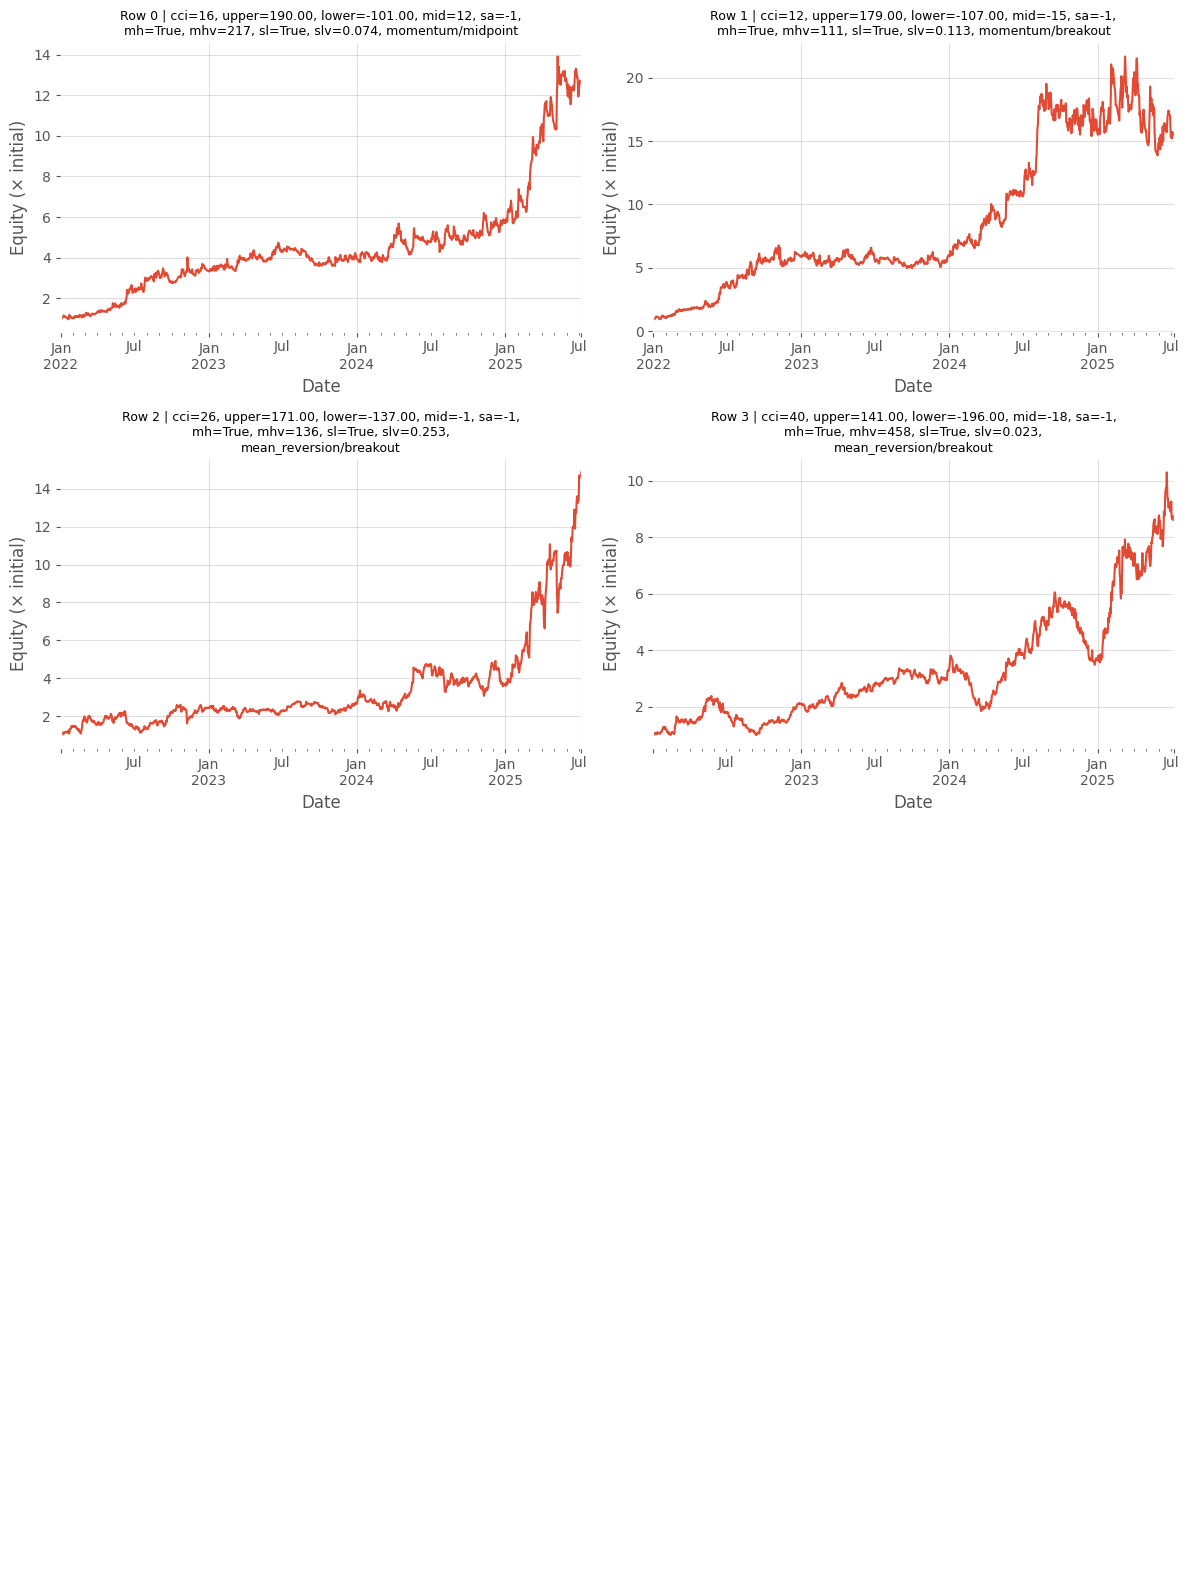

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import textwrap

# ---- helpers ---------------------------------------------------------------
def _bool_from_share(x) -> bool:
    try:
        return bool(float(x) > 0)
    except Exception:
        return False

def _to_int(x, default=0) -> int:
    try:
        # handle numpy scalars and floats like 46.0
        return int(np.round(float(x)))
    except Exception:
        return int(default)

def _to_float(x, default=0.0) -> float:
    try:
        return float(x)
    except Exception:
        return float(default)

def _to_str(x, default=""):
    try:
        s = str(x)
        # guard against "nan"
        return s if s.lower() != "nan" else default
    except Exception:
        return default

def _params_from_row(row: pd.Series) -> dict:
    return {
        "cci_period":      _to_int(row.get("cci_period", 20)),
        "cci_lower":        _to_int(row.get("cci_lower", 30)),
        "cci_upper":        _to_int(row.get("cci_upper", 70)),
        "cci_mid":         _to_int(row.get("cci_mid", 50)),
        "long_action":    1,
        "short_action":   -1,
        "max_holding":    _bool_from_share(row.get("max_holding", 0)),
        "max_holding_val":_to_int(row.get("max_holding_val", 0)),
        "stop_loss":      _bool_from_share(row.get("stop_loss", 0)),
        "stop_loss_val":  _to_float(row.get("stop_loss_val", 0.0)),
        "mode":           _to_str(row.get("mode", "mean_reversion"), "mean_reversion"),
        "exit_mode":      _to_str(row.get("exit_mode", "midpoint"), "midpoint"),
    }

def _run_from_params(PriceDF, p: dict):
    # Your existing pipeline functions are used as-is
    IndicatorDF = CCIIndicator(
        PriceDF,
        p["cci_period"]
    )
    SignalDF = signal_generation_optuna(
        IndicatorDF,
        mode=p["mode"], exit_mode=p["exit_mode"],
        cci_upper=p['cci_upper'], cci_lower=p['cci_lower'], cci_mid=p['cci_mid'],
        long_action=p["long_action"], short_action=p["short_action"]
    )
    strat_df = TradingStrategy_optimised(
        SignalDF,
        max_holding=p["max_holding"],
        max_holding_val=p["max_holding_val"],
        stop_loss=p["stop_loss"],
        stop_loss_val=p["stop_loss_val"],
    )
    _, ts = trade_count(strat_df)
    daily = ConvertToDailyReturns(ts, initial_capital=1)
    # pick a sensible column
    daily_col = "DailySimpleStrategy" if "DailySimpleStrategy" in daily.columns else daily.columns[0]
    eq = (1 + daily[daily_col].fillna(0)).cumprod()
    return eq, daily

# ---- main plotter ----------------------------------------------------------
def plot_equity_series_from_summary(summary: pd.DataFrame, PriceDF: pd.DataFrame, upto_i: int):
    """
    Runs rows 0..upto_i (by iloc) of `summary` and plots one equity curve per row.
    """
    upto_i = int(upto_i)
    n = upto_i + 1
    if n <= 0:
        raise ValueError("upto_i must be >= 0")

    # figure layout
    ncols = 2 if n >= 2 else 1
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4*nrows))
    if nrows*ncols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    plotted = 0
    for i in range(n):
        try:
            row = summary.iloc[i]
        except IndexError:
            break  # fewer rows than requested
        params = _params_from_row(row)
        eq, _ = _run_from_params(PriceDF, params)

        ax = axes[plotted]
        eq.plot(ax=ax)  # no explicit colors/styles per your setup

        import textwrap

        title = (f"Row {i} | cci={params['cci_period']}, upper={params['cci_upper']:.2f}, "
                f"lower={params['cci_lower']:.2f}, mid={params['cci_mid']}, sa={params['short_action']}, "
                f"mh={params['max_holding']}, mhv={params['max_holding_val']}, "
                f"sl={params['stop_loss']}, slv={params['stop_loss_val']:.3f}, "
                f"{params['mode']}/{params['exit_mode']}")
        title_wrapped = "\n".join(textwrap.wrap(title, width=60))  # 60 chars per line

        ax.set_title(title_wrapped, fontsize=9)
        # ax.set_title(
        #     f"Row {i} | bb={params['bb_period']}, up={params['nbdevup']:.2f}, dn={params['nbdevdn']:.2f}, "
        #     f"ma={params['matype']}, sa={params['short_action']}, "
        #     f"mh={params['max_holding']}, mhv={params['max_holding_val']}, "
        #     f"sl={params['stop_loss']}, slv={params['stop_loss_val']:.3f}, "
        #     f"{params['mode']}/{params['exit_mode']}"
        # )
        ax.set_xlabel("Date")
        ax.set_ylabel("Equity (× initial)")
        plotted += 1



    # hide any unused axes
    for j in range(plotted, len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    plt.show()

# ---- example call ----------------------------------------------------------
plot_equity_series_from_summary(cluster_bests, PriceDF, upto_i=7)

In [110]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # --- 1) Build equity & returns matrices for rows 0..upto_i -------------------
# def build_equity_and_returns_macci(summary: pd.DataFrame, PriceDF: pd.DataFrame, upto_i: int):
#     eq_dict = {}
#     for i in range(int(upto_i) + 1):
#         if i >= len(summary):
#             break
#         params = _params_from_row(summary.iloc[i])
#         eq_i, _ = _run_from_params(PriceDF, params)   # eq_i is a Series (equity curve)
#         eq_dict[f"row_{i}"] = eq_i.astype(float)

#     # Align on common index (outer join then forward-fill gaps)
#     eq_df = pd.DataFrame(eq_dict).sort_index().ffill().dropna(how="all")

#     # Log returns are additive and safer for correlation than levels
#     ret_df = np.log(eq_df).diff().dropna(how="all")
#     # If you prefer pct returns instead of log:
#     # ret_df = eq_df.pct_change().replace([np.inf, -np.inf], np.nan).dropna(how="all")

#     return eq_df, ret_df

# # --- 2) Correlation matrices -------------------------------------------------
# def correlation_matrices(ret_df: pd.DataFrame):
#     pearson = ret_df.corr(method="pearson")
#     spearman = ret_df.corr(method="spearman")
#     return pearson, spearman

# # --- 3) Plot a quick heatmap (matplotlib only) -------------------------------
# def plot_corr_heatmap(corr: pd.DataFrame, title="Return Correlation (Pearson)"):
#     fig, ax = plt.subplots(figsize=(8, 6))
#     im = ax.imshow(corr.values, vmin=-1, vmax=1)
#     ax.set_xticks(range(len(corr.columns)))
#     ax.set_yticks(range(len(corr.index)))
#     ax.set_xticklabels(corr.columns, rotation=45, ha="right")
#     ax.set_yticklabels(corr.index)
#     ax.set_title(title)
#     fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#     fig.tight_layout()
#     plt.show()

# # --- 4) Rolling correlation between two selected rows -----------------------
# def rolling_corr(ret_df: pd.DataFrame, a="row_0", b="row_1", window=365):
#     common = ret_df[[a, b]].dropna()
#     rc = common[a].rolling(window).corr(common[b])
#     fig, ax = plt.subplots(figsize=(10, 3.5))
#     rc.plot(ax=ax)
#     ax.axhline(0, lw=1)
#     ax.set_title(f"Rolling {window}-bar correlation: {a} vs {b}")
#     ax.set_ylabel("corr")
#     ax.set_xlabel("Date")
#     fig.tight_layout()
#     plt.show()
#     return rc

In [111]:
# eq_df, ret_df = build_equiaty_and_returns_macci(cluster_bests, PriceDF, upto_i=7)

# pearson, spearman = correlation_matrices(ret_df)
# print("Pearson correlation:\n", pearson.round(3))
# print("Spearman correlation:\n", spearman.round(3))

# # Heatmap
# plot_corr_heatmap(pearson, title="Return Correlation (Pearson)")

# # Rolling correlation between two specific strategies
# rc = rolling_corr(ret_df, a="row_0", b="row_3", window=168)  # 168 = 1 week of hourly bars

### Cash balance approach return

In [112]:
study = optuna.load_study(study_name="cci_strategy_base_eth_tpe", storage="sqlite:///optuna_results.db")
df_trials = trials_to_df(study)

df_lab, model, ct, k, sil = kmeans_cluster_trials(df_trials)
print(f"Chosen K = {k}, silhouette = {sil:.3f}")

summary = summarize_clusters(df_lab)
print(summary.to_string(index=False))

Chosen K = 4, silhouette = 0.382
 cluster  n  value_median  value_mean  cci_period_median  cci_lower_median  cci_upper_median  cci_mid_median      mode_mode exit_mode_mode  max_holding_val_median  stop_loss_val_median  rep_trial  rep_value
       3 30      1.318874    1.327333               12.0            -102.5             186.0             7.5       momentum       midpoint                   309.5              0.108493      543.0   1.539117
       1 49      1.234875    1.232070               13.0            -111.0             187.0             4.0       momentum       breakout                   132.0              0.099966      294.0   1.523269
       0 46      1.106826    1.085028               26.0            -139.0             170.0           -12.5 mean_reversion       breakout                    94.5              0.226280      155.0   1.465579
       2 20      0.847923    0.868263               35.5            -169.5             137.0           -21.5 mean_reversion       midpoint 

In [113]:

def backtest_cash_based(TradingStrategy: pd.DataFrame = TradingStrategy, initial_capital = 100_000, trade_size = 1000, trading_cost=0.0005):
    df = TradingStrategy.copy()
    cash = initial_capital
    df["unit"] = 0  


    cash_history, pos_history, unit_history, equity_history = [], [], [], []

    for t in range(1, len(df)):
        positions = df['Positions'].iloc[t]
        action = df['Action'].iloc[t]
        price = df['Close'].iloc[t]
        entry_long = df['EntryLong'].iloc[t]
        entry_short = df['EntryShort'].iloc[t]
        exit_long = df['ExitLong'].iloc[t]
        exit_short = df['ExitShort'].iloc[t]
        flip_long = df['FlipToLong'].iloc[t]
        flip_short = df['FlipToShort'].iloc[t]
        unit = df['unit'].iloc[t]

        if entry_long | entry_short:
            trade = np.sign(action)
            size = trade_size
            unit = trade_size / price * trade
            cost = abs(trade) * size * trading_cost
            cash -= (unit * price + cost)
           
            holdings = unit * price
            equity = cash + holdings

            cash_history.append(cash)
            unit_history.append(unit)
            equity_history.append(equity)

        elif exit_long | exit_short:
            trade = action
            size = unit_history[-1] * price
            cost = abs(trade) * size * trading_cost
            cash += (unit_history[-1] * price - cost)
            unit = 0

            holdings = 0
            equity = cash + holdings

            cash_history.append(cash)
            unit_history.append(unit)
            equity_history.append(equity)

        elif flip_long | flip_short:
            trade = np.sign(action)
            size = unit_history[-1] * price
            cost = abs(trade) * size * trading_cost
            cash += (unit_history[-1] * price - cost)
            unit = 0

            holdings = 0
            equity = cash + holdings

            trade = np.sign(action)
            size = trade_size
            unit = trade_size / price * trade
            cost = abs(trade) * size * trading_cost
            cash -= (unit * price + cost)
           
            holdings = unit * price
            equity = cash + holdings

            cash_history.append(cash)
            unit_history.append(unit)
            equity_history.append(equity)
        
        else:
            if unit_history:
                unit = unit_history[-1]
            else:
                unit = 0 
            cash += 0
            holdings = unit * price
            equity = cash + holdings

            cash_history.append(cash)
            unit_history.append(unit)
            equity_history.append(equity)

    df = df.iloc[1:].copy()
    df["Cash"]   = cash_history
    df["Unit"]    = unit_history
    df["Equity"] = equity_history
    df["Return"] = df["Equity"].pct_change().fillna(0)
    return df

In [114]:
cluster_bests

cluster  best_trial  best_value  cci_period  cci_lower  cci_upper  cci_mid  \
0        3         543      1.5391          16       -101        190       12   
1        1         294      1.5233          12       -107        179      -15   
2        0         155      1.4656          26       -137        171       -1   
3        2         103      1.3085          40       -196        141      -18   

             mode exit_mode  max_holding  max_holding_val  stop_loss  \
0        momentum  midpoint         True              217       True   
1        momentum  breakout         True              111       True   
2  mean_reversion  breakout         True              136       True   
3  mean_reversion  breakout         True              458       True   

   stop_loss_val  
0          0.074  
1          0.113  
2          0.253  
3          0.023

In [115]:
i = 0

try:
    cci_period = (cluster_bests['cci_period'][i]).astype(int)
    cci_upper = (cluster_bests['cci_upper'][i]).astype(int)
    cci_lower = (cluster_bests['cci_lower'][i]).astype(int)
    cci_mid = (cluster_bests['cci_mid'][i]).astype(int)
    long_action = 1
    short_action = -1
    max_holding = bool(cluster_bests['max_holding'][i])
    max_holding_val = (cluster_bests['max_holding_val'][i]).astype(int)
    stop_loss = bool(cluster_bests['stop_loss'][i])
    stop_loss_val = (cluster_bests['stop_loss_val'][i]).astype(float)
    exit_mode = str(cluster_bests['exit_mode'][i])
    mode = str(cluster_bests['mode'][i])

except NameError:
    cci_period = 14
    TradingCost = 0.0005
    cci_upper = 5
    cci_lower = -5
    cci_mid = 0 
    long_action = 1
    short_action = -1
    max_holding = False
    max_holding_val = 488
    stop_loss = False
    stop_loss_val = 0.201718299409196
    mode = 'mean_reversion'
    exit_mode = 'midpoint'



### Cash balance equity curve

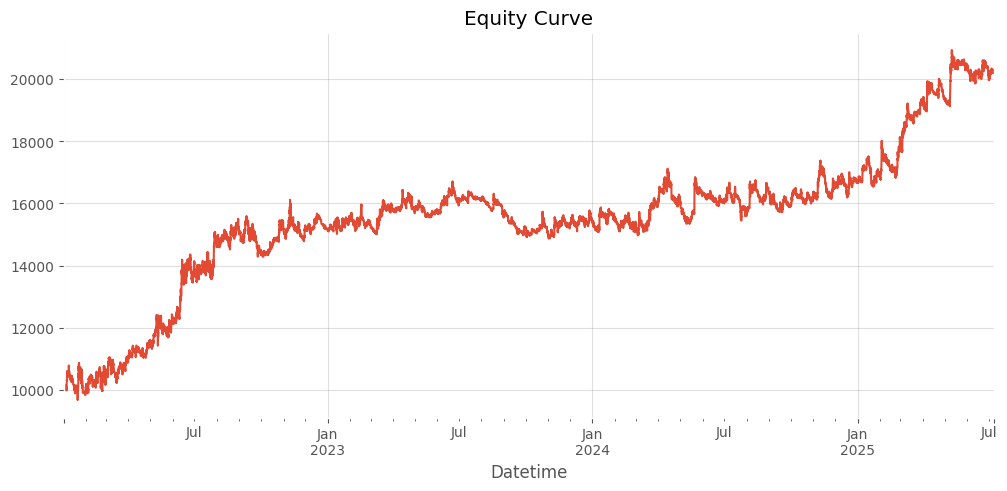

In [116]:
# Example with dummy prices & TEMA signals
IndicatorDF = CCIIndicator(PriceDF, cci_period)
SignalDF = signal_generation(IndicatorDF, mode = mode, exit_mode = exit_mode,
                             long_action = long_action, short_action = short_action) # mode = "mean_reversion" or "momentum", exit_mode = "midpoint" or "breakout"
TradingStrategy = TradingStrategy_optimised(SignalDF, max_holding = max_holding, max_holding_val = max_holding_val, stop_loss = stop_loss, stop_loss_val = stop_loss_val)
bt = backtest_cash_based(TradingStrategy, initial_capital = 10_000, trade_size = 0.5*10_000, trading_cost = 0.0005)

# Plot equity
import matplotlib.pyplot as plt
bt["Equity"].plot(figsize=(12,5), title="Equity Curve")
plt.show()

In [117]:
from pathlib import Path
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime

DATA_DIR = Path("data_store")  # repo-relative
DATA_DIR.mkdir(exist_ok=True)

def _path(name, version=None):
    if version is None:
        return DATA_DIR / f"{name}.parquet"
    return DATA_DIR / f"{name}__{version}.parquet"

def save_df(df: pd.DataFrame, name: str, version: str | None = None):
    path = _path(name, version)
    table = pa.Table.from_pandas(df, preserve_index=True)
    pq.write_table(table, path, compression="snappy")
    return path
    # # optionally also update a "latest" pointer
    # if version is not None:
    #     _path(name).unlink(missing_ok=True)
    #     path.symlink_to(path.name)  # or copy if symlinks not desired

def load_df(name: str, version: str | None = None) -> pd.DataFrame:
    path = _path(name, version)
    return pq.read_table(path).to_pandas()

def list_versions(name: str):
    prefix = f"{name}__"
    return sorted(p.stem.split("__", 1)[1]
                  for p in DATA_DIR.glob(f"{name}__*.parquet"))

# Example
# save_df(df, "eth_1h_prices")                      # overwrite “latest”
# save_df(bt, "CCITradingStrategy", version=datetime.now().strftime("%Y%m%d-%H%M"))


### Variable testing

In [118]:
# ----------------------------
# Single-parameter Optuna helper
# ----------------------------
from typing import Dict, Any, Optional, Sequence, Tuple
import optuna
from optuna.samplers import TPESampler

MIN_TRADES = 200  # keep consistent with your main harness
SEED = 42

def _evaluate_with_params(PriceDF: pd.DataFrame, params: Dict[str, Any]) -> Tuple[float, int]:
    """
    Runs your full pipeline with a given param dict and returns (score, trade_count).
    Adjust the field names if yours differ (e.g., daily column name).
    """
    # ---- Unpack the params you use
    cci_period    = params["cci_period"]
    cci_lower     = params["cci_lower"]
    cci_mid       = params["cci_mid"]
    cci_upper     = params["cci_upper"]
    mode          = params["mode"]
    exit_mode     = params["exit_mode"]
    # short_action  = params["short_action"]
    # use_max_hold  = params["max_holding"]
    max_hold_val  = params["max_holding_val"]
    # use_stop_loss = params["stop_loss"]
    stop_loss_val = params["stop_loss_val"]

    # ---- 1) Indicators
    IndicatorDF = CCIIndicator_optuna(PriceDF, cci_period)

    # ---- 2) Signals
    SignalDF = signal_generation_optuna(
        IndicatorDF,
        mode=mode, exit_mode=exit_mode,
        cci_upper=cci_upper, cci_lower=cci_lower, cci_mid=cci_mid,
        long_action=1, short_action=-1
    )

    use_max_hold = True
    use_stop_loss = True

    # ---- 3) Strategy & PnL
    strat_df = TradingStrategy_optimised_optuna(
        SignalDF,
        max_holding=use_max_hold,
        max_holding_val=max_hold_val,
        stop_loss=use_stop_loss,
        stop_loss_val=stop_loss_val,
    )

    counter_series, ts1 = trade_count(strat_df)
    try:
        trade_count_val = int(counter_series.max())
    except Exception:
        trade_count_val = int((strat_df["Action"].diff().fillna(0) != 0).sum() // 2)

    # # ---- 4) Daily returns & score
    # dailyreturns = ConvertToDailyReturns(ts1, initial_capital=1)
    # daily_col = "DailySimpleStrategy" if "DailySimpleStrategy" in dailyreturns.columns else dailyreturns.columns[0]
    # report = BacktestReport(dailyreturns[[daily_col]])
    # metrics = report.compute_metrics()
    # score = metrics["Sharpe Ratio"] if isinstance(metrics, dict) else metrics.to_dict()["Sharpe Ratio"]
    # return score, trade_count_val


    # --- enforce minimum trades ---
    if trade_count_val < MIN_TRADES:
        # Either prune:
        raise optuna.TrialPruned(f"Too few trades: {trade_count_val} < {MIN_TRADES}")
        # Or: return a terrible score
        # return -1e9

    # 4) Daily returns & metrics
    dailyreturns = ConvertToDailyReturns(ts1, initial_capital=1)
    # Choose which series to optimize; adjust the column if yours differs
    daily_col = "DailySimpleStrategy"
    if daily_col not in dailyreturns.columns:
        # fallback: try first column
        daily_col = dailyreturns.columns[0]
    report = BacktestReport(dailyreturns[[daily_col]])
    metrics = report.compute_metrics()        # --- enforce minimum trades ---
    if trade_count_val < MIN_TRADES:
        # Either prune:
        raise optuna.TrialPruned(f"Too few trades: {trade_count_val} < {MIN_TRADES}")
        # Or: return a terrible score
        # return -1e9

    # 4) Daily returns & metrics
    dailyreturns = ConvertToDailyReturns(ts1, initial_capital=1)
    # Choose which series to optimize; adjust the column if yours differs
    daily_col = "DailySimpleStrategy"
    if daily_col not in dailyreturns.columns:
        # fallback: try first column
        daily_col = dailyreturns.columns[0]
    report = BacktestReport(dailyreturns[[daily_col]])
    metrics = report.compute_metrics()

    # ----- Score (maximize)

    # normalize metrics into a dict
    md = metrics.to_dict() if isinstance(metrics, pd.Series) else dict(metrics)
    score = md['Sharpe Ratio']

    return score, trade_count_val







In [119]:
study.best_params

{'cci_period': 16,
 'cci_lower': -101,
 'cci_mid': 12,
 'cci_upper': 190,
 'mode': 'momentum',
 'exit_mode': 'midpoint',
 'max_holding_val': 217,
 'stop_loss_val': 0.0744856100608042}

In [120]:
# 1) Choose your baseline (freeze others). Often you'd start from your best so far:
base = study.best_params.copy()  # from your previous multi-param run
# make sure all required keys exist (set sensible defaults if they’re missing)
base.setdefault("cci_period", 14)
base.setdefault("cci_lower", 30)
base.setdefault("cci_mid",   50)
base.setdefault("cci_upper", 70)
base.setdefault("mode", "momentum")
base.setdefault("exit_mode", "midpoint")
# base.setdefault("short_action", -1)
base.setdefault("max_holding", True)
base.setdefault("max_holding_val", 300)
base.setdefault("stop_loss", True)
base.setdefault("stop_loss_val", 0.10)


0.0744856100608042

In [121]:
import math
import numpy as np
import pandas as pd

DEPENDENCIES = {
    "stop_loss_val":  {"stop_loss": True},
    "max_holding_val": {"max_holding": True},
}


def sweep_multiple_params(
    PriceDF,
    base_params: dict,
    param_grids: dict[str, list],
    *,
    constraint_fn=None,     # e.g., lambda p: p["rsi_lower"] + 10 <= p["rsi_mid"] <= p["rsi_upper"] - 10
    min_trades: int = 200,  # same as your harness
) -> pd.DataFrame:
    """
    For each parameter in `param_grids`, sweep its grid while keeping all other params fixed to `base_params`.
    Returns a tidy DataFrame with columns:
      ['param','value','score','trades','delta_vs_baseline','gap_to_param_best','is_best_for_param']
    """
    # Compute baseline once
    base_score, base_trades = _evaluate_with_params(PriceDF, dict(base_params))
    rows = []

    for pname, grid in param_grids.items():
        for val in grid:
            params = dict(base_params)
            params[pname] = val
            # <-- enforce dependencies
            if pname in DEPENDENCIES:
                params.update(DEPENDENCIES[pname])

            if constraint_fn is not None and not constraint_fn(params):
                rows.append({
                    "param": pname, "value": val,
                    "score": np.nan, "trades": np.nan,
                    "delta_vs_baseline": np.nan,
                })
                continue

            score, trades = _evaluate_with_params(PriceDF, params)

            # If you want to “soft prune” low-trade configs, mark as NaN
            if trades is not None and trades < min_trades:
                score = np.nan

            rows.append({
                "param": pname,
                "value": val,
                "score": score,
                "trades": trades,
                "delta_vs_baseline": (score - base_score) if pd.notna(score) else np.nan,
            })

    df = pd.DataFrame(rows)

    # Per-parameter best & gap
    best_per_param = (
        df.groupby("param", dropna=False)["score"]
          .transform(lambda s: np.nanmax(s.values))
    )
    df["gap_to_param_best"] = best_per_param - df["score"]
    df["is_best_for_param"] = np.isclose(df["gap_to_param_best"], 0.0, equal_nan=False)

    # Optional: rank within each parameter by score (descending)
    df["rank_in_param"] = (
        df.groupby("param")["score"]
          .rank(ascending=False, method="first")
    )

    # Nice ordering
    df = df.sort_values(["param", "rank_in_param"]).reset_index(drop=True)
    return df

In [122]:
base

{'cci_period': 16,
 'cci_lower': -101,
 'cci_mid': 12,
 'cci_upper': 190,
 'mode': 'momentum',
 'exit_mode': 'midpoint',
 'max_holding_val': 217,
 'stop_loss_val': 0.0744856100608042,
 'max_holding': True,
 'stop_loss': True}

In [123]:
cluster_bests

cluster  best_trial  best_value  cci_period  cci_lower  cci_upper  cci_mid  \
0        3         543      1.5391          16       -101        190       12   
1        1         294      1.5233          12       -107        179      -15   
2        0         155      1.4656          26       -137        171       -1   
3        2         103      1.3085          40       -196        141      -18   

             mode exit_mode  max_holding  max_holding_val  stop_loss  \
0        momentum  midpoint         True              217       True   
1        momentum  breakout         True              111       True   
2  mean_reversion  breakout         True              136       True   
3  mean_reversion  breakout         True              458       True   

   stop_loss_val  
0          0.074  
1          0.113  
2          0.253  
3          0.023

In [124]:
param_grids = {
    "cci_lower":  list(range(-250, -100, 5)),
    "cci_mid":    list(range(-50, 50, 5)),
    "cci_upper":  list(range(100, 250, 5)),
    "cci_period": list(range(6, 41)),
    # "stop_loss": [True],
    # "stop_loss_val":  [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15],
    # "max_holding":    [True],
    # "max_holding_val": [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350, 400, 450, 500],
}

def band_constraint(p):
    return (p["cci_lower"] + 10) <= p["cci_mid"] <= (p["cci_upper"] - 10)

df_sweeps = sweep_multiple_params(
    PriceDF, base, param_grids,
    constraint_fn=band_constraint, min_trades=MIN_TRADES
)

# Show top 10 rows overall (or group-by per param)
print(df_sweeps[["param","value","score","trades","delta_vs_baseline"]].head(10))

# Show “your” view for one param (e.g., rsi_lower), sorted best → worst
view = (df_sweeps[df_sweeps["param"]=="cci_lower"]
        .sort_values("score", ascending=False)
        [["param","value","score","trades","delta_vs_baseline"]])
print(view.head(15))


       param  value     score  trades  delta_vs_baseline
0  cci_lower   -105  1.456795    1305          -0.082322
1  cci_lower   -110  1.347259    1285          -0.191858
2  cci_lower   -115  1.212573    1265          -0.326544
3  cci_lower   -120  1.189539    1229          -0.349578
4  cci_lower   -125  1.184160    1208          -0.354957
5  cci_lower   -130  1.144216    1179          -0.394901
6  cci_lower   -250  1.111698     429          -0.427419
7  cci_lower   -150  1.092366    1085          -0.446751
8  cci_lower   -145  1.085598    1114          -0.453519
9  cci_lower   -245  1.060573     451          -0.478544
        param  value     score  trades  delta_vs_baseline
0   cci_lower   -105  1.456795    1305          -0.082322
1   cci_lower   -110  1.347259    1285          -0.191858
2   cci_lower   -115  1.212573    1265          -0.326544
3   cci_lower   -120  1.189539    1229          -0.349578
4   cci_lower   -125  1.184160    1208          -0.354957
5   cci_lower   -130  1.1

In [125]:
def show_sweeps_with_baseline(df_sweeps: pd.DataFrame, base_params: dict):
    # Create a DataFrame of baseline values for all params that were swept
    baseline_rows = []
    for pname in df_sweeps["param"].unique():
        baseline_rows.append({
            "param": pname,
            "value": base_params.get(pname, np.nan),
            "score": np.nan,          # no need to recompute; optional
            "trades": np.nan,
            "delta_vs_baseline": 0.0  # by definition baseline delta = 0
        })
    baseline_df = pd.DataFrame(baseline_rows)

    # Combine with actual sweeps
    df_with_base = pd.concat([baseline_df, df_sweeps], ignore_index=True)

    # Sort: baseline first (delta=0), then descending score
    df_with_base["is_baseline"] = df_with_base.apply(
        lambda r: r["value"] == base_params.get(r["param"]), axis=1
    )
    df_with_base = df_with_base.sort_values(
        by=["param", "is_baseline", "score"],
        ascending=[True, False, False]
    ).reset_index(drop=True)

    # Pretty view
    return df_with_base[["param", "value", "score", "trades", "delta_vs_baseline", "is_baseline"]]

In [126]:
df_with_base = show_sweeps_with_baseline(df_sweeps, base)
# show first 100 and last 100 rows
pd.options.display.max_rows = 200
display(df_with_base)

param  value     score  trades  delta_vs_baseline  is_baseline
0     cci_lower   -101       NaN     NaN           0.000000         True
1     cci_lower   -105  1.456795  1305.0          -0.082322        False
2     cci_lower   -110  1.347259  1285.0          -0.191858        False
3     cci_lower   -115  1.212573  1265.0          -0.326544        False
4     cci_lower   -120  1.189539  1229.0          -0.349578        False
5     cci_lower   -125  1.184160  1208.0          -0.354957        False
6     cci_lower   -130  1.144216  1179.0          -0.394901        False
7     cci_lower   -250  1.111698   429.0          -0.427419        False
8     cci_lower   -150  1.092366  1085.0          -0.446751        False
9     cci_lower   -145  1.085598  1114.0          -0.453519        False
10    cci_lower   -245  1.060573   451.0          -0.478544        False
11    cci_lower   -135  1.022860  1161.0          -0.516258        False
12    cci_lower   -140  1.022497  1138.0          -0.516620        False
13    cci_lower   -240  0.988889   489.0          -0.550228        False
14    cci_lower   -155  0.966160  1055.0          -0.572957        False
15    cci_lower   -230  0.932796   572.0          -0.606321        False
16    cci_lower   -160  0.916398  1026.0          -0.622719        False
17    cci_lower   -235  0.902997   536.0          -0.636120        False
18    cci_lower   -165  0.868807   999.0          -0.670310        False
19    cci_lower   -225  0.865480   607.0          -0.673637        False
20    cci_lower   -220  0.785473   639.0          -0.753644        False
21    cci_lower   -170  0.780699   963.0          -0.758418        False
22    cci_lower   -175  0.754580   930.0          -0.784537        False
23    cci_lower   -215  0.735626   671.0          -0.803491        False
24    cci_lower   -205  0.670218   742.0          -0.868899        False
25    cci_lower   -210  0.637317   710.0          -0.901800        False
26    cci_lower   -195  0.632314   812.0          -0.906803        False
27    cci_lower   -200  0.624709   782.0          -0.914408        False
28    cci_lower   -190  0.610824   840.0          -0.928293        False
29    cci_lower   -180  0.595135   907.0          -0.943982        False
30    cci_lower   -185  0.500441   879.0          -1.038676        False
31      cci_mid     12       NaN     NaN           0.000000         True
32      cci_mid     10  1.547596  1327.0           0.008479        False
33      cci_mid     30  1.526158  1283.0          -0.012959        False
34      cci_mid     35  1.515613  1270.0          -0.023504        False
35      cci_mid     25  1.499487  1292.0          -0.039630        False
36      cci_mid      5  1.498816  1331.0          -0.040301        False
37      cci_mid     45  1.494828  1252.0          -0.044289        False
38      cci_mid     15  1.494096  1319.0          -0.045021        False
39      cci_mid     40  1.482230  1263.0          -0.056887        False
40      cci_mid    -40  1.472221  1351.0          -0.066896        False
41      cci_mid    -35  1.462556  1347.0          -0.076561        False
42      cci_mid    -30  1.443441  1346.0          -0.095676        False
43      cci_mid     20  1.435907  1310.0          -0.103210        False
44      cci_mid      0  1.432073  1339.0          -0.107044        False
45      cci_mid     -5  1.425456  1342.0          -0.113661        False
46      cci_mid    -45  1.395082  1360.0          -0.144035        False
47      cci_mid    -25  1.368181  1346.0          -0.170936        False
48      cci_mid    -50  1.363285  1356.0          -0.175832        False
49      cci_mid    -15  1.351228  1340.0          -0.187889        False
50      cci_mid    -10  1.324663  1343.0          -0.214454        False
51      cci_mid    -20  1.273395  1342.0          -0.265722        False
52   cci_period     16  1.539117  1326.0           0.000000         True
53   cci_period     16       NaN     NaN           0.000000         

In [127]:
param_grids = {
    # "cci_lower":  list(range(-250, -100, 5)),
    # "cci_mid":    list(range(-50, 50, 5)),
    # "cci_upper":  list(range(100, 250, 5)),
    # "cci_period": list(range(6, 41)),
    "stop_loss": [True],
    "stop_loss_val":  [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15],
    # "max_holding":    [True],
    # "max_holding_val": [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350, 400, 450, 500],
}


def band_constraint(p):
    return (p["cci_lower"] + 10) <= p["cci_mid"] <= (p["cci_upper"] - 10)

df_sweeps = sweep_multiple_params(
    PriceDF, base, param_grids,
    constraint_fn=band_constraint, min_trades=MIN_TRADES
)

# Show top 10 rows overall (or group-by per param)
print(df_sweeps[["param","value","score","trades","delta_vs_baseline"]].head(10))

# Show “your” view for one param (e.g., rsi_lower), sorted best → worst
view = (df_sweeps[df_sweeps["param"]=="cci_lower"]
        .sort_values("score", ascending=False)
        [["param","value","score","trades","delta_vs_baseline"]])
print(view.head(15))

           param value     score  trades  delta_vs_baseline
0      stop_loss  True  1.539117    1326           0.000000
1  stop_loss_val  0.07  1.539117    1326           0.000000
2  stop_loss_val  0.09  1.502929    1328          -0.036188
3  stop_loss_val   0.1  1.502929    1328          -0.036188
4  stop_loss_val  0.08  1.481172    1328          -0.057945
5  stop_loss_val  0.11  1.477632    1328          -0.061485
6  stop_loss_val  0.06  1.474406    1323          -0.064711
7  stop_loss_val  0.12  1.470242    1329          -0.068875
8  stop_loss_val  0.13  1.470242    1329          -0.068875
9  stop_loss_val  0.14  1.470242    1329          -0.068875
Empty DataFrame
Columns: [param, value, score, trades, delta_vs_baseline]
Index: []


In [128]:
param_grids = {
    # "cci_lower":  list(range(-250, -100, 5)),
    # "cci_mid":    list(range(-50, 50, 5)),
    # "cci_upper":  list(range(100, 250, 5)),
    # "cci_period": list(range(6, 41)),
    # "stop_loss": [True],
    # "stop_loss_val":  [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15],
    "max_holding":    [True],
    "max_holding_val": [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350, 400, 450, 500],
}


def band_constraint(p):
    return (p["cci_lower"] + 10) <= p["cci_mid"] <= (p["cci_upper"] - 10)

df_sweeps = sweep_multiple_params(
    PriceDF, base, param_grids,
    constraint_fn=band_constraint, min_trades=MIN_TRADES
)

# Show top 10 rows overall (or group-by per param)
print(df_sweeps[["param","value","score","trades","delta_vs_baseline"]].head(10))

# Show “your” view for one param (e.g., rsi_lower), sorted best → worst
view = (df_sweeps[df_sweeps["param"]=="cci_lower"]
        .sort_values("score", ascending=False)
        [["param","value","score","trades","delta_vs_baseline"]])
print(view.head(15))

             param value     score  trades  delta_vs_baseline
0      max_holding  True  1.539117    1326           0.000000
1  max_holding_val    25  1.650449    1363           0.111332
2  max_holding_val    50  1.589164    1327           0.050047
3  max_holding_val    75  1.539117    1326           0.000000
4  max_holding_val   100  1.539117    1326           0.000000
5  max_holding_val   125  1.539117    1326           0.000000
6  max_holding_val   150  1.539117    1326           0.000000
7  max_holding_val   175  1.539117    1326           0.000000
8  max_holding_val   200  1.539117    1326           0.000000
9  max_holding_val   225  1.539117    1326           0.000000
Empty DataFrame
Columns: [param, value, score, trades, delta_vs_baseline]
Index: []


In [129]:
def show_sweeps_with_baseline(df_sweeps: pd.DataFrame, base_params: dict):
    # Create a DataFrame of baseline values for all params that were swept
    baseline_rows = []
    for pname in df_sweeps["param"].unique():
        baseline_rows.append({
            "param": pname,
            "value": base_params.get(pname, np.nan),
            "score": np.nan,          # no need to recompute; optional
            "trades": np.nan,
            "delta_vs_baseline": 0.0  # by definition baseline delta = 0
        })
    baseline_df = pd.DataFrame(baseline_rows)

    # Combine with actual sweeps
    df_with_base = pd.concat([baseline_df, df_sweeps], ignore_index=True)

    # Sort: baseline first (delta=0), then descending score
    df_with_base["is_baseline"] = df_with_base.apply(
        lambda r: r["value"] == base_params.get(r["param"]), axis=1
    )
    df_with_base = df_with_base.sort_values(
        by=["param", "is_baseline", "score"],
        ascending=[True, False, False]
    ).reset_index(drop=True)

    # Pretty view
    return df_with_base[["param", "value", "score", "trades", "delta_vs_baseline", "is_baseline"]]

In [130]:
df_with_base = show_sweeps_with_baseline(df_sweeps, base)
# show first 100 and last 100 rows
pd.options.display.max_rows = 200
display(df_with_base)

param value     score  trades  delta_vs_baseline  is_baseline
0       max_holding  True  1.539117  1326.0           0.000000         True
1       max_holding  True       NaN     NaN           0.000000         True
2   max_holding_val   217       NaN     NaN           0.000000         True
3   max_holding_val    25  1.650449  1363.0           0.111332        False
4   max_holding_val    50  1.589164  1327.0           0.050047        False
5   max_holding_val    75  1.539117  1326.0           0.000000        False
6   max_holding_val   100  1.539117  1326.0           0.000000        False
7   max_holding_val   125  1.539117  1326.0           0.000000        False
8   max_holding_val   150  1.539117  1326.0           0.000000        False
9   max_holding_val   175  1.539117  1326.0           0.000000        False
10  max_holding_val   200  1.539117  1326.0           0.000000        False
11  max_holding_val   225  1.539117  1326.0           0.000000        False
12  max_holding_val   250  1.539117  1326.0           0.000000        False
13  max_holding_val   275  1.539117  1326.0           0.000000        False
14  max_holding_val   300  1.539117  1326.0           0.000000        False
15  max_holding_val   350  1.539117  1326.0           0.000000        False
16  max_holding_val   400  1.539117  1326.0           0.000000        False
17  max_holding_val   450  1.539117  1326.0           0.000000        False
18  max_holding_val   500  1.539117  1326.0           0.000000        False

In [131]:
cluster_bests

cluster  best_trial  best_value  cci_period  cci_lower  cci_upper  cci_mid  \
0        3         543      1.5391          16       -101        190       12   
1        1         294      1.5233          12       -107        179      -15   
2        0         155      1.4656          26       -137        171       -1   
3        2         103      1.3085          40       -196        141      -18   

             mode exit_mode  max_holding  max_holding_val  stop_loss  \
0        momentum  midpoint         True              217       True   
1        momentum  breakout         True              111       True   
2  mean_reversion  breakout         True              136       True   
3  mean_reversion  breakout         True              458       True   

   stop_loss_val  
0          0.074  
1          0.113  
2          0.253  
3          0.023

In [132]:
cci_period = 14 
TradingCost = 0.0005
cci_upper = 205
cci_lower = -101
cci_mid = 12 
long_action = 1
short_action = -1
max_holding = True
max_holding_val = 25
stop_loss = True
stop_loss_val = 0.074
mode = 'momentum'
exit_mode = 'midpoint'

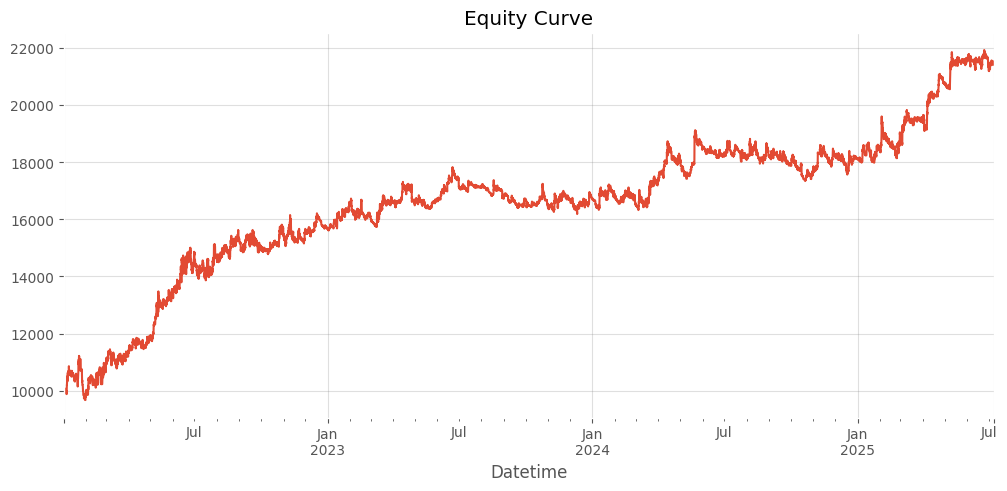

In [133]:
# Example with dummy prices & TEMA signals
IndicatorDF = CCIIndicator(PriceDF, cci_period)
SignalDF = signal_generation(IndicatorDF, mode = mode, exit_mode = exit_mode,
                             long_action = long_action, short_action = short_action) # mode = "mean_reversion" or "momentum", exit_mode = "midpoint" or "breakout"
TradingStrategy = TradingStrategy_optimised_optuna(SignalDF, max_holding = max_holding, max_holding_val = max_holding_val, stop_loss = stop_loss, stop_loss_val = stop_loss_val)
bt = backtest_cash_based(TradingStrategy, initial_capital = 10_000, trade_size = 0.5*10_000, trading_cost = 0.0003)

# Plot equity
import matplotlib.pyplot as plt
bt["Equity"].plot(figsize=(12,5), title="Equity Curve")
plt.show()

In [134]:
import pandas as pd

# Suppose your DataFrame is df with columns like [ROC, APO, ADX, CCI, TEMA, RSI, Total]
df = bt["Equity"].copy()

# 1. Resample to daily frequency (take the last value of each day)
df_daily = df.resample("1D").last()

# 2. Compute daily returns (period-to-period % change)
df_daily_ret = df_daily.pct_change().fillna(0)  # as decimal returns
# or multiply by 100 if you want percentages
df_daily_ret = df_daily_ret * 100

# keep only rows from 2022-01-01 onward
df_daily_ret = df_daily_ret.loc["2022-01-01":]

print(df_daily_ret.head())

Datetime
2022-01-01    0.000000
2022-01-02    0.106311
2022-01-03   -0.315436
2022-01-04   -0.563906
2022-01-05    2.686378
Freq: D, Name: Equity, dtype: float64


In [135]:
import numpy as np

# Assume df_daily_ret is your daily returns DataFrame from before
daily_returns = df_daily_ret / 100.0   # convert back to decimals if % was used
risk_free = 0.0
periods_per_year = 365

excess_ret = daily_returns - risk_free

sharpe_ratio = (
    excess_ret.mean() / excess_ret.std()
) * np.sqrt(periods_per_year)

print("Sharpe ratio (Total):", sharpe_ratio)

Sharpe ratio (Total): 1.3131018249357918


In [136]:
save_df(bt, "CCITradingStrategy", version=datetime.now().strftime("%Y%m%d-%H%M"))
save_df(TradingStrategy, "CCITradingStrategyDF", version=datetime.now().strftime("%Y%m%d-%H%M"))

PosixPath('data_store/CCITradingStrategyDF__20251117-1653.parquet')